In [1]:
# imports
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import EvalPrediction
from transformers import Trainer
from transformers import TrainingArguments
import evaluate
import torch
from typing import Any
from typing import Dict
from typing import Optional
from torch.utils.data import Dataset
from datasets import load_dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load and preprocess News dataset

In [2]:
data = load_dataset('masakhane/masakhanews', 'swa') 

display(data['train'][0])

def change_label(data_point):
    if data_point["label"] == 3:
        data_point["label"] = 1
    else:
        data_point["label"] = 0
    return data_point

politics_label_data = data.map(change_label)

display(politics_label_data)
display(politics_label_data["train"][:5])

masakhanews.py:   0%|          | 0.00/7.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Using the latest cached version of the dataset since masakhane/masakhanews couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'swa' at C:\Users\zachs\.cache\huggingface\datasets\masakhane___masakhanews\swa\1.0.0\8ccc72e69e65f40c70e117d8b3c08306bb788b60 (last modified on Tue Oct 15 23:10:27 2024).


{'label': 5,
 'headline': 'Tetesi za soka Ulaya Jumatatu 26.04.2021: Varane, Camara, Nagelsmann, Willock, Azpilicueta',
 'text': 'Chelsea wapo mbele ya  Manchester United na Paris St-Germain katika mbio za kutaka kumsajili beki wa Real Madrid na timu ya taifa ya Ufaransa Raphael Varane, 28. (Mundo Deportivo - in Spanish) Beki wa Guinea Ali Camara, 23, ambaye anachezea klabu ya Young Boys ya Switzerland, amezivutia klabu kadhaa za Ligi ya Primia zikiwemo  Liverpool, Arsenal, Crystal Palace, West Ham United na Norwich. (Team Talk) Bayern Munich imeanzisha mazungumzo ya kutaka kumsajili kocha wa RB Leipzig Julian Nagelsmann. (Independent) Arsenal wapo njia panda juu ya mustakabali wa kiungo wao Joe Willock, 21, ambaye yupo Newcastle kwa mkopo. Arsenal wanahitaji kuuza baadhi ya wachezaji ili kujiimarisha kifedha. (Football London) Kocha wa Atletico Madrid  Diego Simeone ana nia ya kumsajili beki raia wa Uhispania Cesar Azpilicueta, 31, kutoka  Chelsea. (El Gol Digital - in Spanish) Manche

DatasetDict({
    train: Dataset({
        features: ['label', 'headline', 'text', 'headline_text', 'url'],
        num_rows: 1658
    })
    validation: Dataset({
        features: ['label', 'headline', 'text', 'headline_text', 'url'],
        num_rows: 237
    })
    test: Dataset({
        features: ['label', 'headline', 'text', 'headline_text', 'url'],
        num_rows: 476
    })
})

{'label': [0, 0, 1, 0, 0],
 'headline': ['Tetesi za soka Ulaya Jumatatu 26.04.2021: Varane, Camara, Nagelsmann, Willock, Azpilicueta',
  'Je chanjo ya corona ni salama?',
  'Matokeo ya uchaguzi Marekani 2020: Donald Trump amfuta kazi Waziri wa Ulinzi Mark Esper',
  'Je wajua mwanamke na mwanaume hawapaswi kufanya mazoezi pamoja?',
  'Watoto waliolazimika kuwa kimya kuhusu baba zao wakutana na maaskofu jijini Paris'],
 'text': ['Chelsea wapo mbele ya  Manchester United na Paris St-Germain katika mbio za kutaka kumsajili beki wa Real Madrid na timu ya taifa ya Ufaransa Raphael Varane, 28. (Mundo Deportivo - in Spanish) Beki wa Guinea Ali Camara, 23, ambaye anachezea klabu ya Young Boys ya Switzerland, amezivutia klabu kadhaa za Ligi ya Primia zikiwemo  Liverpool, Arsenal, Crystal Palace, West Ham United na Norwich. (Team Talk) Bayern Munich imeanzisha mazungumzo ya kutaka kumsajili kocha wa RB Leipzig Julian Nagelsmann. (Independent) Arsenal wapo njia panda juu ya mustakabali wa kiungo w

## Load Pre-Trained Model
### AfriBerta

In [3]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, PreTrainedModel

tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_base")
model = AutoModelForSequenceClassification.from_pretrained("castorini/afriberta_base",num_labels=2, problem_type = "single_label_classification")

def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
        "castorini/afriberta_base",
        num_labels=2,
        problem_type = "single_label_classification"
    )

tokenizer.model_max_length = 512

c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassific

## Tokenize Data

In [4]:

def tokenize_function(datapoints):
    return tokenizer(datapoints["headline_text"], padding="max_length", truncation=True)


tokenized_datasets = politics_label_data.map(tokenize_function, batched=True)

#small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
#small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

tokenized_datasets['test']

Dataset({
    features: ['label', 'headline', 'text', 'headline_text', 'url', 'input_ids', 'attention_mask'],
    num_rows: 476
})

## Train Baseline on News Dataset

In [5]:

from transformers import DataCollatorWithPadding

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True),
    }

# Define custom loss function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred: EvalPrediction) -> Dict[str, float]:
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


training_args = TrainingArguments(output_dir="baseline",
                                  learning_rate=1.1216250939689517e-05,
                                  eval_strategy="epoch")

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer= tokenizer,
    #model_init=model_init,
    compute_metrics=compute_metrics,
)

#best_trial = trainer.hyperparameter_search(
#    direction="maximize",
#    backend="optuna",
#    hp_space=optuna_hp_space,
#    n_trials=5,
#)

trainer.train()

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.3465575575828552, 'eval_accuracy': 0.890295358649789, 'eval_f1': 0.7903225806451613, 'eval_precision': 0.6621621621621622, 'eval_recall': 0.98, 'eval_runtime': 3.0306, 'eval_samples_per_second': 78.203, 'eval_steps_per_second': 9.899, 'epoch': 1.0}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.2143508940935135, 'eval_accuracy': 0.9282700421940928, 'eval_f1': 0.8495575221238938, 'eval_precision': 0.7619047619047619, 'eval_recall': 0.96, 'eval_runtime': 2.9557, 'eval_samples_per_second': 80.185, 'eval_steps_per_second': 10.15, 'epoch': 2.0}


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


{'loss': 0.2029, 'grad_norm': 0.07998090237379074, 'learning_rate': 2.2288703790408653e-06, 'epoch': 2.4}


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


  0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 0.15216737985610962, 'eval_accuracy': 0.9620253164556962, 'eval_f1': 0.9108910891089109, 'eval_precision': 0.9019607843137255, 'eval_recall': 0.92, 'eval_runtime': 5.567, 'eval_samples_per_second': 42.572, 'eval_steps_per_second': 5.389, 'epoch': 3.0}
{'train_runtime': 1086.8395, 'train_samples_per_second': 4.577, 'train_steps_per_second': 0.574, 'train_loss': 0.18430692721635866, 'epoch': 3.0}


TrainOutput(global_step=624, training_loss=0.18430692721635866, metrics={'train_runtime': 1086.8395, 'train_samples_per_second': 4.577, 'train_steps_per_second': 0.574, 'total_flos': 875500023730176.0, 'train_loss': 0.18430692721635866, 'epoch': 3.0})

In [6]:
model.eval()

from datasets import load_dataset
from evaluate import evaluator
from transformers import AutoModelForSequenceClassification, pipeline


task_evaluator = evaluator("text-classification")

eval_results = task_evaluator.compute(
    tokenizer=tokenizer,
    model_or_pipeline=model,
    data=tokenized_datasets['test'],
    metric=evaluate.combine(["accuracy", "recall", "precision", "f1"]),
    label_mapping={"LABEL_0": 0, "LABEL_1": 1}
)
print(eval_results)


{'accuracy': 0.9222689075630253, 'recall': 0.74, 'precision': 0.8705882352941177, 'f1': 0.8, 'total_time_in_seconds': 14.619025899999542, 'samples_per_second': 32.56030896012127, 'latency_in_seconds': 0.030712239285713323}


########
INPUT 0
Top 5 attended tokens: ['bar' 'po' 'nd' 'ua' 'su']


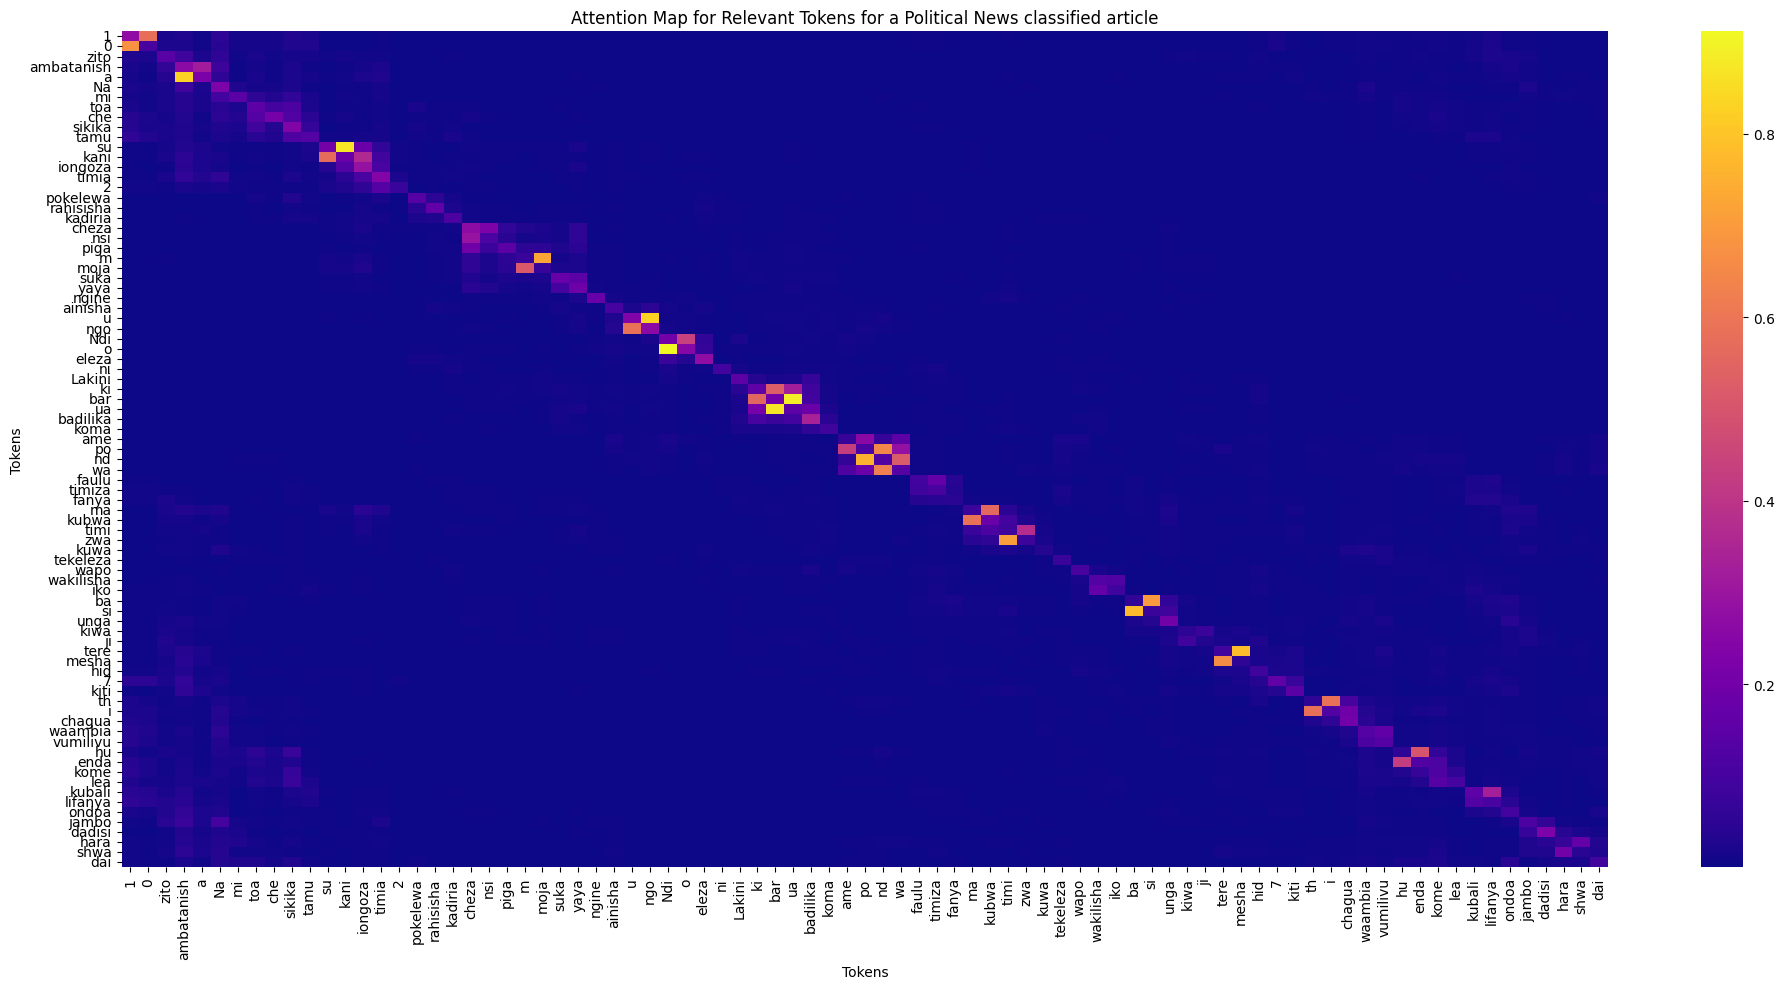

<s> Siku 100 za utawala wa Ruto: Uzito kwa rais wa Kenya kuambatanisha maneno na vitendo Siku zina kasi.Na hazina huruma iwapo ndimi za viongozi wa kisiasa zinatoa cheche na ahadi na kusikika kama wimbo mtamu katika masikio ya wapiga kura na wananchi kwa jumla. Kwa rais wa Kenya William Ruto siku zake 100 akiwa usukani kuiongoza nchi hiyo zimetimia leo tarehe 22 Disemba 2022. Katikati ya harakati za kampeni alitoa ahadi nyingi mno ambazo kwa wafuasi wake zilipokelewa kama mwanzo wa matumaini ya kurahisisha hali zao. Hata hivyo sio rahisi kukadiria mafanikio ya utawala wake katika siku 100 bila kuzingatia mambo kadhaa. Kuna tofauti ya mcheza densi na mpiga gita-mmoja ana utaalamu wa kusuka sauti za nyaya za gita kutoa mlio wa kuvutia kuwa muziki. Mwingine hana kubwa ila kusikia mlio huo mtamu na kuuainisha na densi ya maungo ya mwili wake kuunda densi.Ndio hali inayoeleza kinachofanyika sasa kuhusiana na matumaini ya wengi wakati wa kampeni na hali halisi wakati huu ambapo Ruto amekuwa 

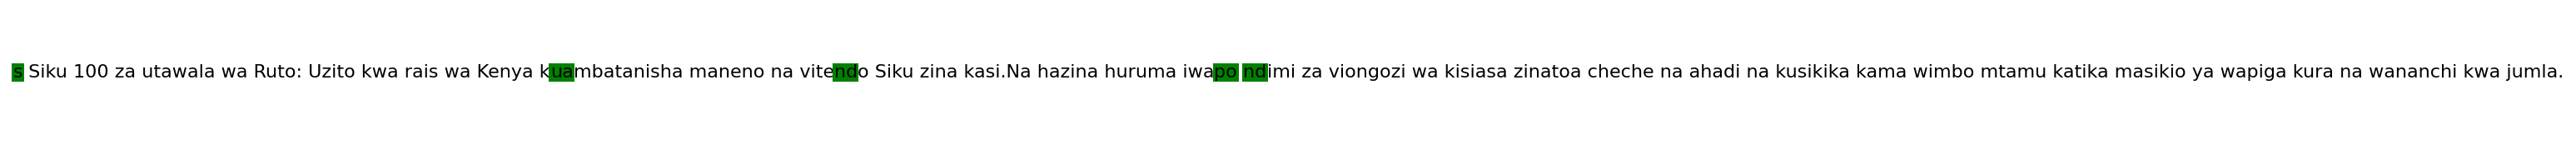

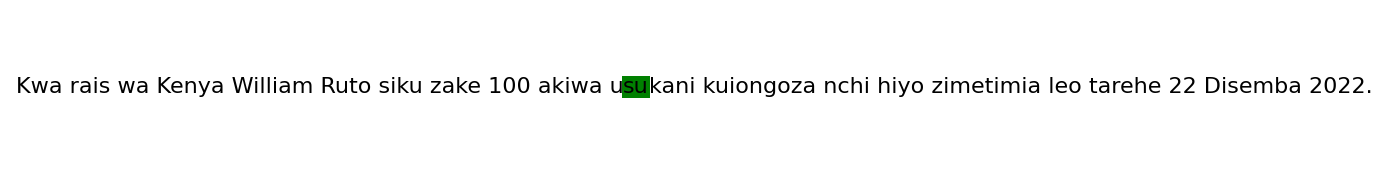

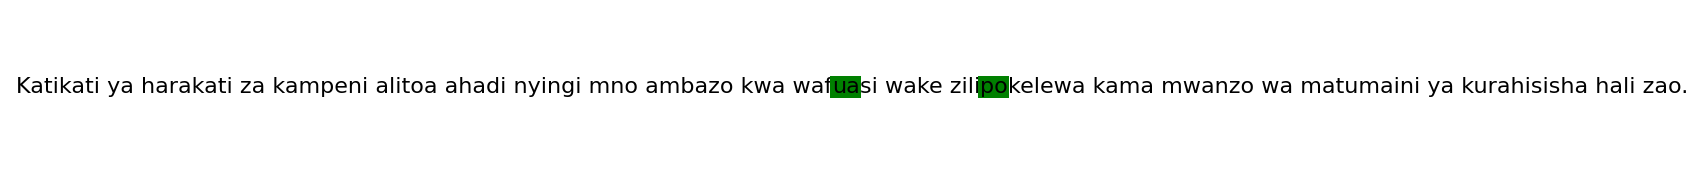

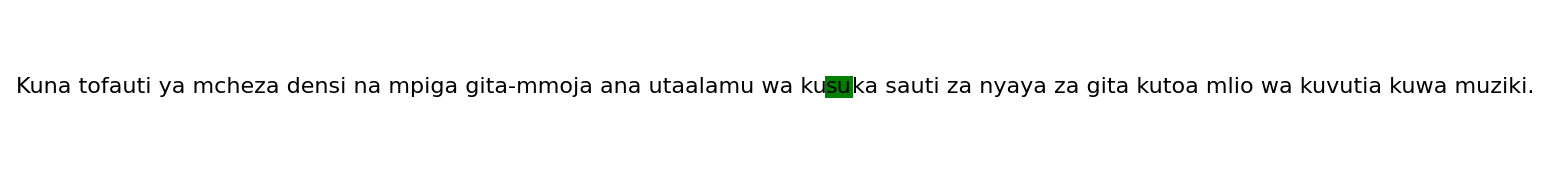

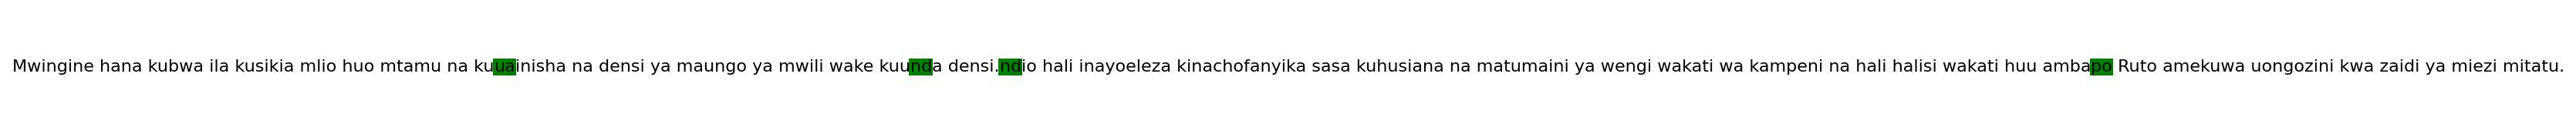

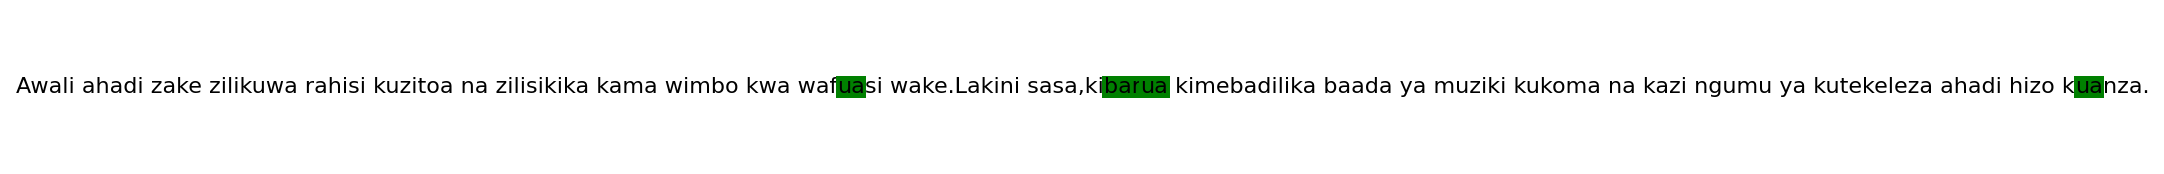

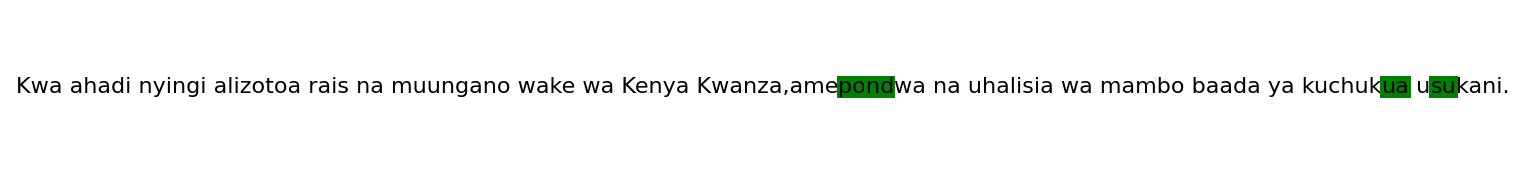

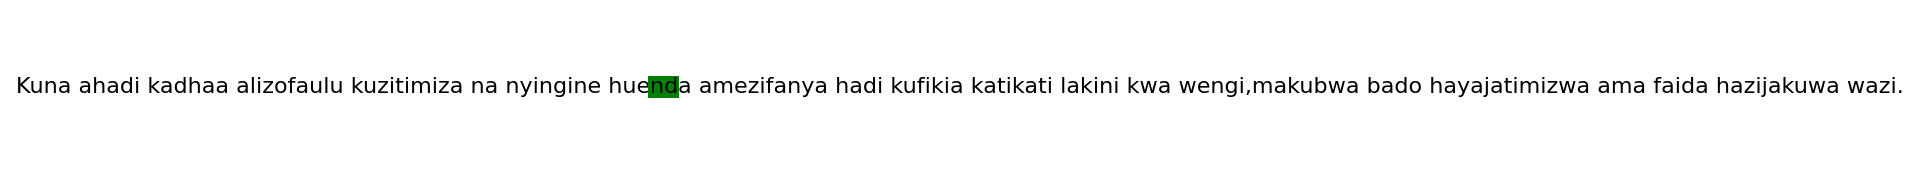

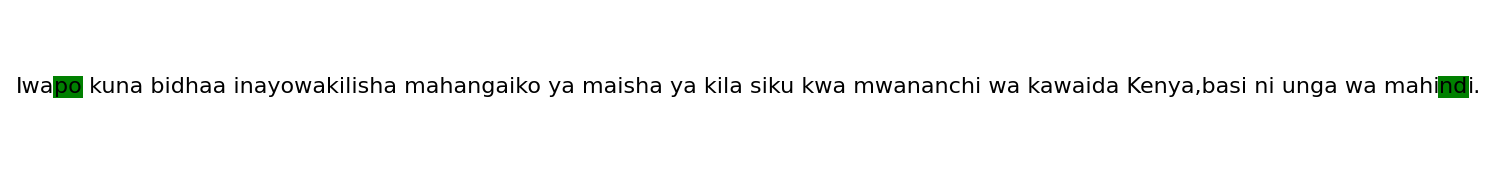

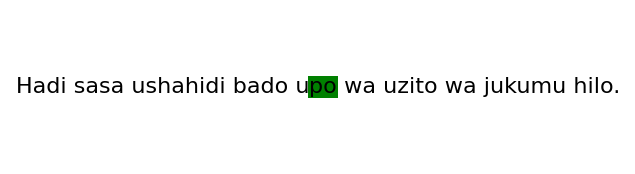

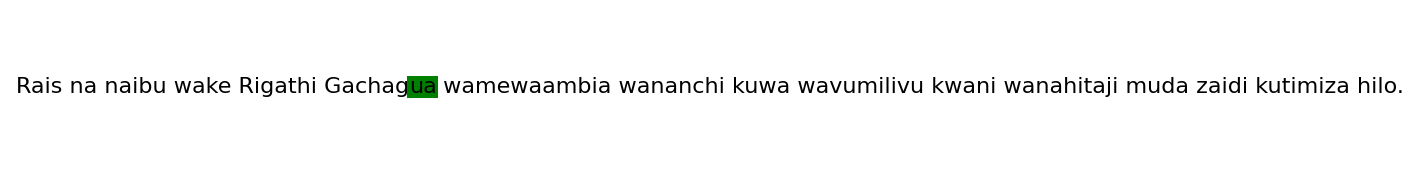

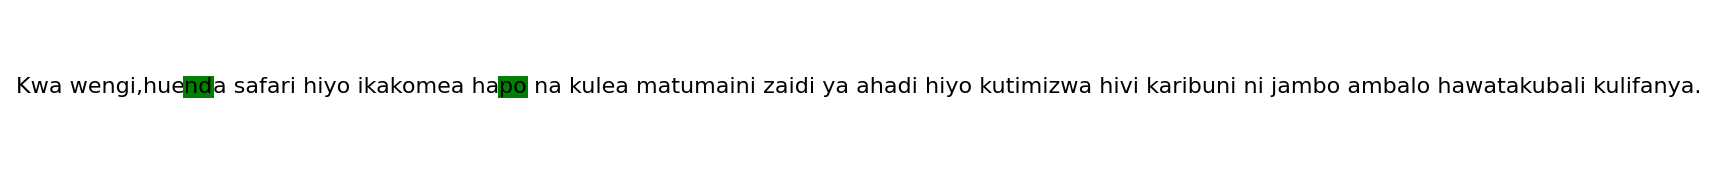

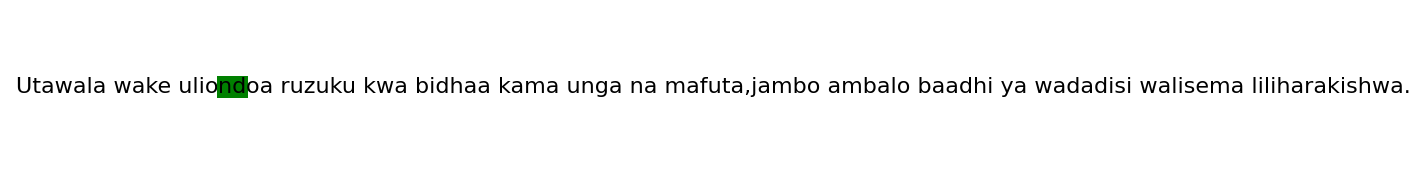

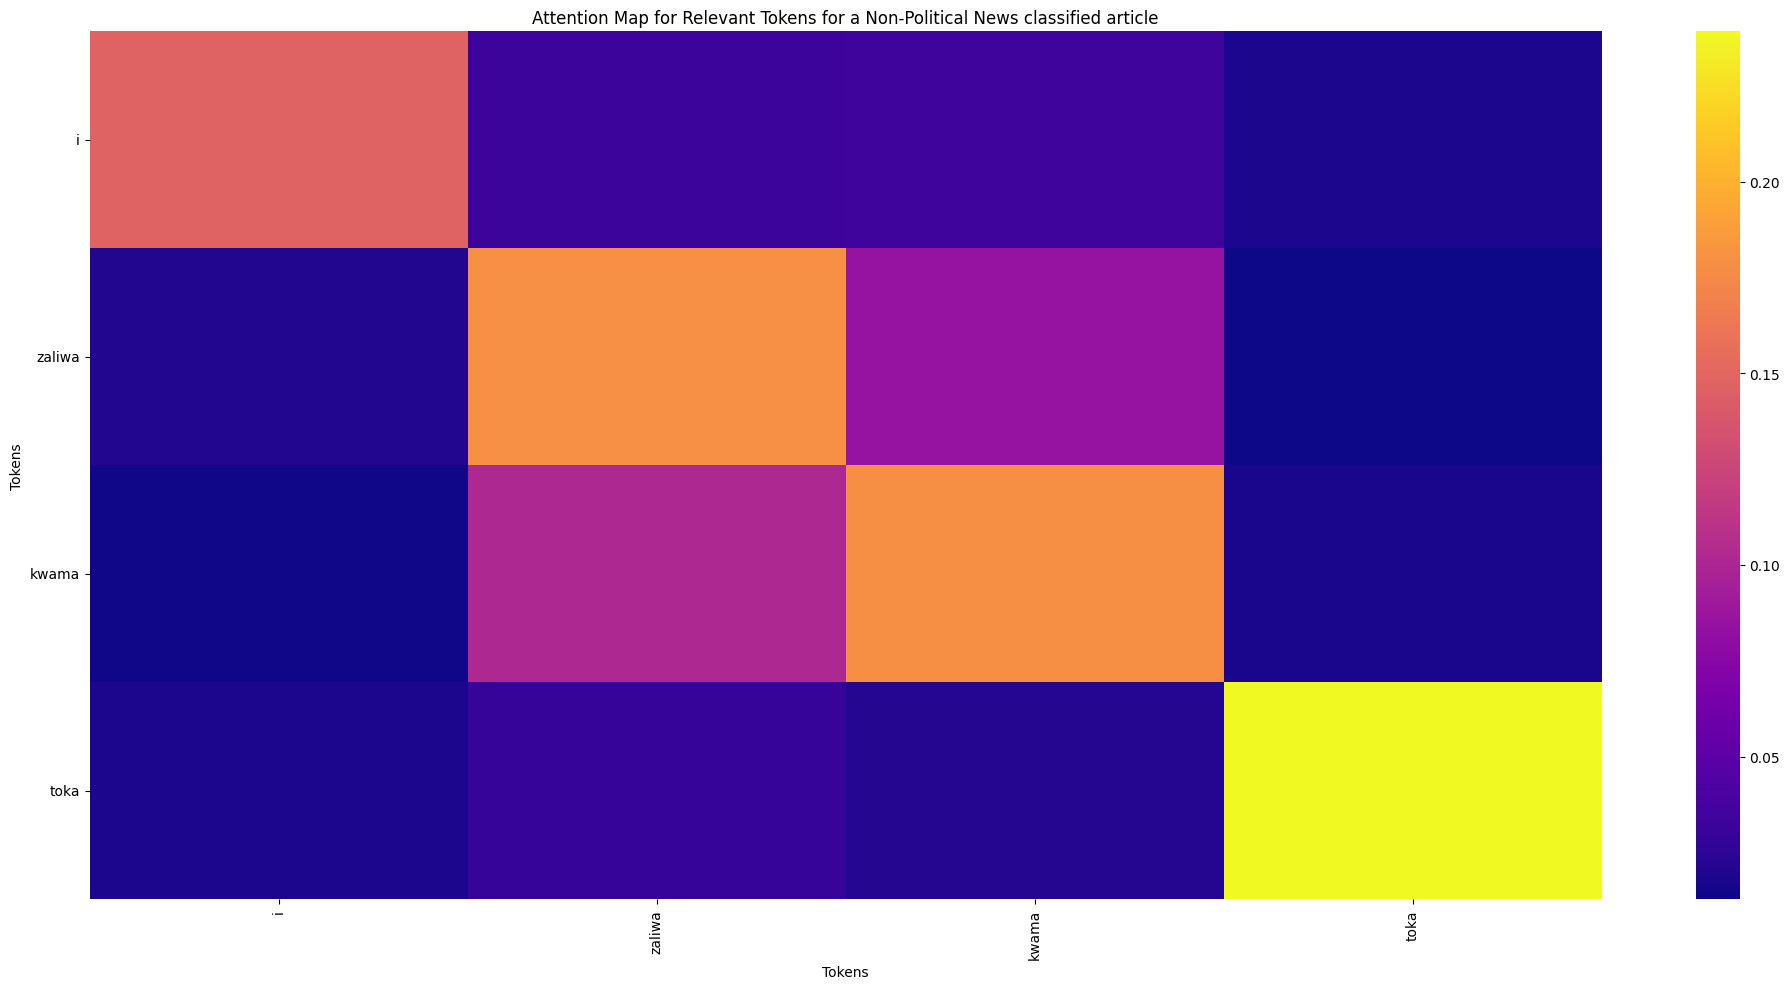

<s> Virusi vya corona: Kwa nini watoto waliozaliwa na kina mama wa kupanga wamekwama Ukraine? Watoto waliozaliwa na kina mama wa kupanga wamekwama nchini Ukraine kutokana na masharti ya kutotoka nje kukabiliana na virusi vya corona.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

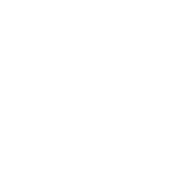

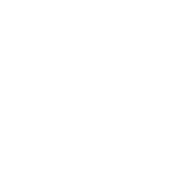

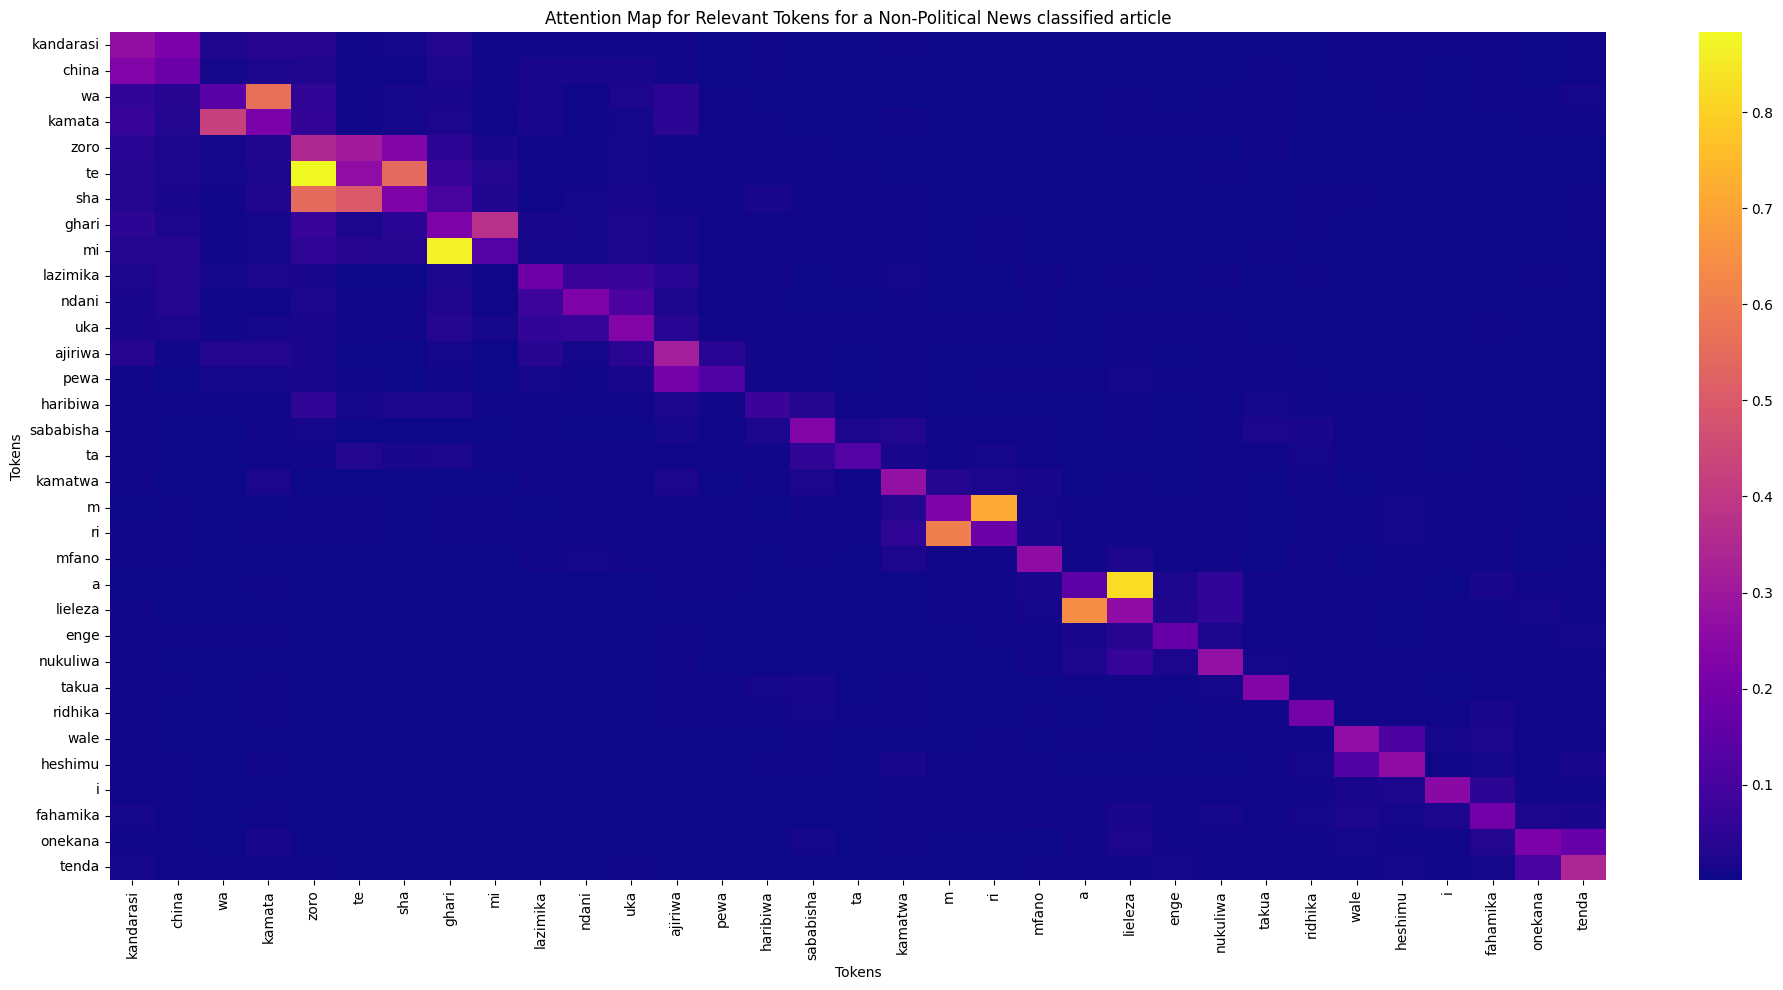

<s> Wakandarasi Wachina wafanyakazi chini ya usimamizi wa polisi Dar es Salaam Mamlaka nchini Tanzania zimewakamata wakandarasi raia wa China wanne kwa makosa ya kuzorotesha maendeleo ya mradi uliogharimiwa na serikali jijini Dr es Salaam. Sasa wakandarasi hao watalazimika kukaa "ndani" na kurauka toka polisi kila siku kwenda kufanya kazi. Wakandarasi hao waliajiriwa na Kampuni mbili zilizopewa kandarasi na serikali ya Tanzania ya kujenga daraja na sehemu ya barabara baada ya kuharibiwa na mvua kubwa. Hali hii ilisababisha shughuli za kiuchumi kuzorota au kusimama katika eneo hilo kwa saa kadhaa. Kukamatwa huko kwa wakandarasi kuliamriwa na Mkuu wa mkoa wa Dar es Salaam, Paul Makonda, na kuwa ni ''mfano kwa wengine'' waliopewa majukumu ya namna hiyo na mamlaka,alieleza katibu wake Abubakar Kunenge, akinukuliwa na shirika la habari la Ufaransa. Bwana Kunenge amesema watu hao ''watakua kwenye kituo kikuu cha polisi na kuamkia huko kwenda kusimamia kazi mpaka pale mkuu wa mkoa atakaporidh

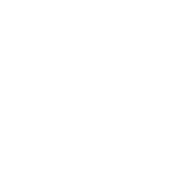

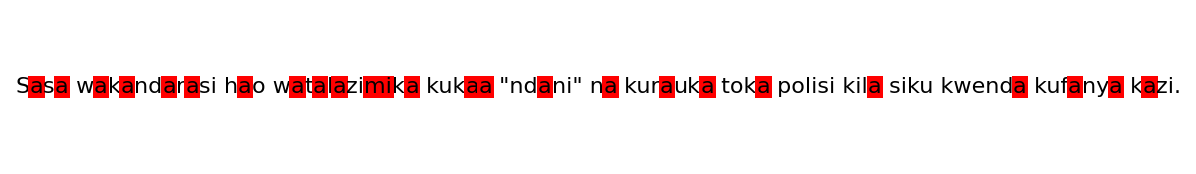

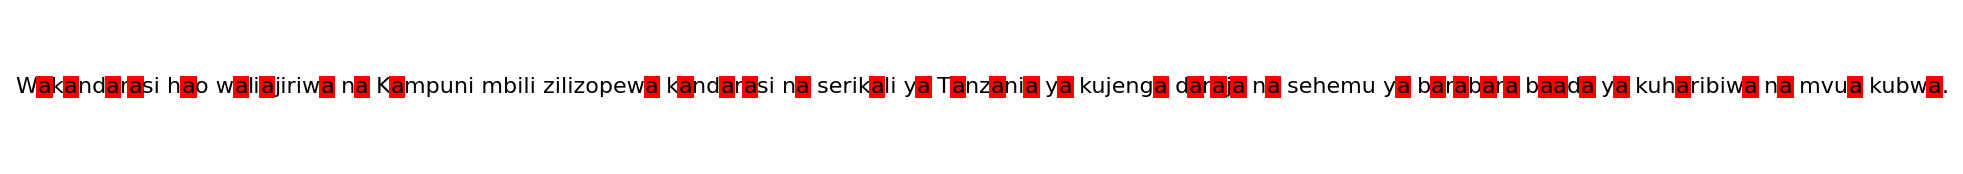

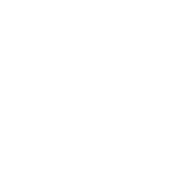

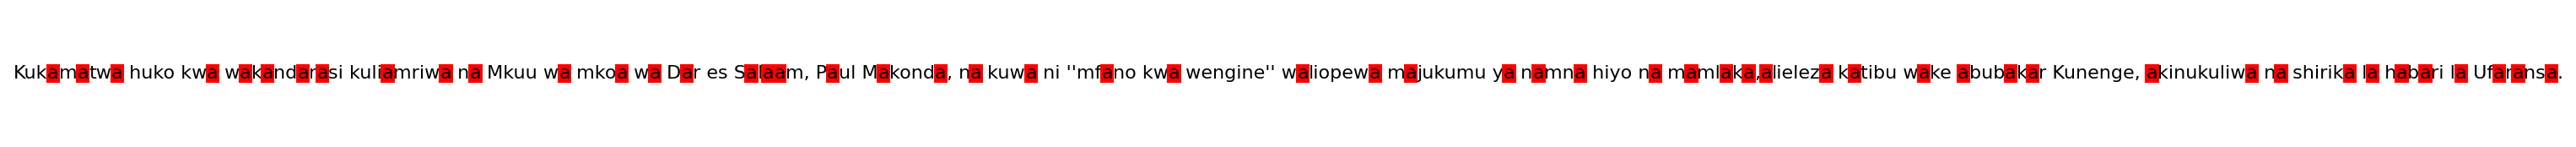

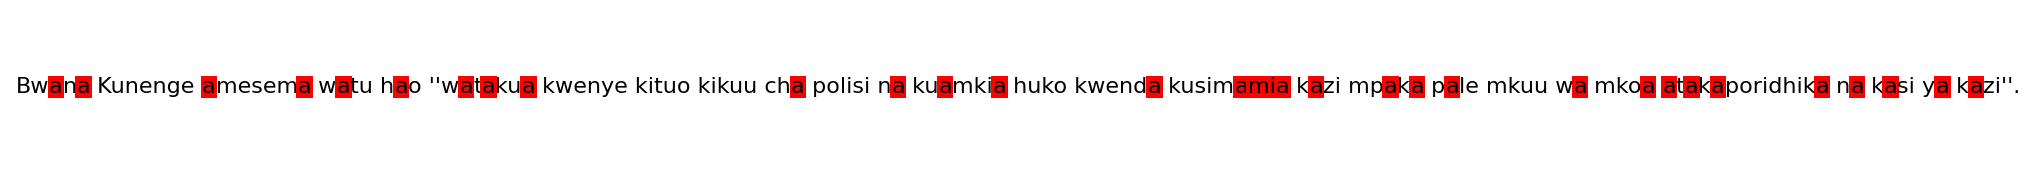

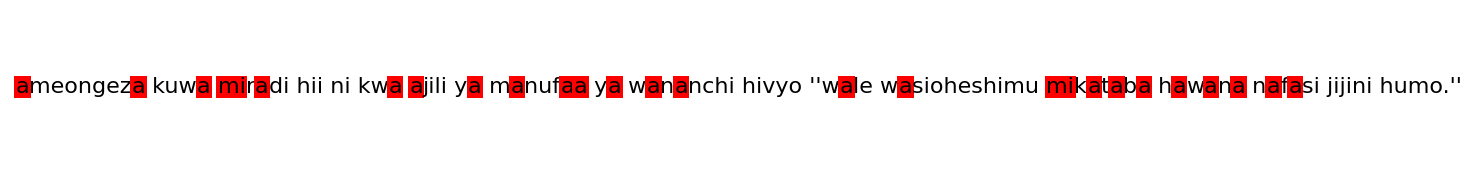

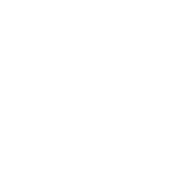

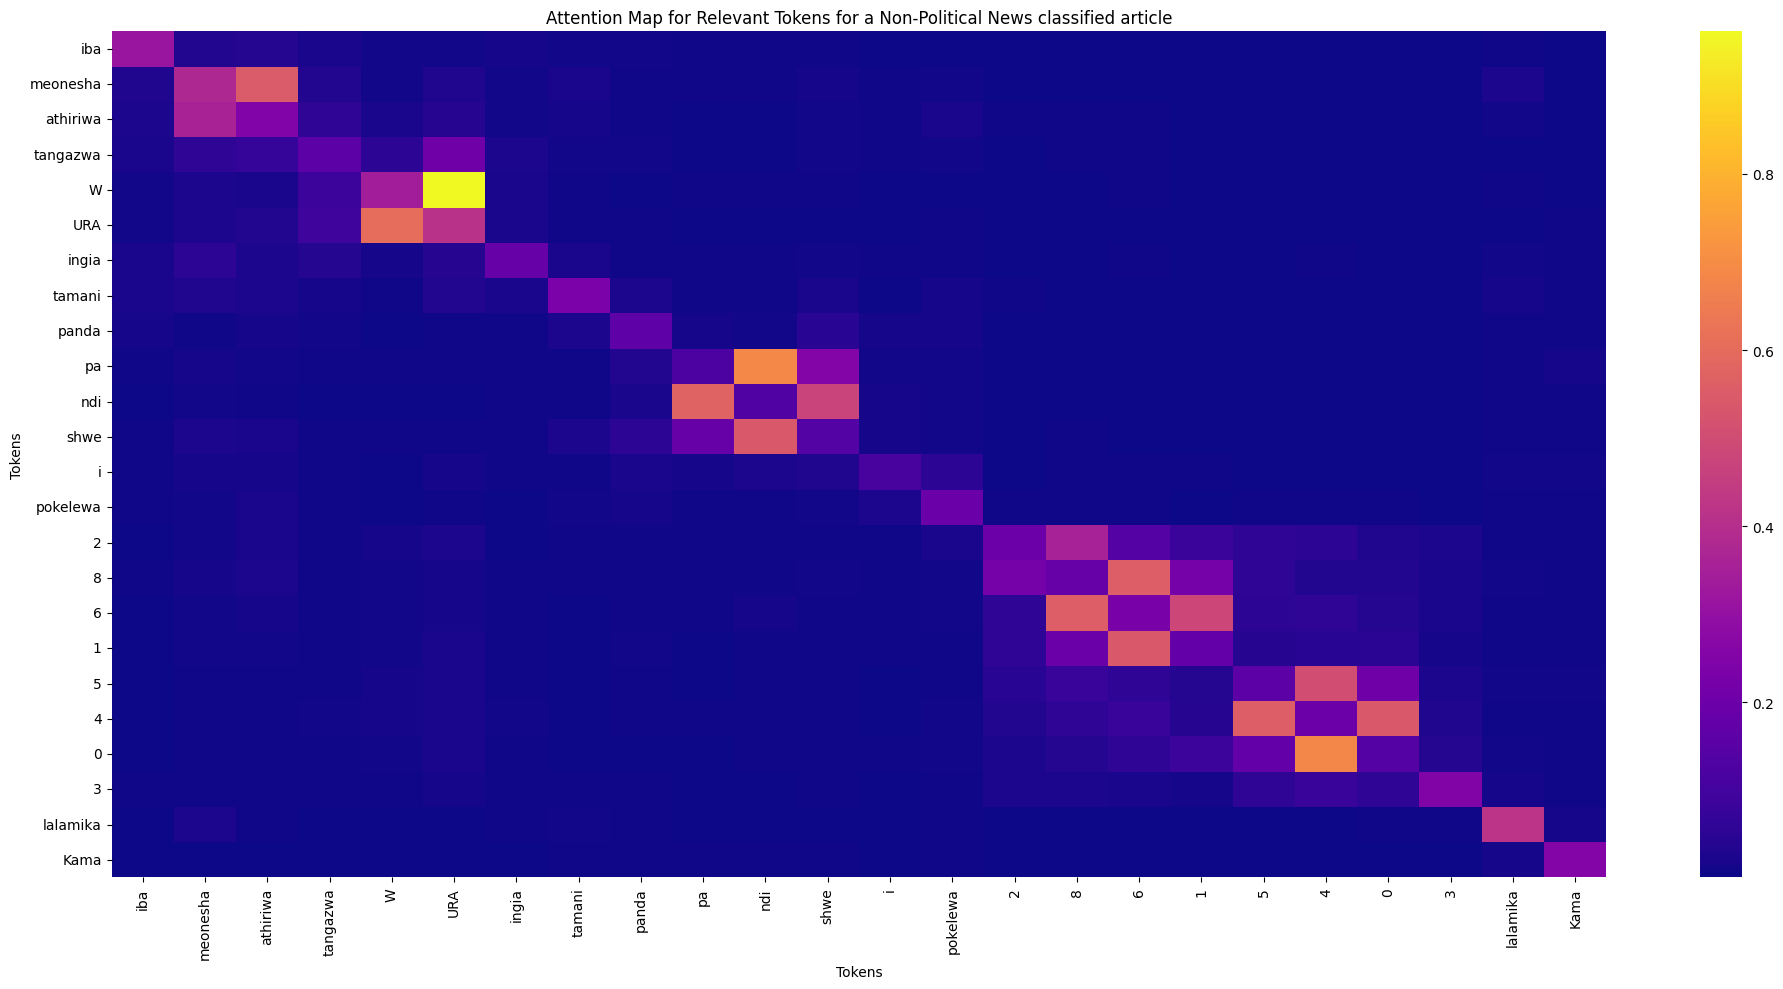

<s> Tanzania: Bei mpya ya mafuta ilivyo mwiba kwa wamiliki wa vyombo vya usafiri Baadhi ya wamiliki wa vyombo vya moto vya usafiri wameonesha kuathiriwa na upandaji wa bei za mafuta uliotangazwa na EWURA hapo jana. BBC imeingia mitaani na kuongea na baadhi ya wamiliki wa vyombo vya moto ambao wengi wao wanatamani kuona kama bei ya mafuta itapanda basi nazo gharama za usafirishaji zipandishwe. Bei mpya ya petroli kwa mafuta yanayopokelewa kupitia Bandari ya Dar es salaam itakuwa Sh2,861 kutoka Sh 2,540 ikiwa ni ongezeko la Sh321. Bei ya nishati hiyo inapanda wakati wananchi wakilalamika kuongezeka kwa bei za bidhaa mbalimbali za vyakula hasa wakati huu wa mwezi Mtukufu wa Ramadhani. 'Kama bei ya mafuta imepanda basi bei ya usafirishaji abiria nayo ipandishwe'</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

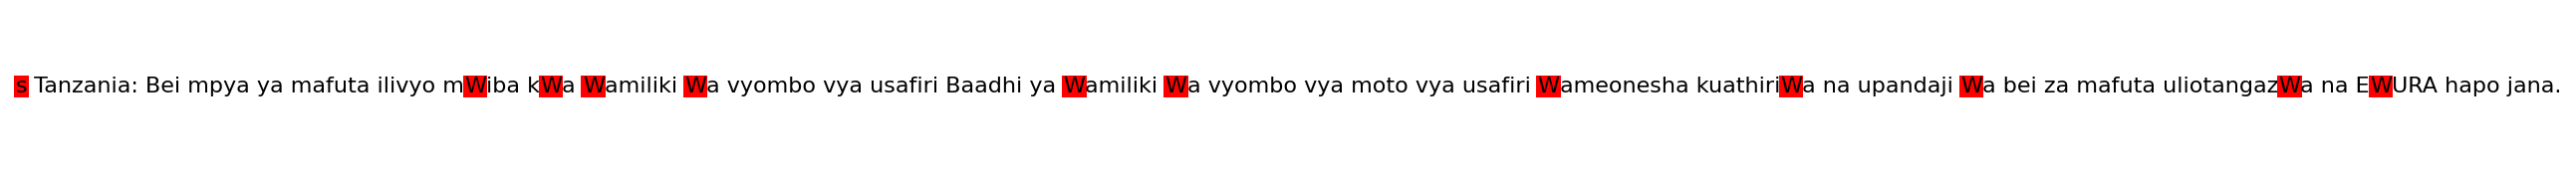

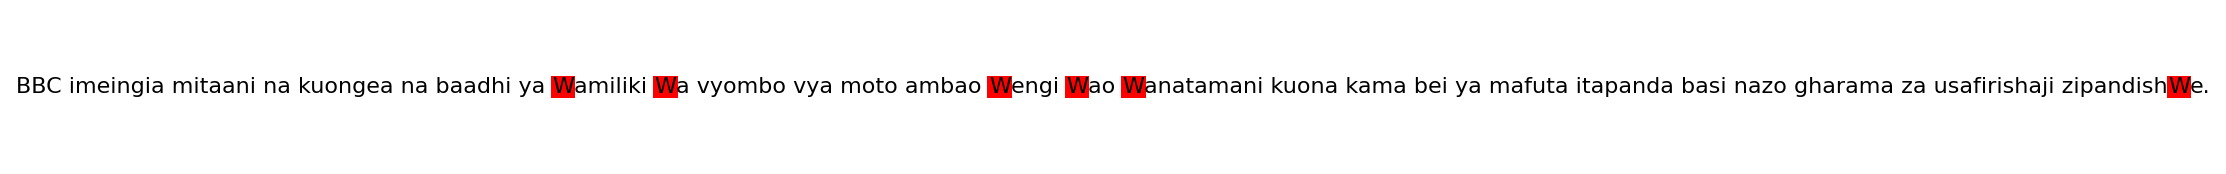

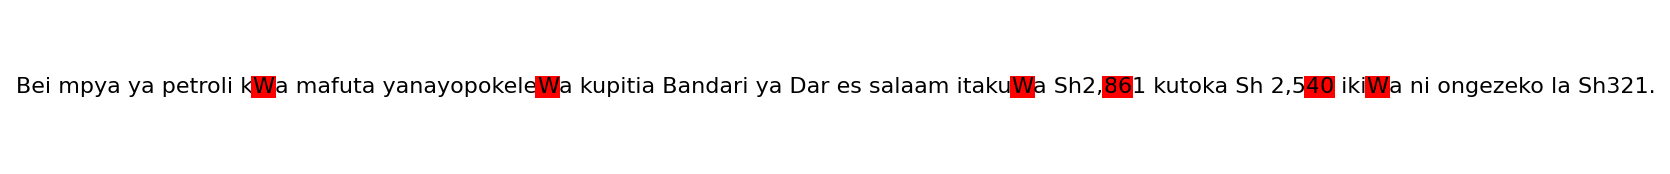

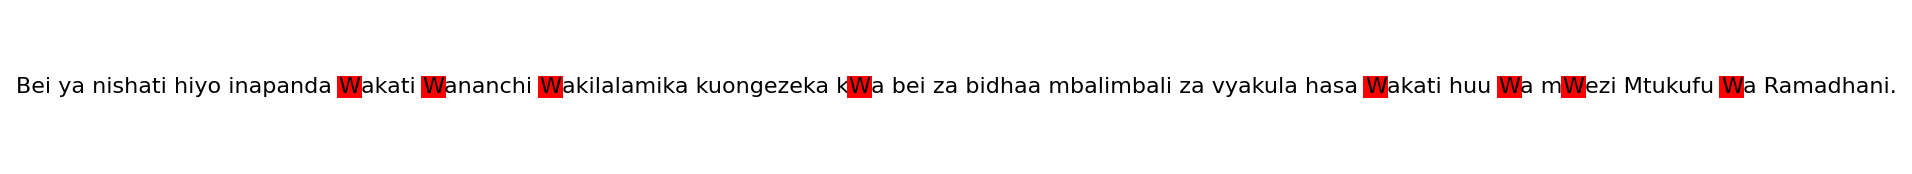

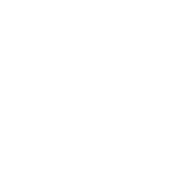

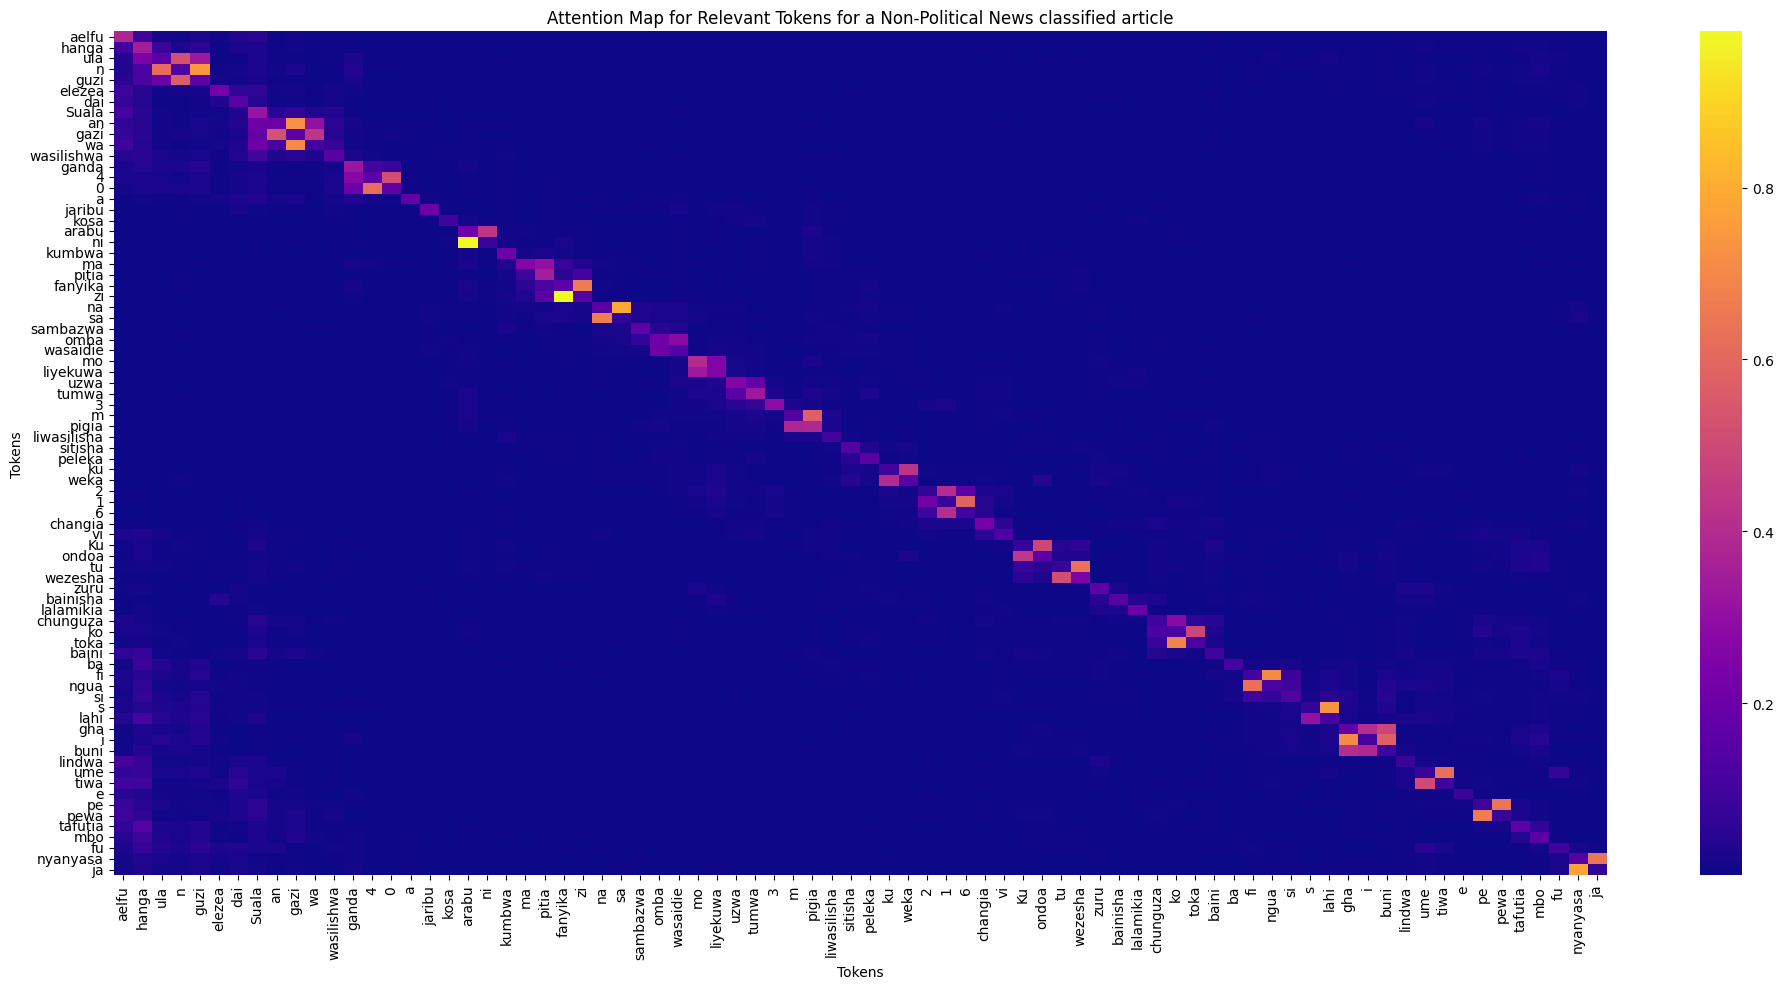

<s> Maelfu ya raia wa Uganda ni wahanga wa 'ulanguzi wa binadamu' Oman Uganda imelezea hofu yake kuhusu hali ya raia wa nchi hiyo wanaofanya kazi Oman ikidai kuwa huenda ni wahanga ''ulanguzi'' wa binadamu. Suala hilo limeangaziwa katika ripoti iliyowasilishwa bungeni leo Ijumaa. Zaidi ya Waganda 40,000 wanafanya kazi Oman - taifa ambalo halina makubaliano yoyote ya kibiashara. Serikali ya Uganda imekuwa ikijaribu kuwafikia raia wake ambao ni wahamiaji wanaofanya kazi Mashariki ya Kati baada ya kupokea simu za kutafuta usaidizi kutoka kwa raia hao wanaofanya kazi za ndani. Wengi wao ni wanawake ambao wamekosa nafasi ya ajira chini mwao na kuamua kutafuta kazi katika mataifa ya Uarabuni. Lakini mpango wa ajira kwa wahamiaji umekumbwa na madai ya unyanyasaji wa kingono pamoja na dhulma wanazopitia wafanyikazi wa ndani kutoka kwa waajiri wao. Wengi wao wamekuwa wakinasa kanda za video na kuzisambazwa katika mitandao ya kijamii wakiomba jamaa na marafiki wawasaidie kurudi nyumbani. Katika 

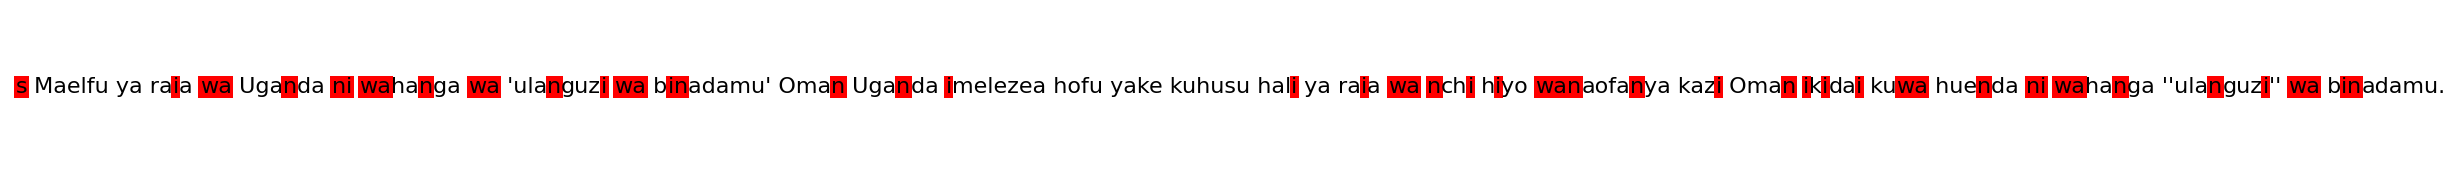

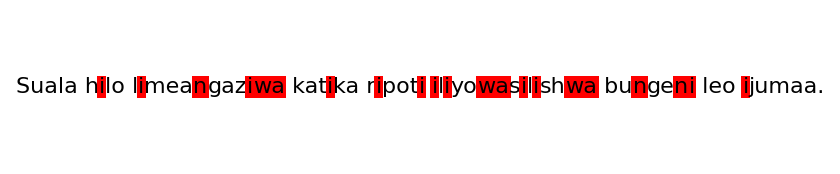

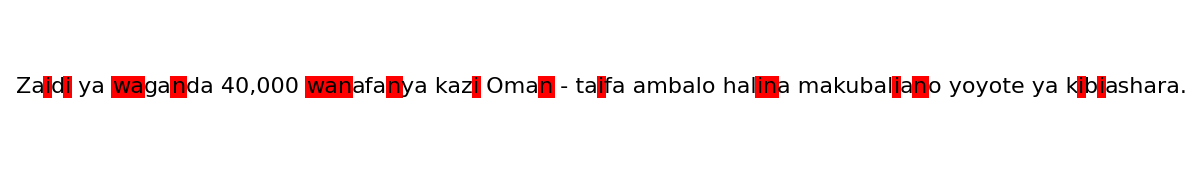

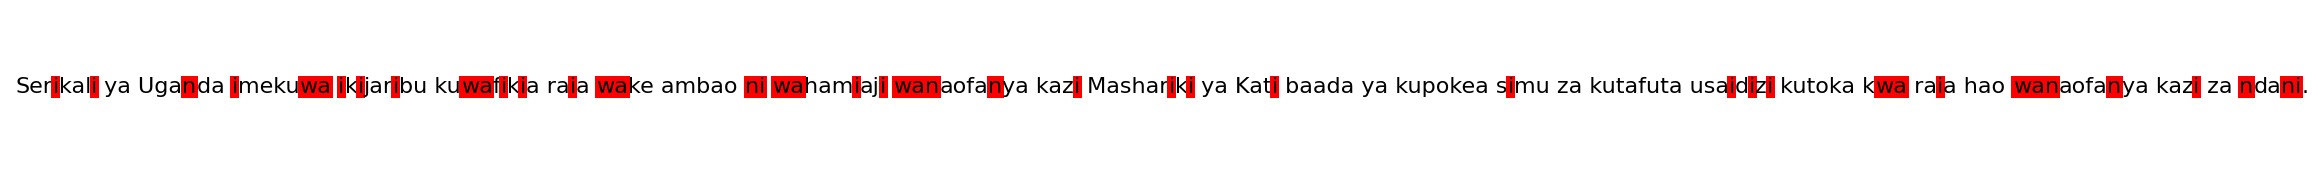

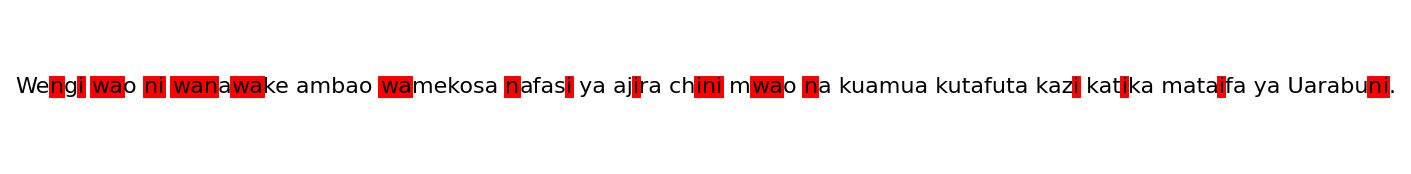

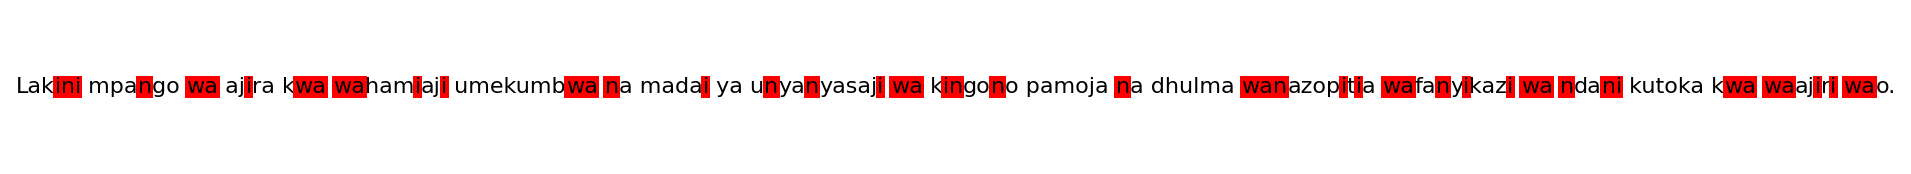

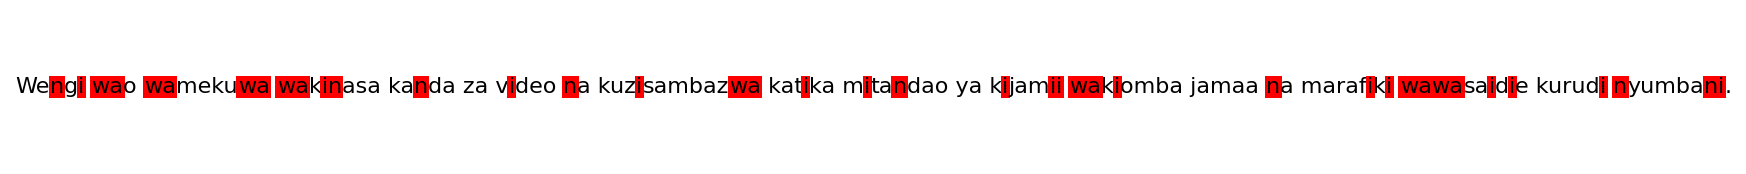

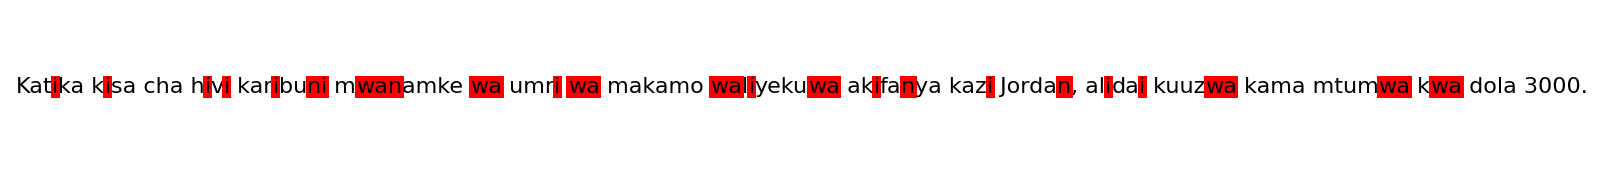

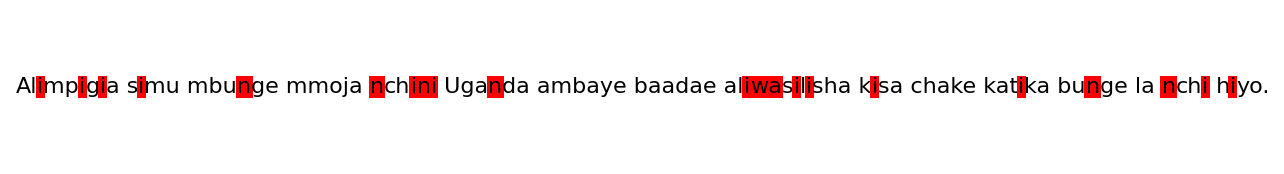

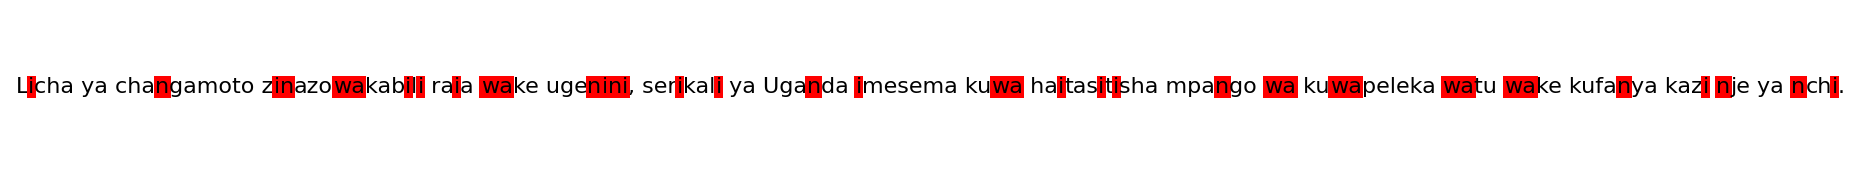

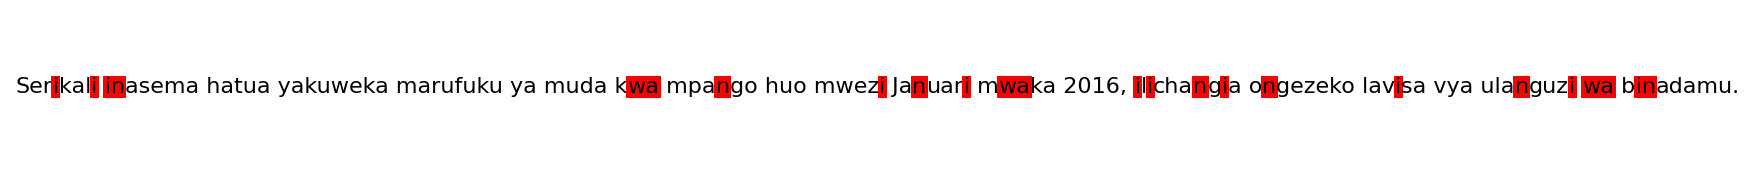

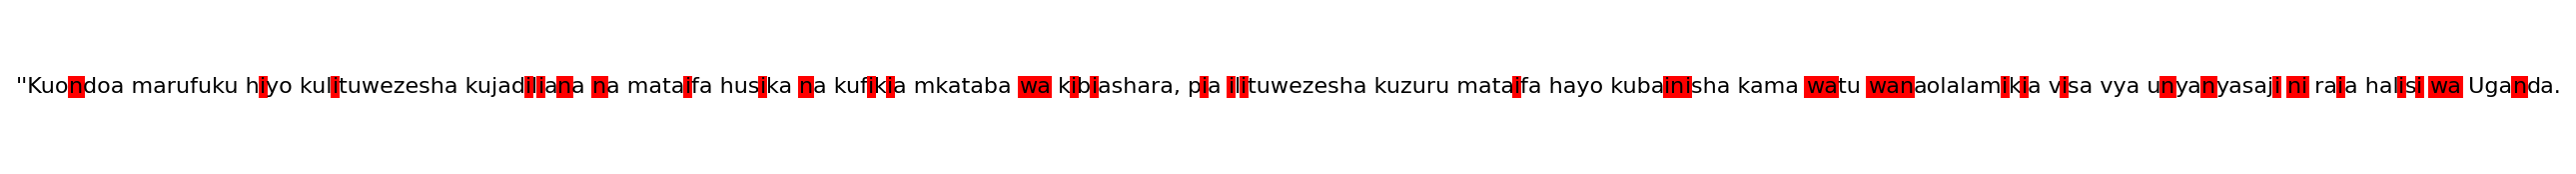

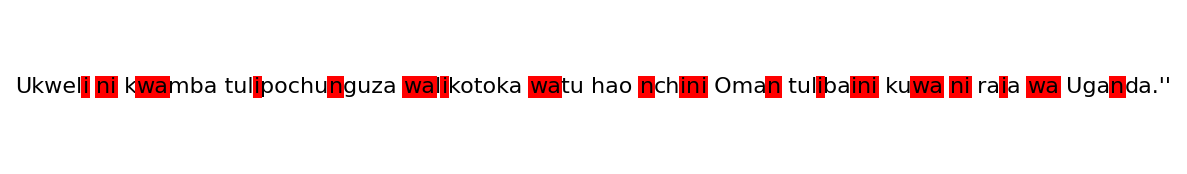

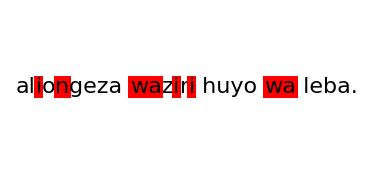

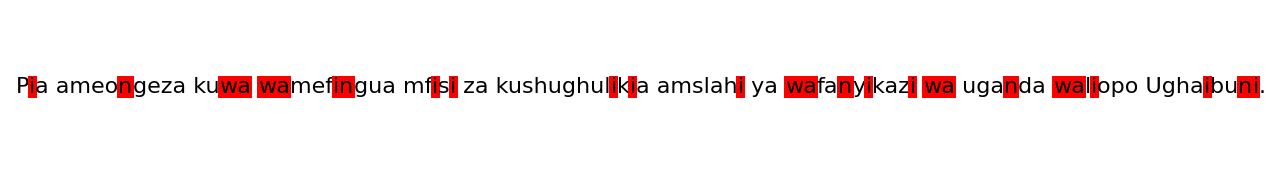

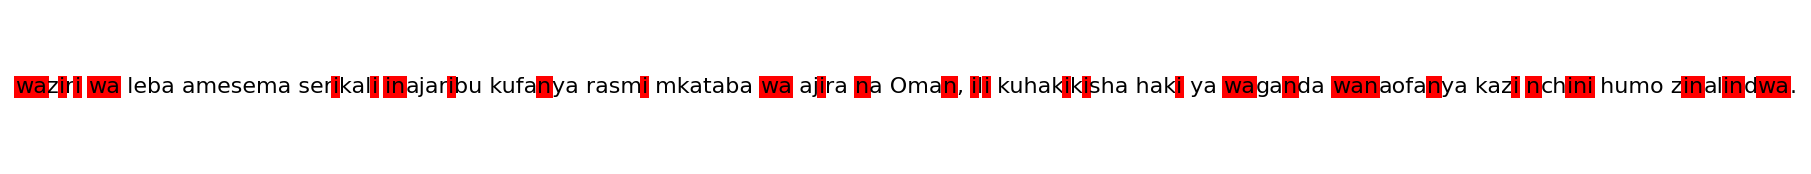

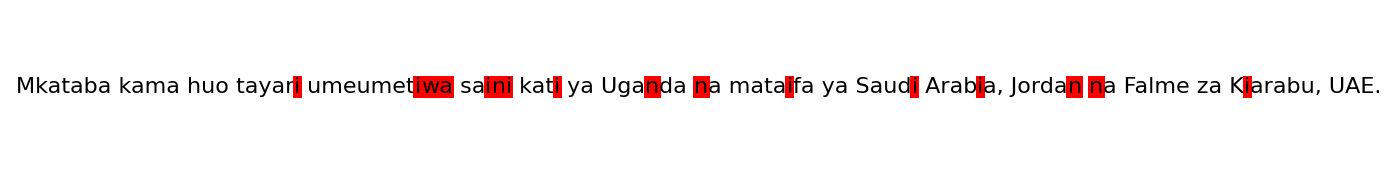

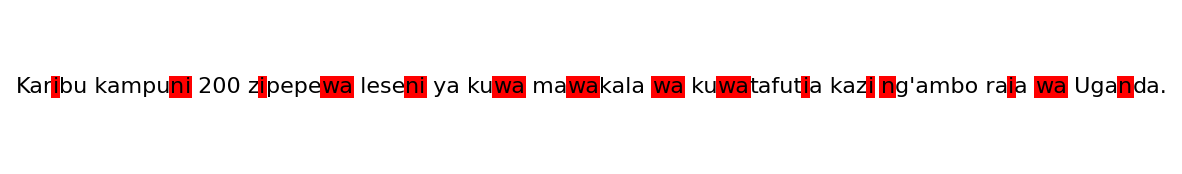

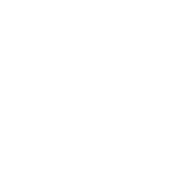

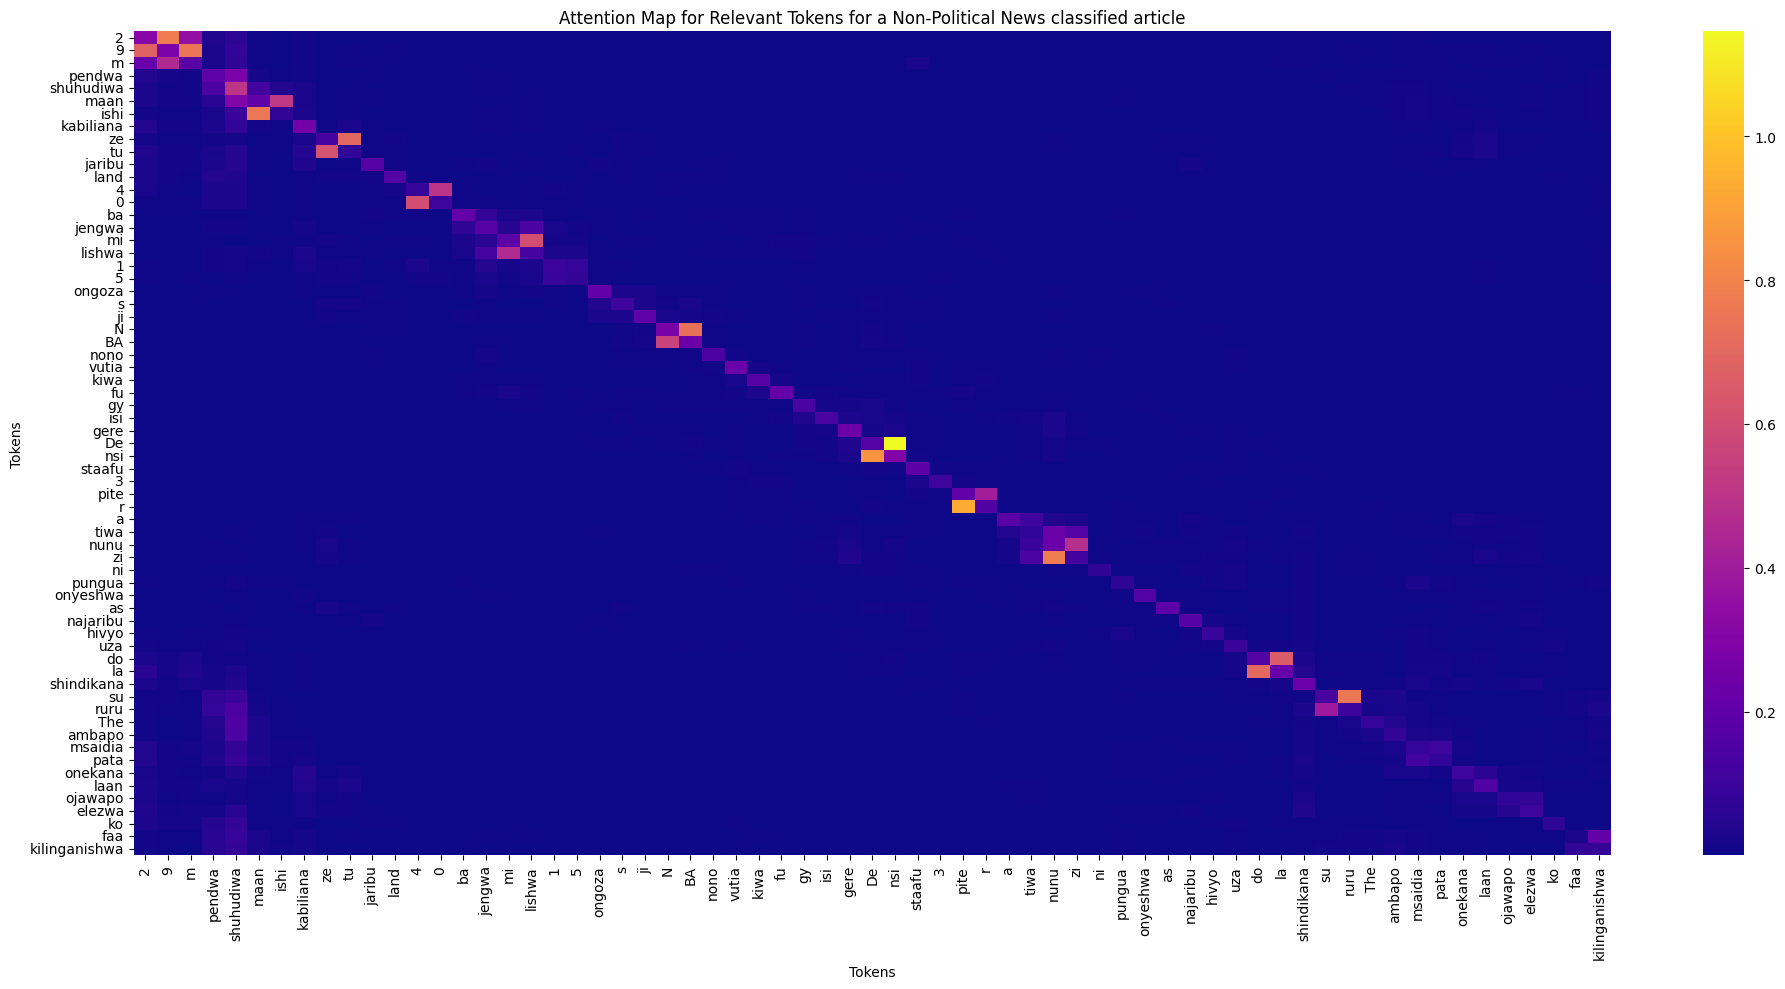

<s> Kwanini Michael Jordan hawezi kuuza jumba lake la kifahari kwa $29m Kuwa mmoja watu tajiri zaidi na mchezaji aliyependwa zaidi na watu kuwahi kushuhudiwa haimaanishi kwamba Michael Jordan anaweza kuepuka matatizo ambayo wengi wetu tunakabiliana nayo katika kuuza malizetu. Kwa miaka kumi, mchezaji huyo maarufu wa mpira wa kikapu amekuwa akijaribu kuuza jumba lake la kifahari lililopo katika Highland Park, mji uliopo katika jimbo la Marekani la Illinois, karibu kilomita 40 kutoka Chicago. Jumba hilo lililojengwa na kukamilishwa katika mwaka 1995, lilikuwa ni makazi ya Jordan katika miaka ya 1990, wakati alipoongoza timu ya Chicago Bulls kuchukua mataji matatu ya Shirikisho la mpira wa kikapu la taifa (NBA) na kupata malipo makubwa zaidi ya nyingi kupitia mikataba minono ya udhamini. Jumba la kifahari la Highland Park ni jumba linalovutia hata kwa viwango vya watu maarufu. Likiwa na vyumba tisa na bafu 19 lina ukubwa eneo la mita za mraba 5,000 na lina maeneo muhimu kama vile sinema, 

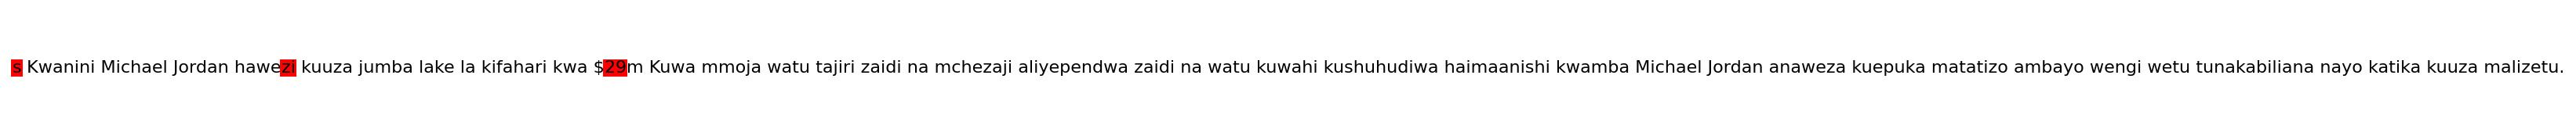

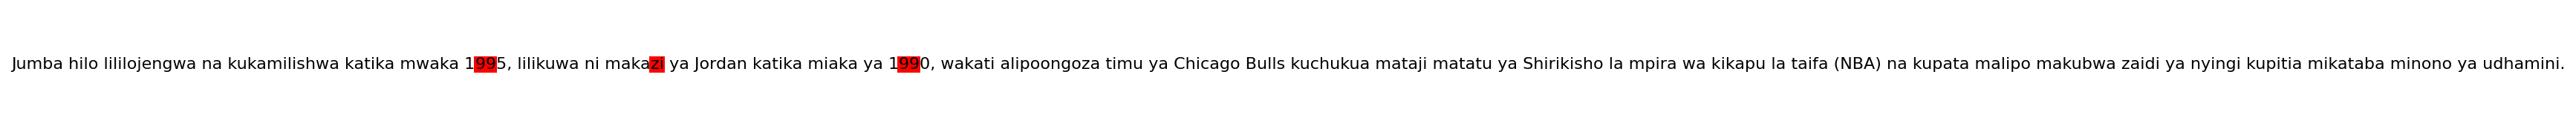

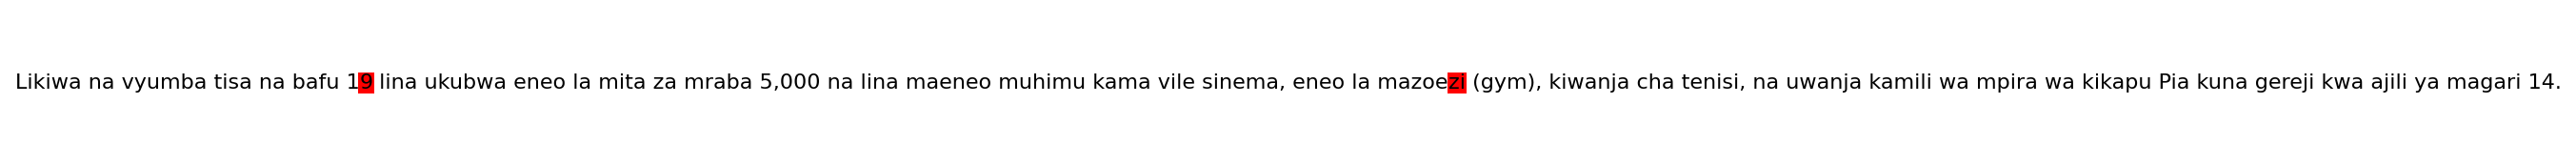

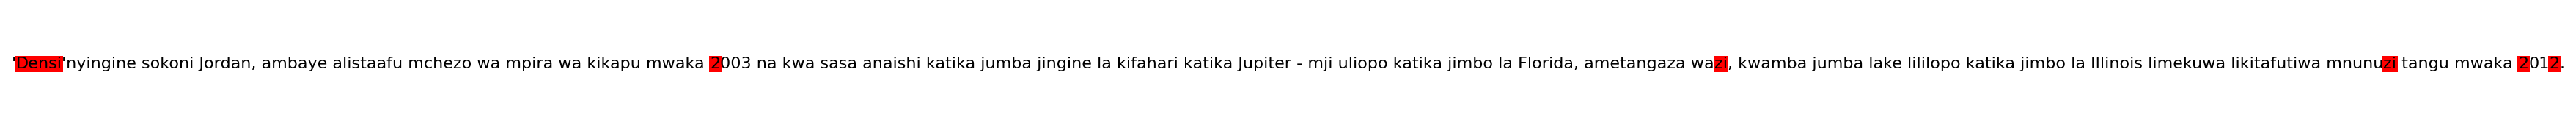

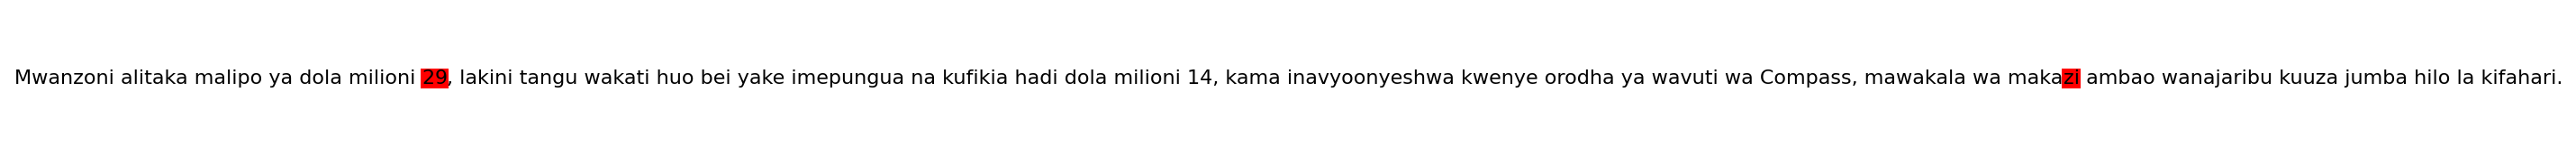

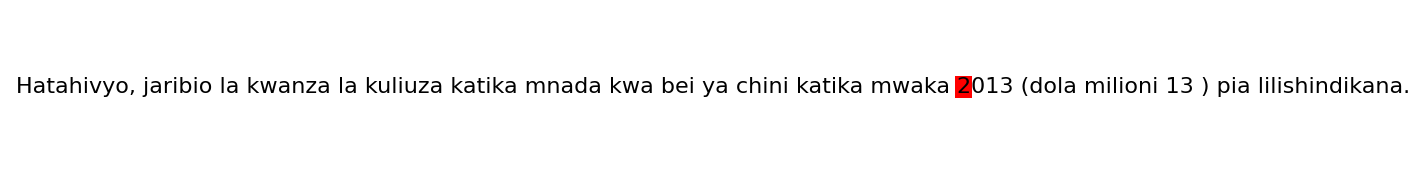

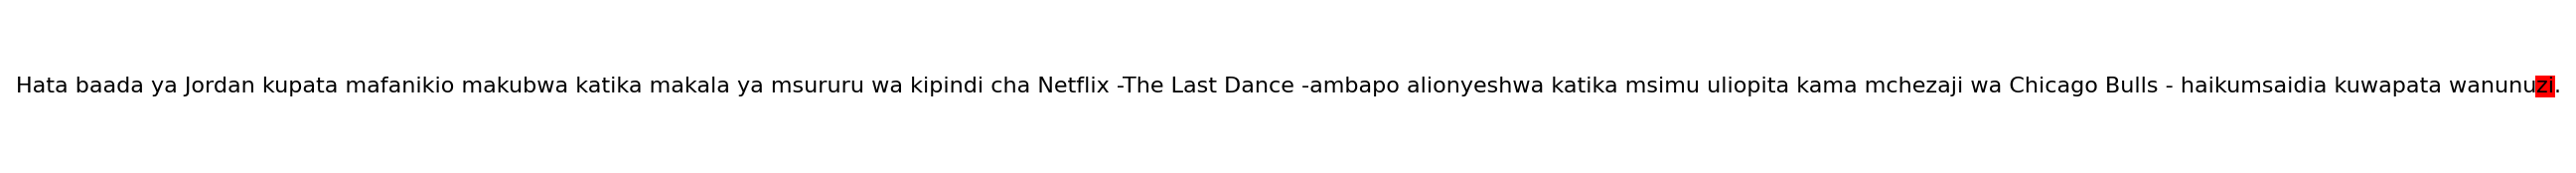

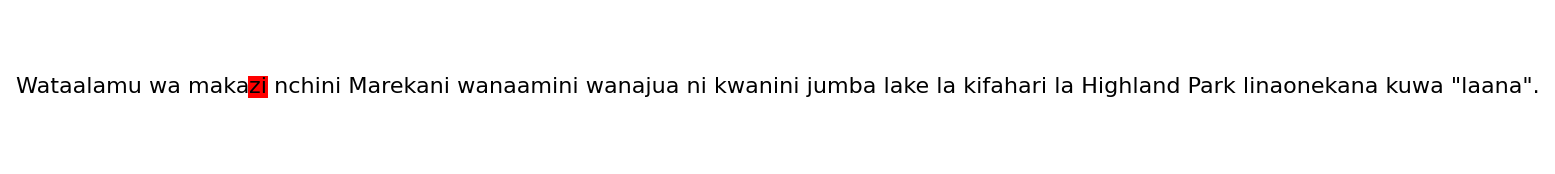

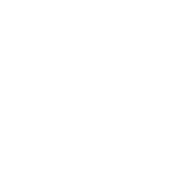

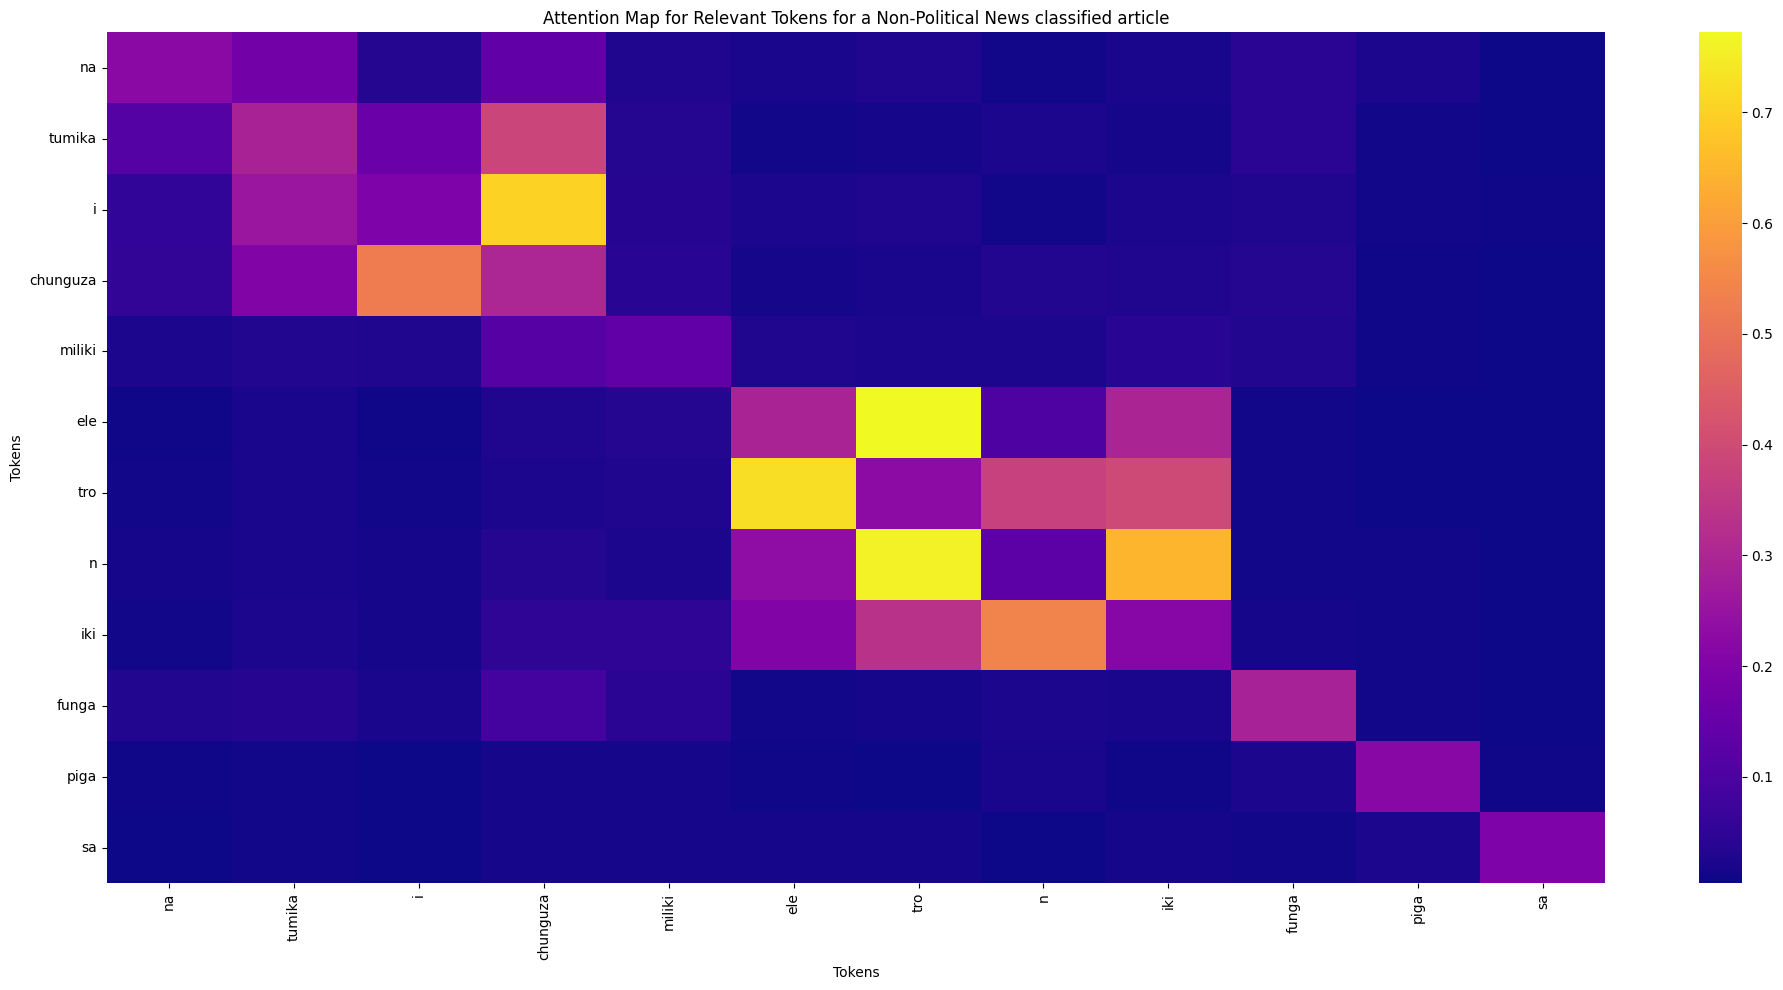

<s> Elon Musk akana magari yake yalitumika kuichunguza China Mmiliki wa magari ya kieletroniki ya Tesla, Elon Musk amesema atafunga kampuni hiyo iwapo gari zake zilitumika kuichunguza China. Hii ni baada ya jeshi la China kuyapiga marufuku magari ya Tesla kwa madai kwamba gari hizo zilikuwa na camera zilizokuwa zikinasa data.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

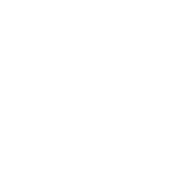

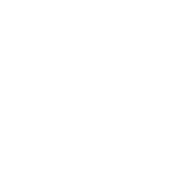

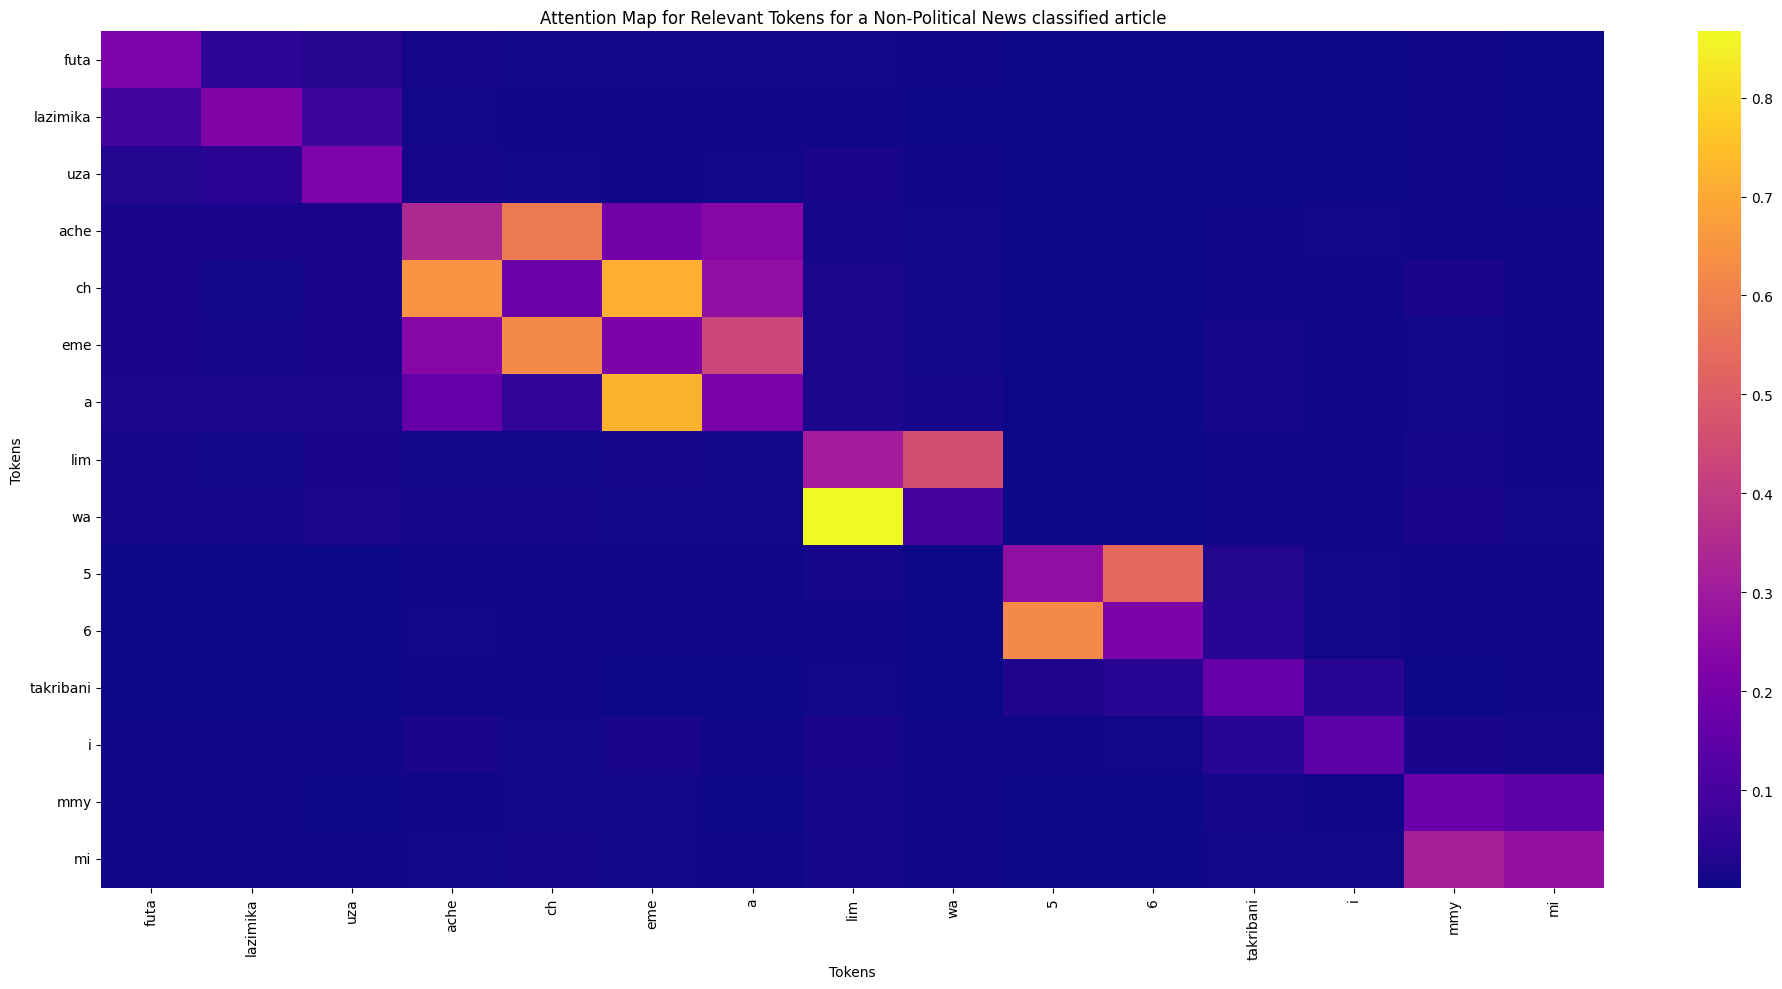

<s> Wakulima wa ufuta wamelazimika kuuza ufuta karibu kwa nusu ya bei waliouza msimu uliopita Shughuli za kiuchumi zinaendelea kama kawaida nchini Tanzania. Lakini kwa biashara ya mazao ya kilimo ambayo inategemea mazao ya nje, yenyewe bado inachechemea. Na hii ni zaidi kwa mazao kama ufuta vile, ambao unalimwa zaidi Kusini mwa Tanzania. Kutokana na kufungwa mipaka na masoko ya kimataifa, wakulima wa ufuta kusini mwa Tanzania sasa wanalazimika kuuza kilo moja ya ufuta kwa kama Dola senti 56 tu - takribani nusu ya bei waliyoiuza msimu uliopita ambayo ilikuwa zaidi ya Dola moja. Mwandishi wetu Sammy Awami alikwenda Lindi, Kusini mwa Tanzania kujionea hali ilivyo.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

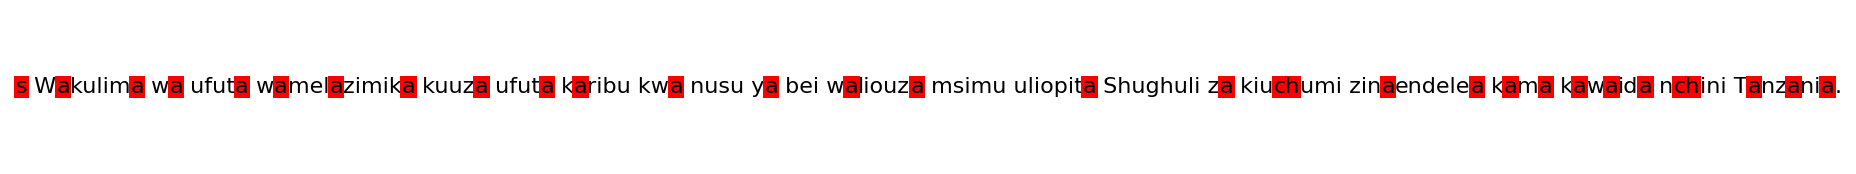

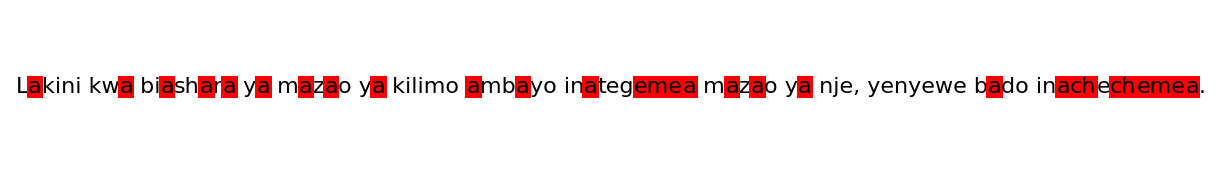

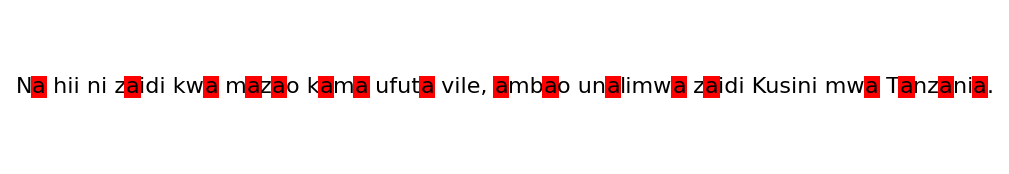

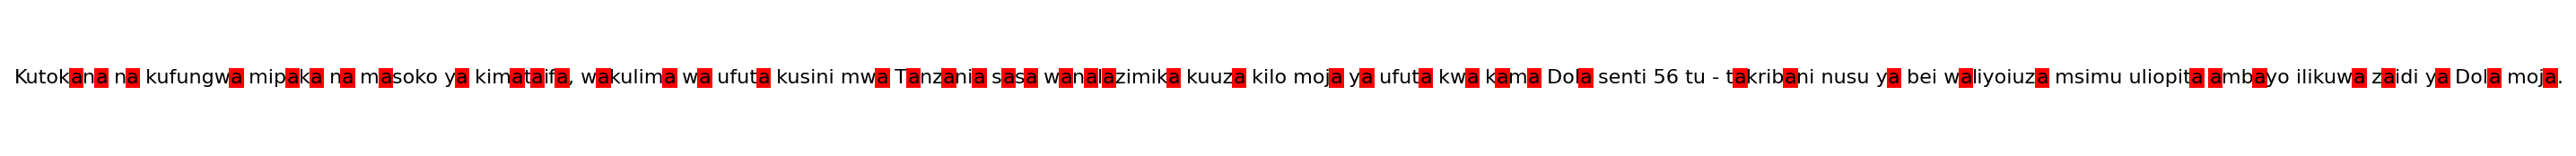

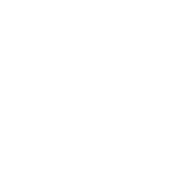

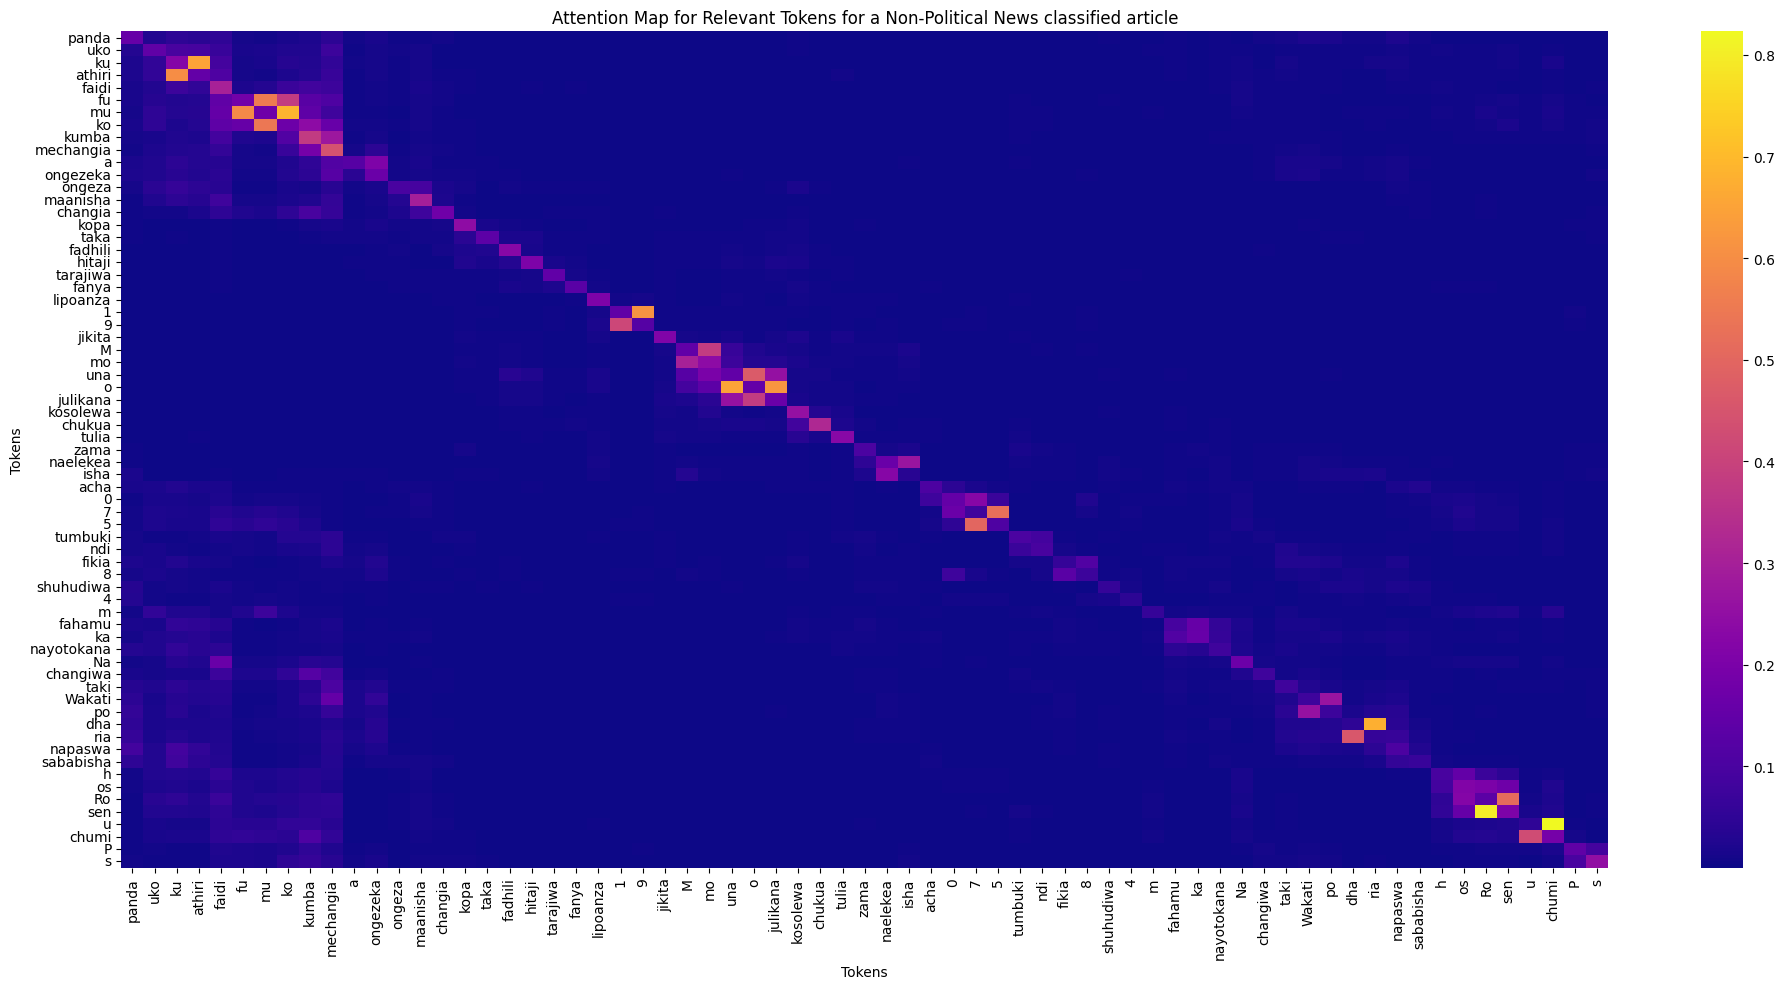

<s> Kupanda kwa viwango vya riba: Jinsi mfumuko wa bei duniani unavyokuathiri, ni nani anayefaidi? Mfumuko wa bei unaokumba ulimwengu umechangia kupanda kwa viwango vya riba ambavyo vimekuwa vikiongezeka kwa kasi. Katika juhudi ya kudhibiti ongezeko hilo la mfumko wa bei za bidhaa, nchi katika maeneo tofauti duniani zimeongeza gharama ya pesa, hii ikimaanisha ongezeko la gharama ya mkopo. Hali hiyo imechangia viwango vya juu sana vya riba, hivyo basi hakuna faida ya mtu yeyote kukopa. Hali hii imeathiri zaidi makampuni zinazotaka kukopa fedha za kuwekeza, serikali zinazotaka kufadhili matumizi ya umma, na pia huathiri watu wanaohitaji mikopo ya kununua nyumba, gari au kufadhili gharama zisizotarajiwa. Ni nani anayefanya maamuzi ya kupanda au kushuka kwa viwango vya riba? Benki kuu ya kila nchi inafanya kazi bila kutegemea serikali iliyopo madarakani. Tangu mfumko wa bei ulipoanza kupanda kwa kasi, kwanza kufuatia athari za janga la covid-19 na kisha kufuatia vita vya Ukraine, mjadala u

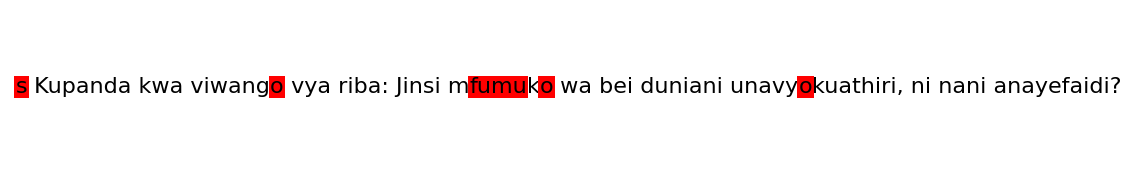

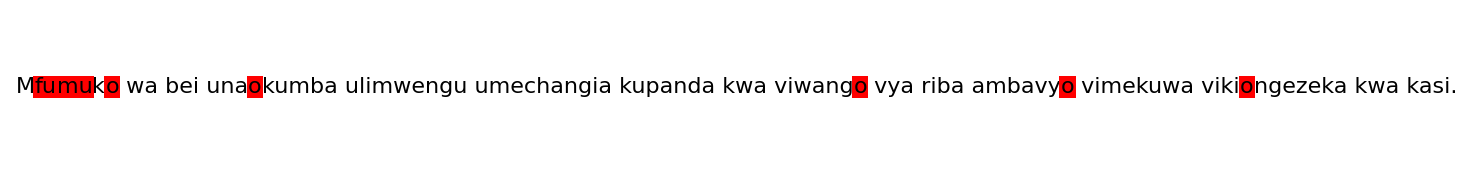

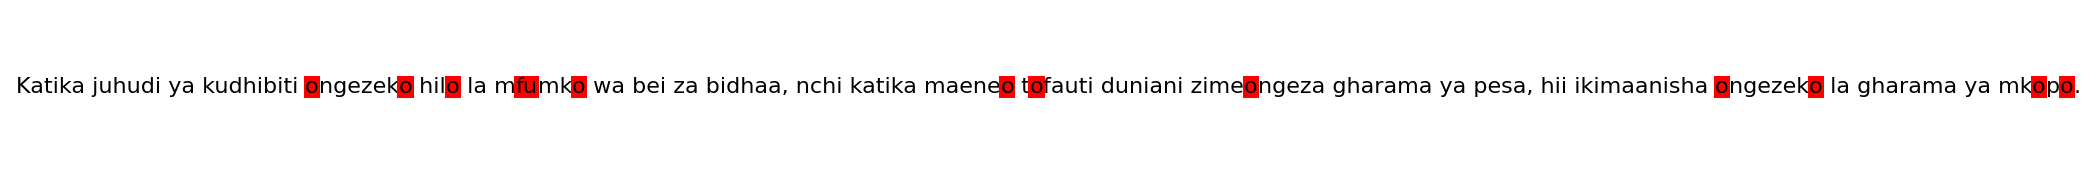

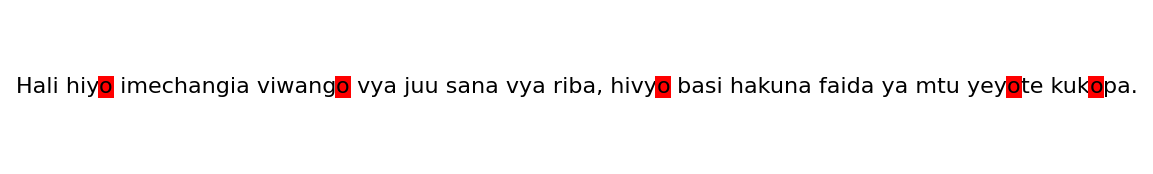

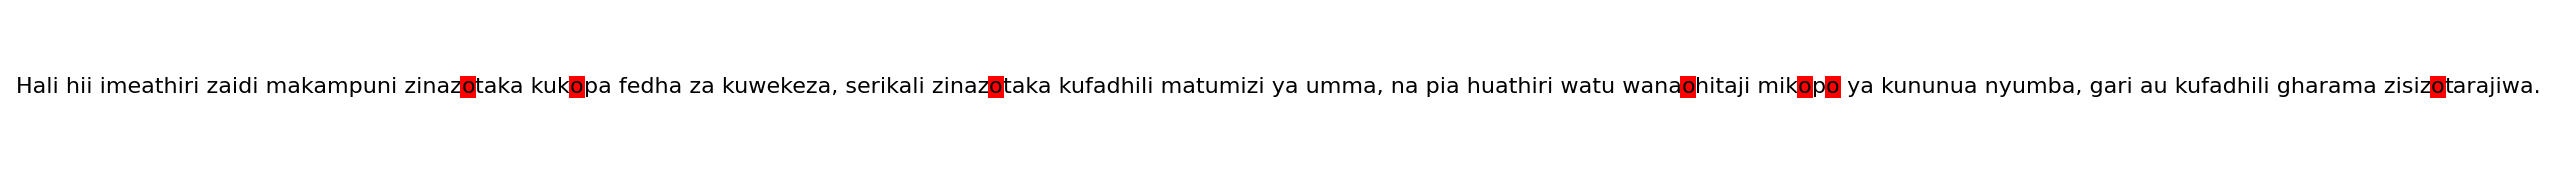

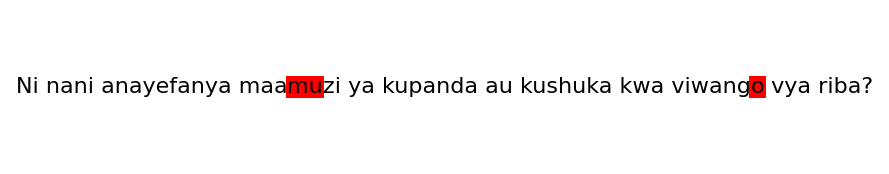

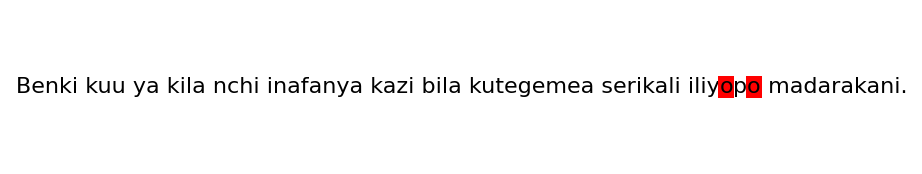

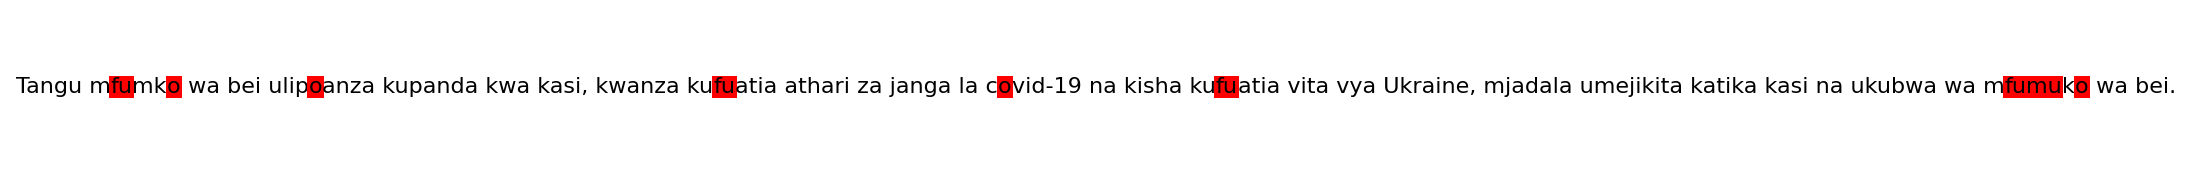

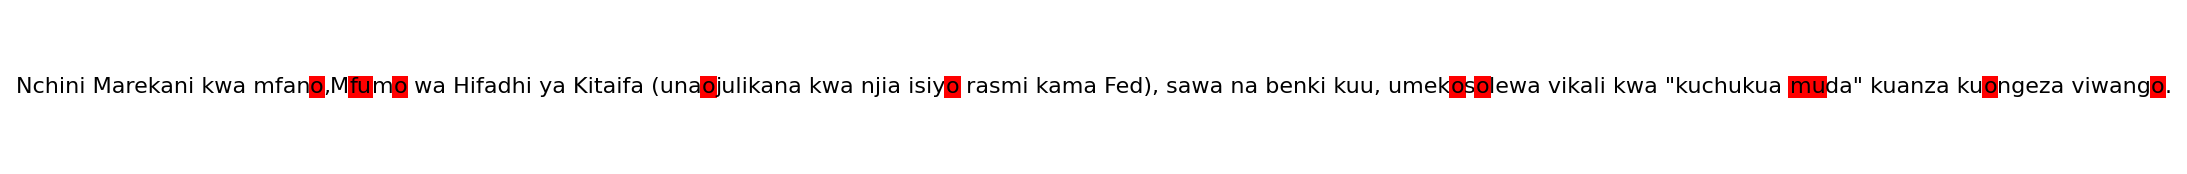

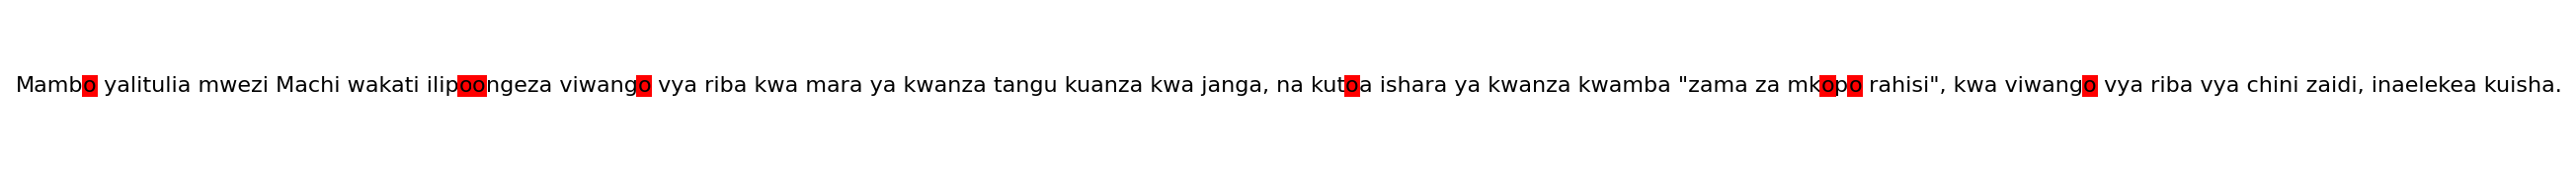

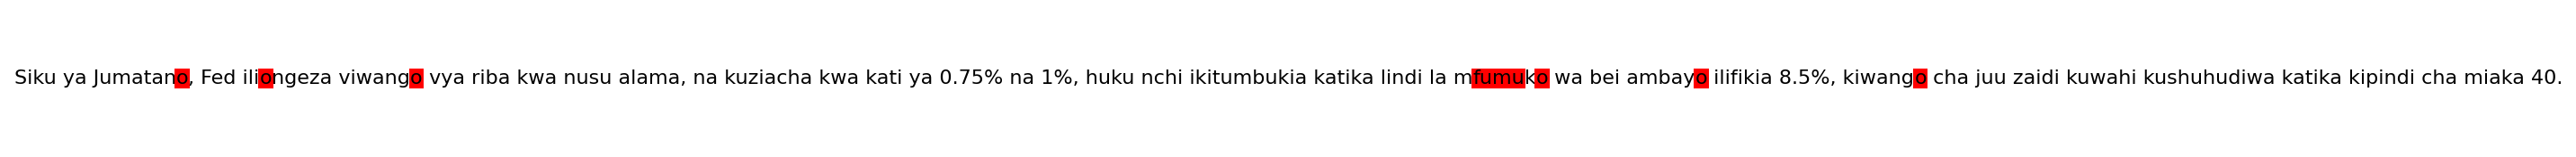

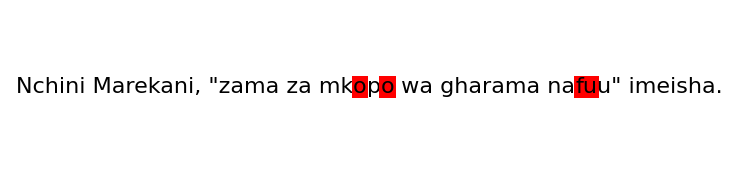

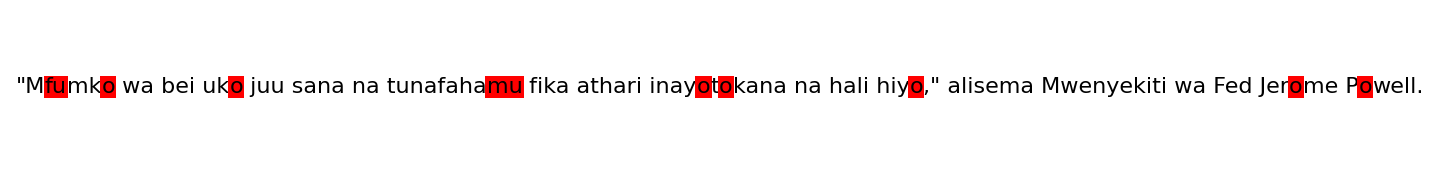

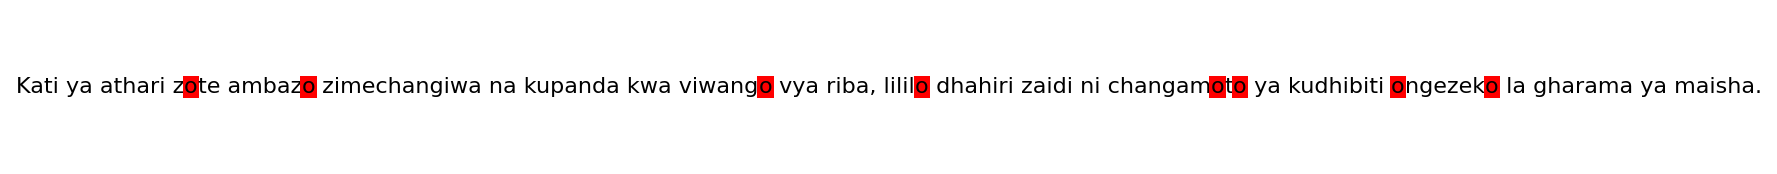

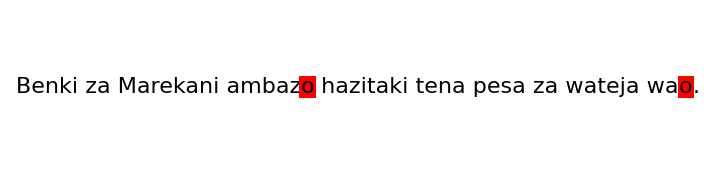

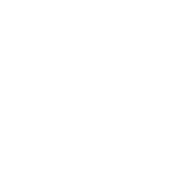

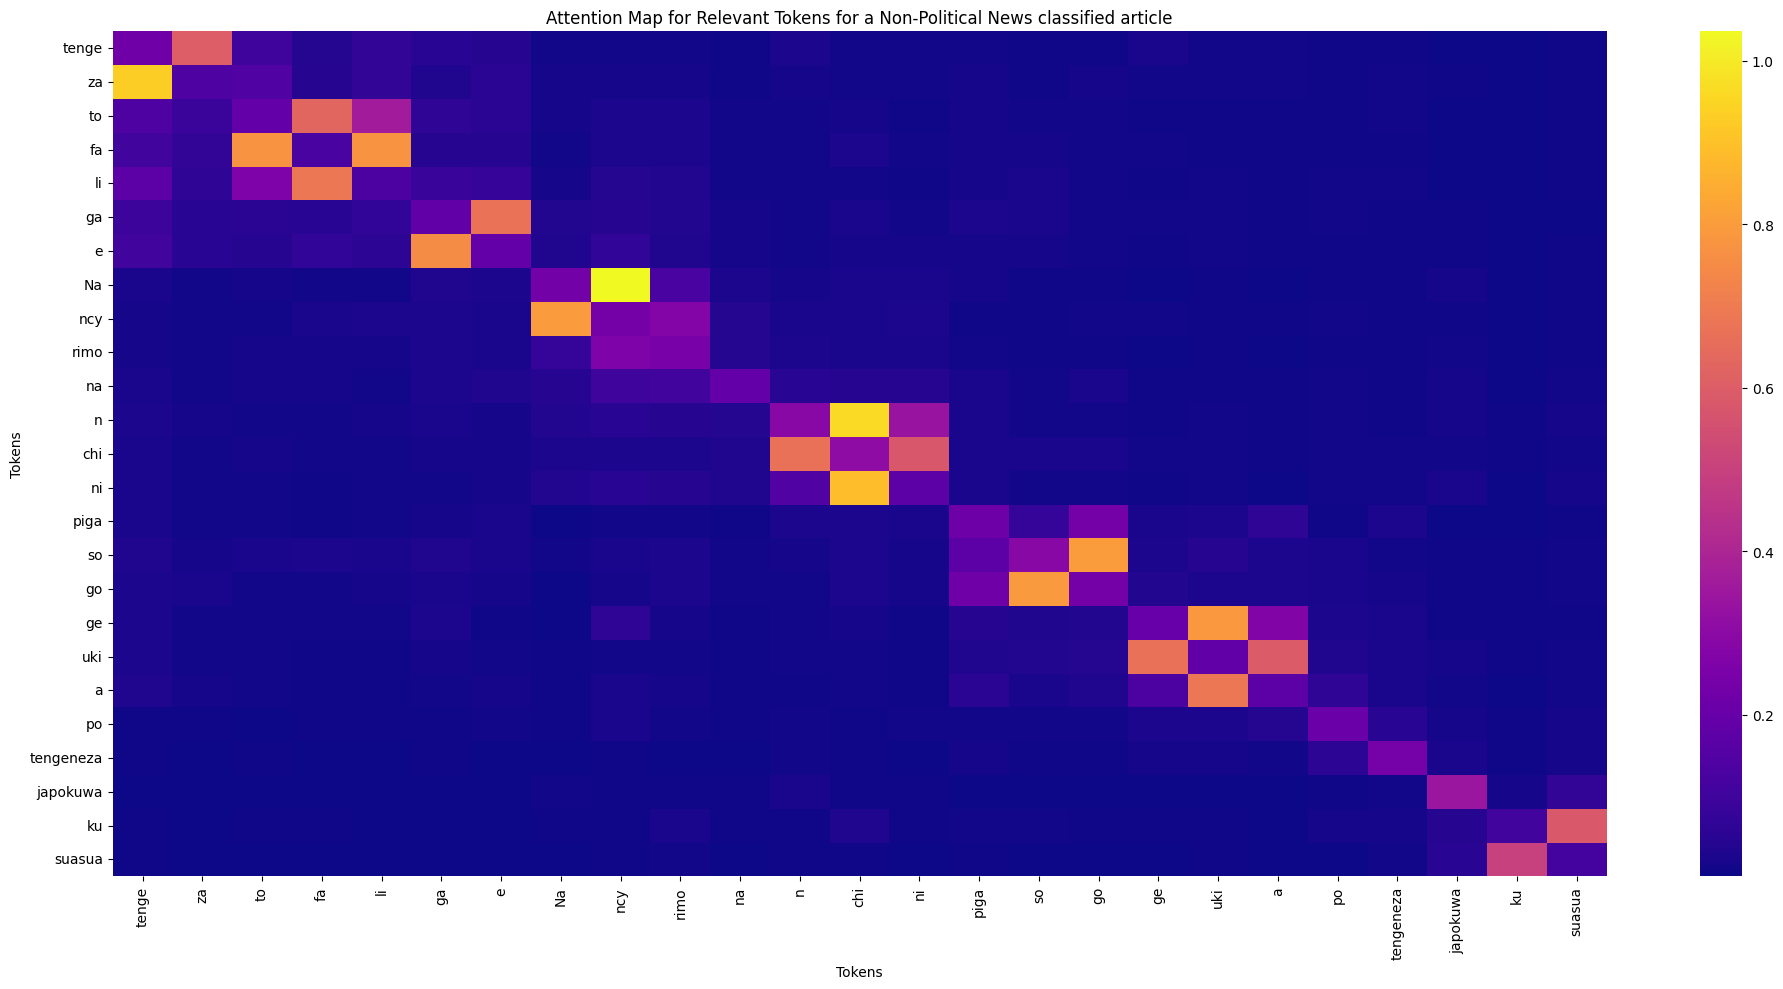

<s> Mifuko ya plastiki inavyotengeza matofali na vigae Wasichana wawili (Nancy Tarimo na Grace Meena )nchini Tanzania ambao kitaaluma ni walimu wamepiga kisogo taaluma hiyo na kugeukia ujasiriamali Ambapo kwa sasa wanatengeneza matofali na vigae kwa kumia mifuko ya plastiki na mchanga lengo ikiwa ni kuweka mazingira safi lakini pia kutengeneza kipato ijapokuwa bado uzalishaji wao ni wakusuasua kutokana na kutumia vifaa duni.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

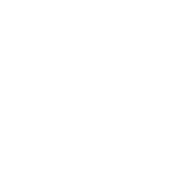

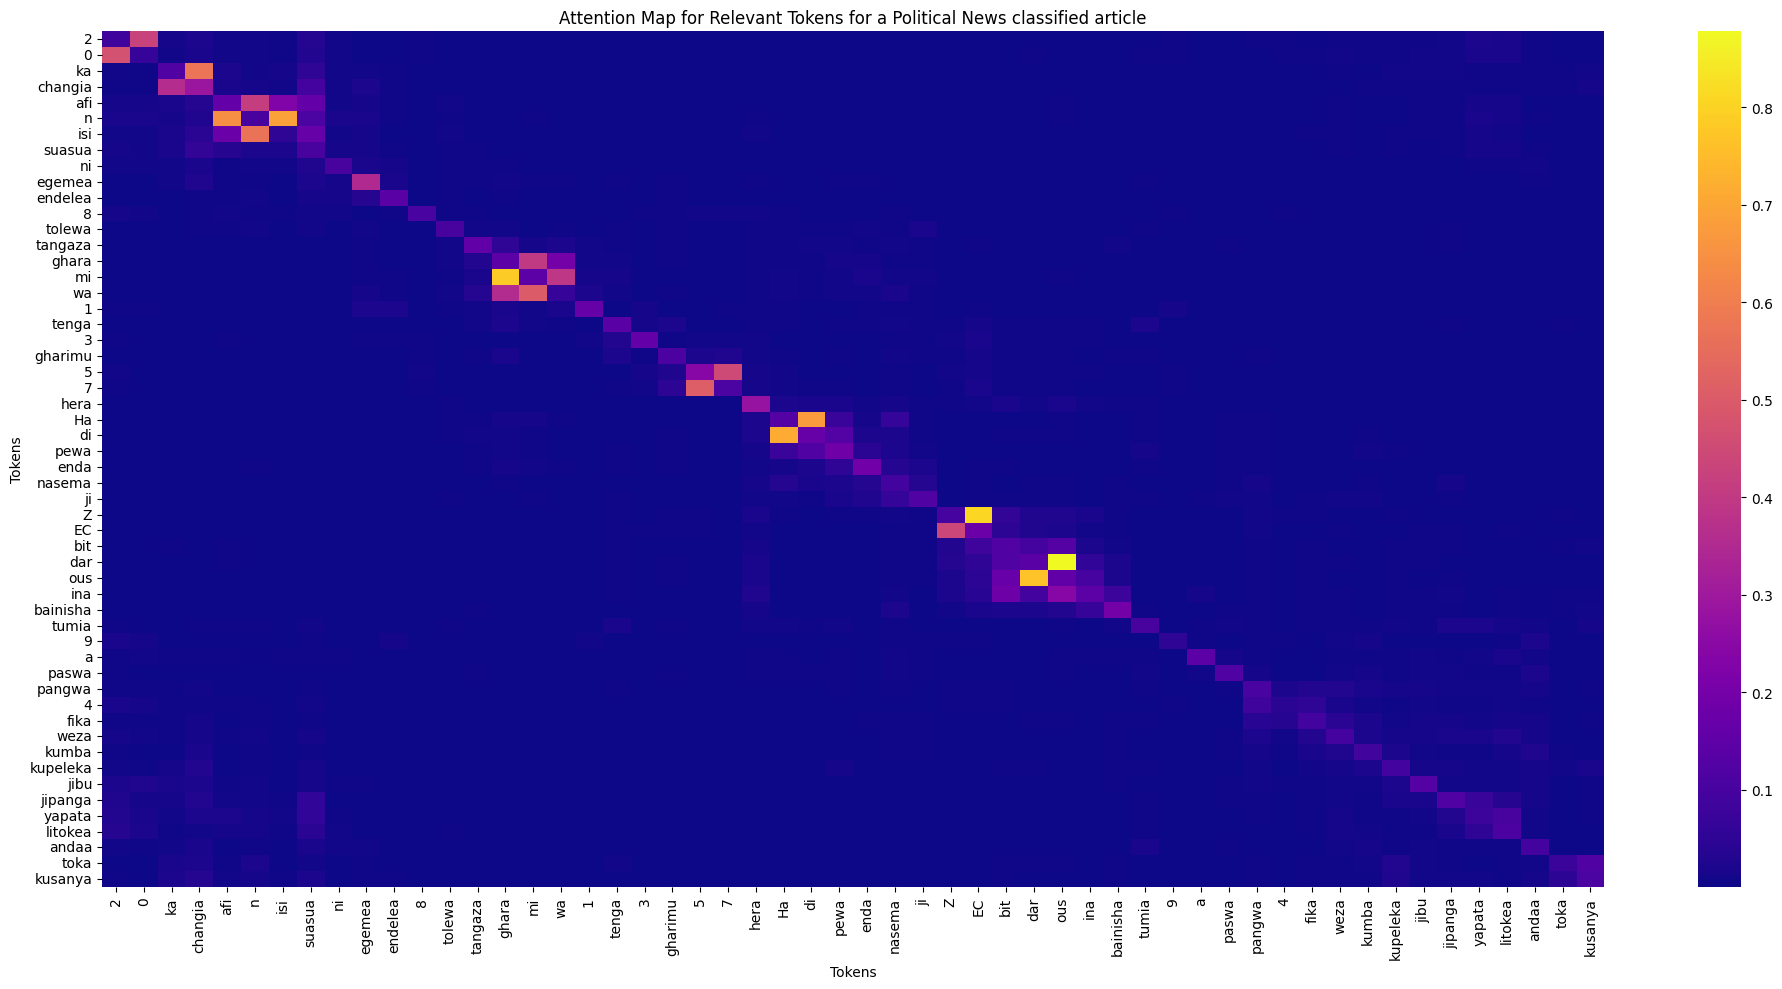

<s> Uchaguzi Tanzania 2020: Kwa mara ya kwanza Tanzania itafanya uchaguzi bila kutegemea msaada wa nje Bajeti ya uchaguzi ni moja kati ya masuala ya msingi zaidi ambayo huenda yakachangia shughuli za uchaguzi kwenda kwa uafinisi ama kusuasua. Katika uchaguzi wa nchi nyingi zinazoendelea hasa Barani Afrika, fedha za kuendesha shughuli nzima ya uchaguzi huegemea zaidi michango na misaada kutoka nchi zilizoendelea ama mashirika makubwa duniani kama benki ya dunia na mashirika ya kimataifa. Na kiasi kingine cha fedha hutolewa na serikali ya nchi husika. Tanzania inatarajia kufanya uchaguzi mkuu mwishoni mwa mwezi huu Oktoba 28. Na tofauti na miaka iliyopita, bajeti ya uchaguzi ya mwaka huu inatolewa yote na serikali ya Tanzania. Bila kusubiri msaada wa mashirika wa nchi za nje, Tanzania ilitangaza kuwa uchaguzi utagharamiwa na serikali ya nchi hiyo kwa asilimia 100. Kwa mujibu wa tume ya taifa ya uchaguzi NEC Serikali ya Tanzania imetenga kiasi cha shilingi za kitanzania Bilioni 331 wakati

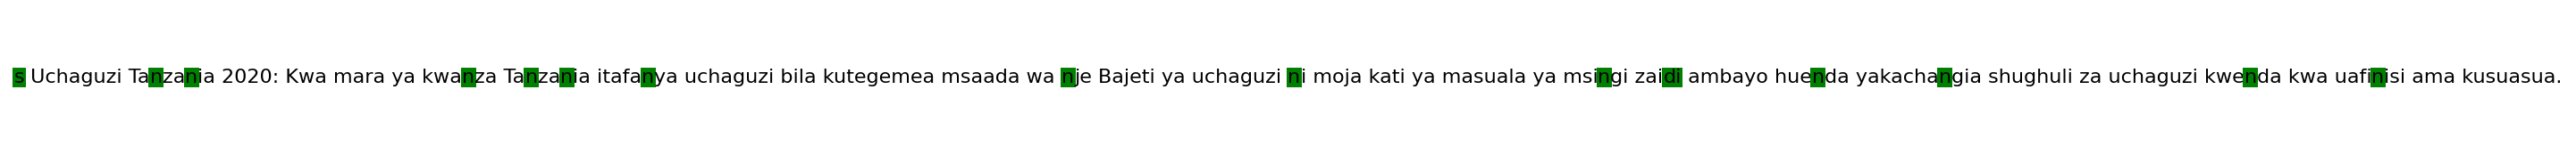

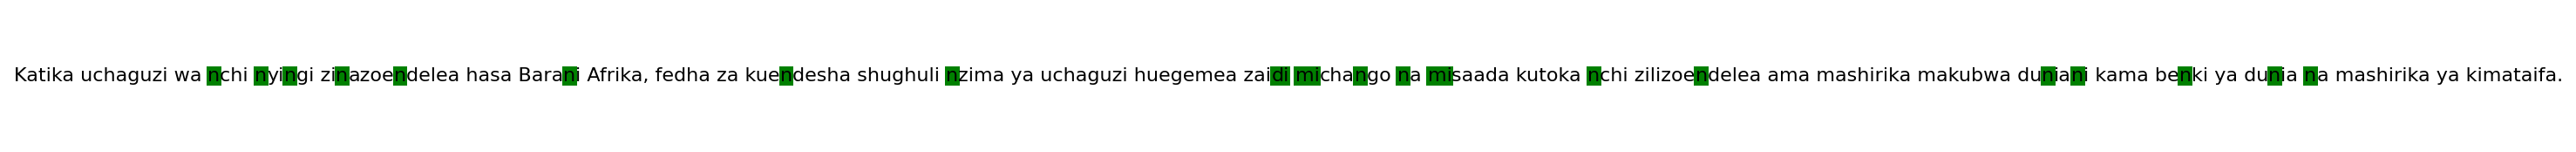

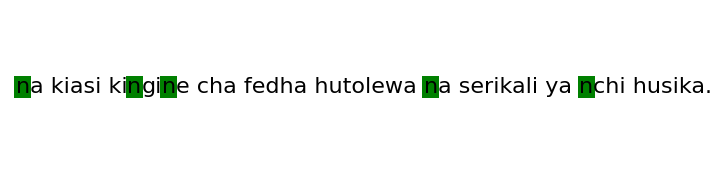

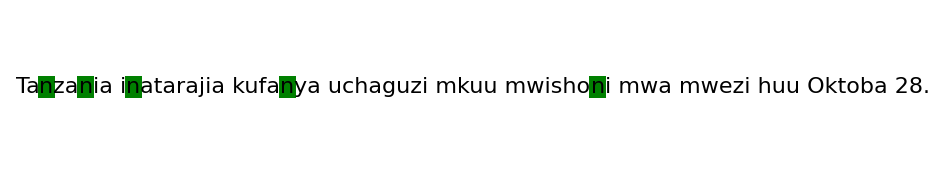

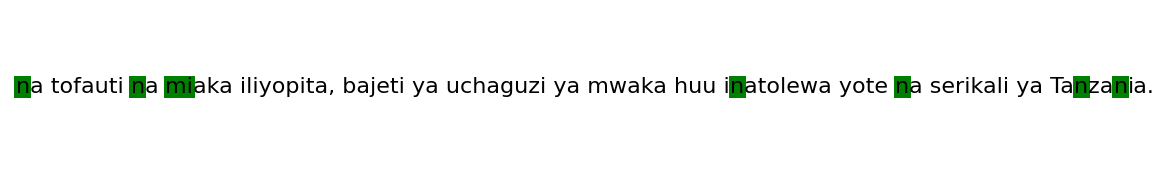

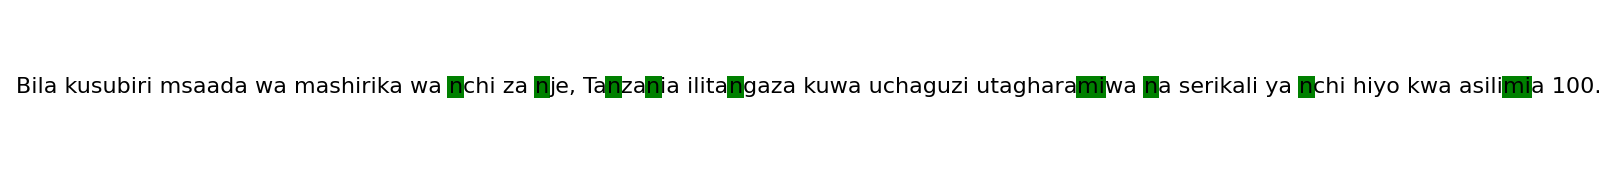

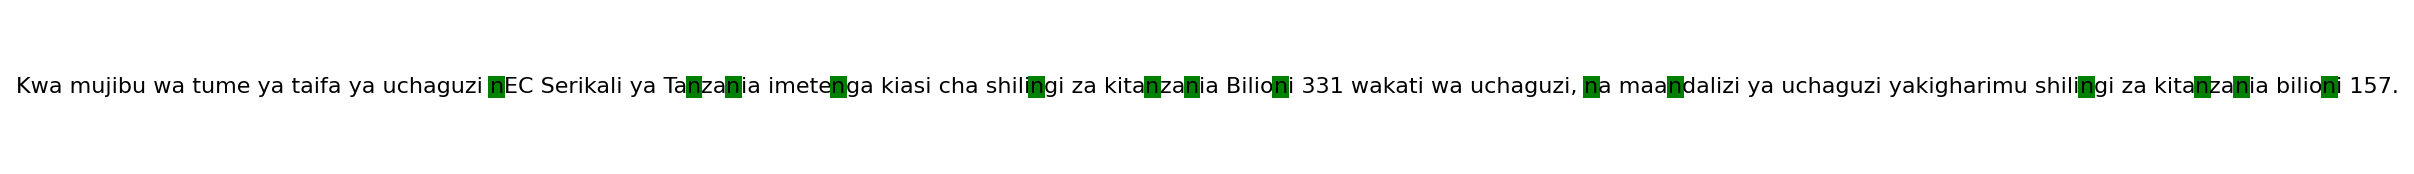

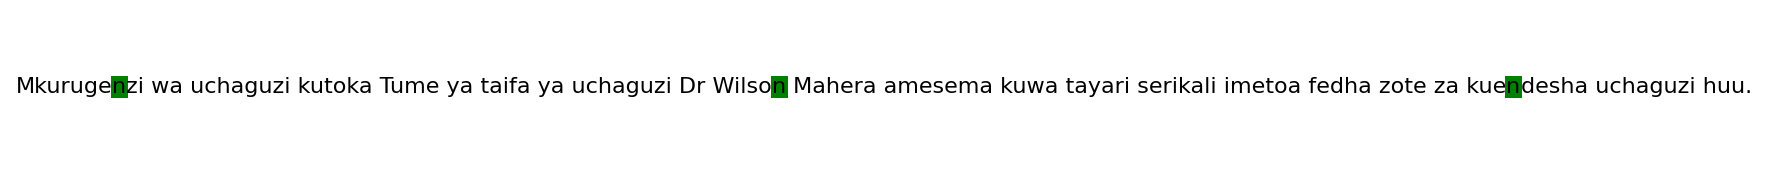

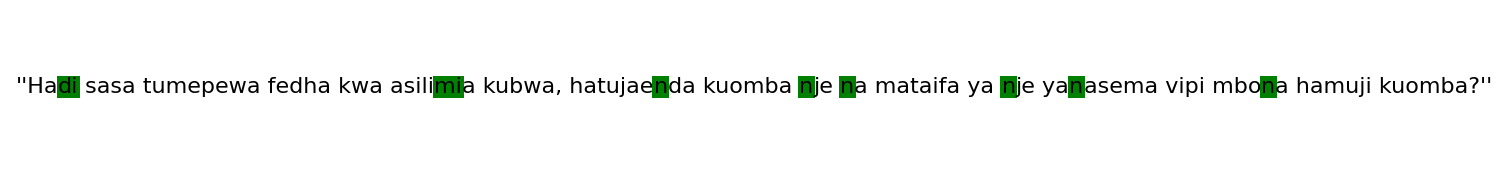

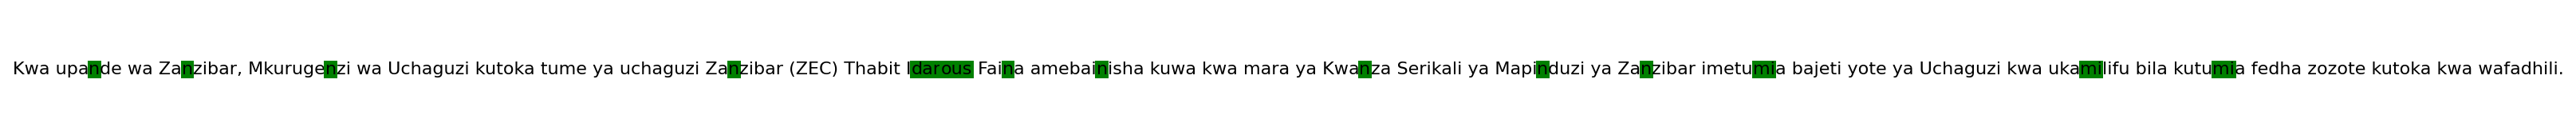

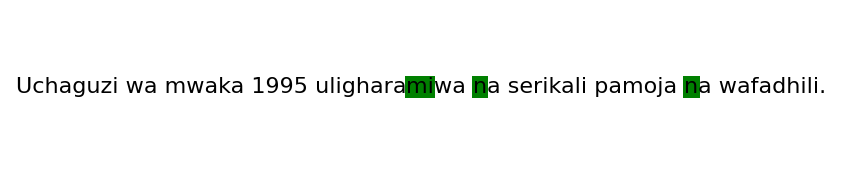

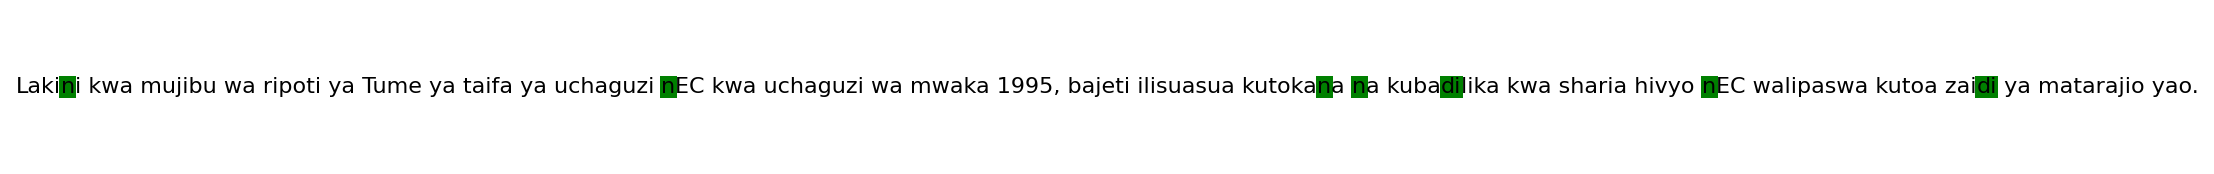

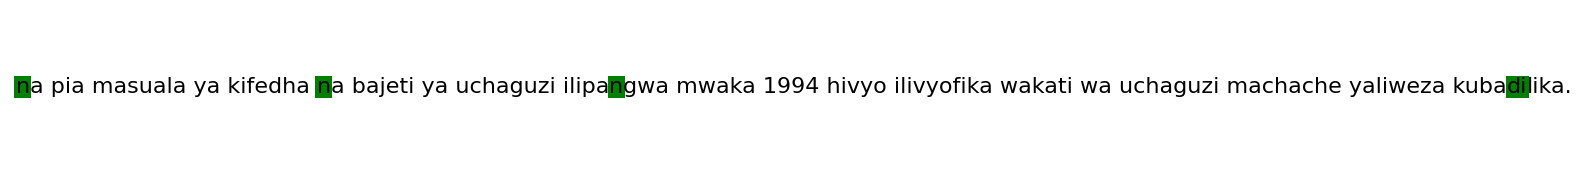

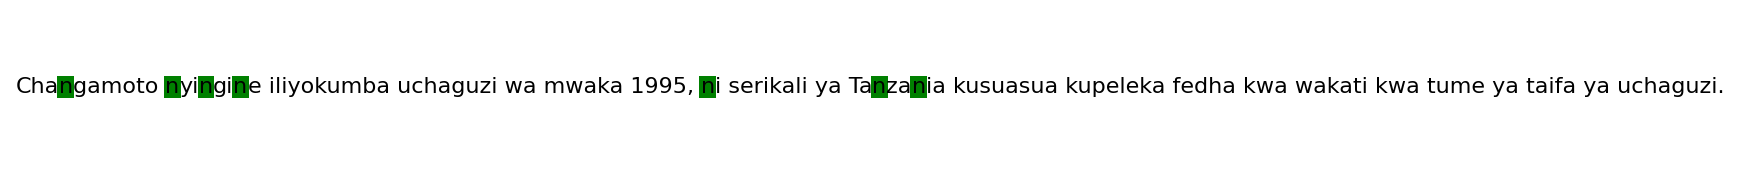

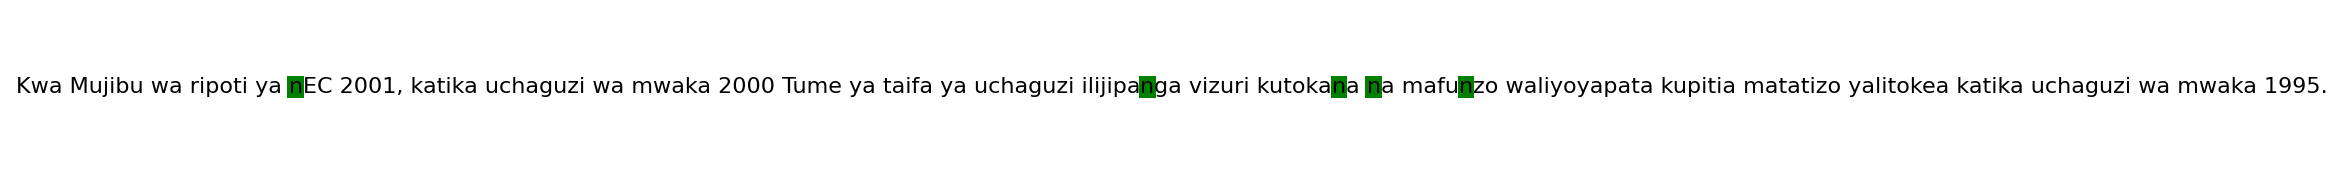

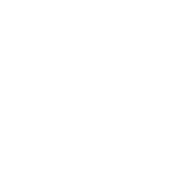

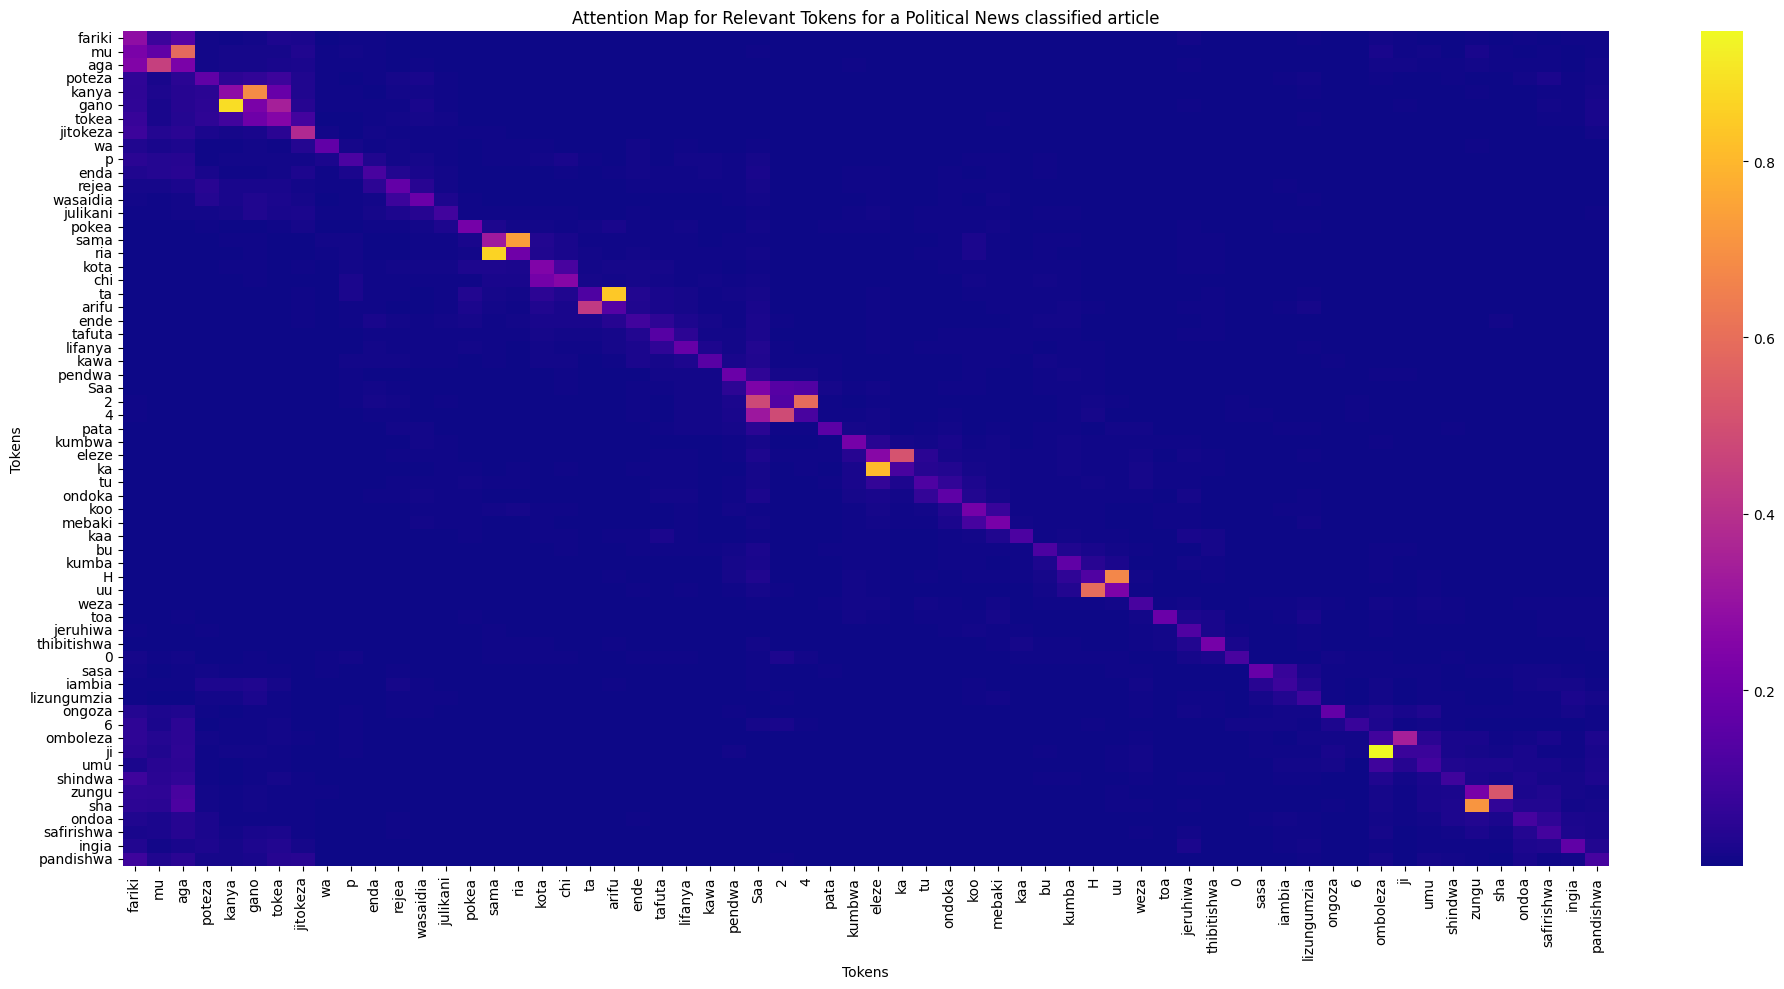

<s> Kifo cha Magufuli: Watu watano wa familia moja wafariki wakimuaga Rais Magufuli Familia moja jijini Dar Es Salaam imepoteza watu watano katika mkanyagano uliotokea wakati maelfu ya wakaazi wa jiji hilo walipojitokeza kuuaga mwili wa Rais John Magufuli. Dennis Mtuwa amepoteza mke wake, watoto wawili, na wapwa zake wawili. Walienda kumuaga aliyekuwa Rais wao jana Jumapili katika Uwanja wa Uhuru, lakini hawakurejea tena nyumbani. Msichana wa kazi anayewasaidia kwa shughuli za nyumbani mpaka sasa hajulikani alipo. Bwana Mtuwa alipokea simu kutoka kwa msamaria mwema mmoja ambaye aliokota pochi ya mke wake na kumtaarifu kuwa inafaa aende uwanjani ama polisi kumtafuta. Alifanya hivyo kwa haraka na maumivu yake yakawa makubwa zaidi baada ya kuona miili ya wapendwa wake. "Saa 24 zilizopita zimekuwa ngumu sana kwangu, napata faraja nikiwa nipo na watu, ila nikiwa peke yangu nakumbwa na huzuni ambayo haiwezi kuelezeka...watu watano wa familia yangu wameondoka, ni msiba wa ukoo, nimebaki na mt

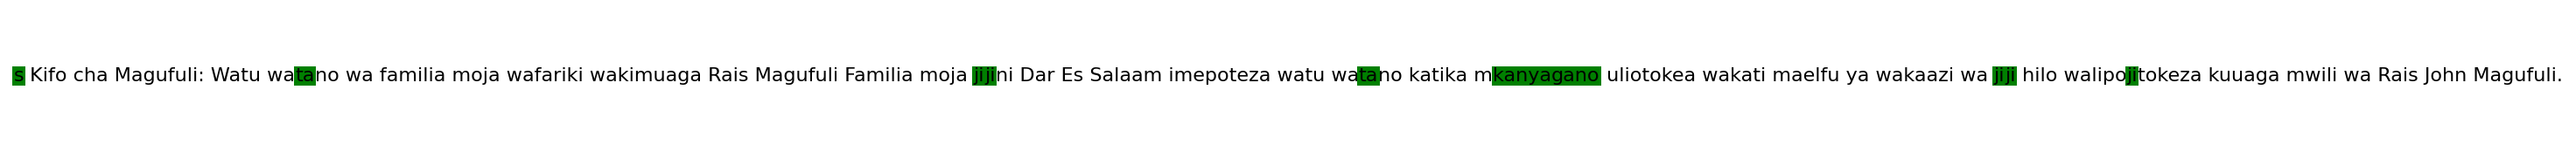

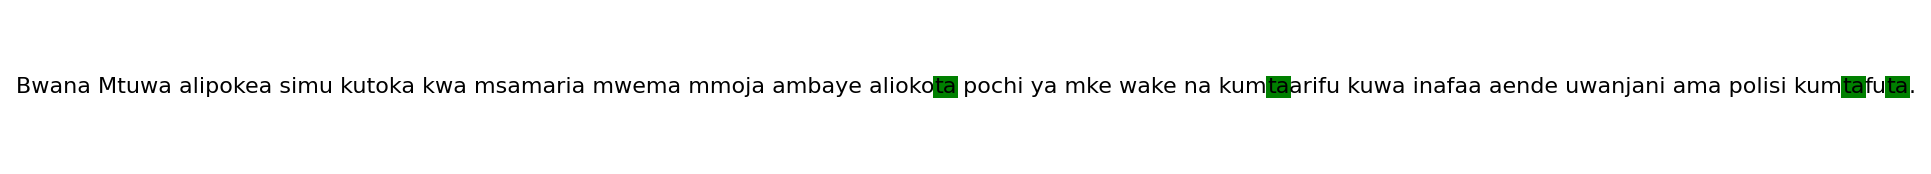

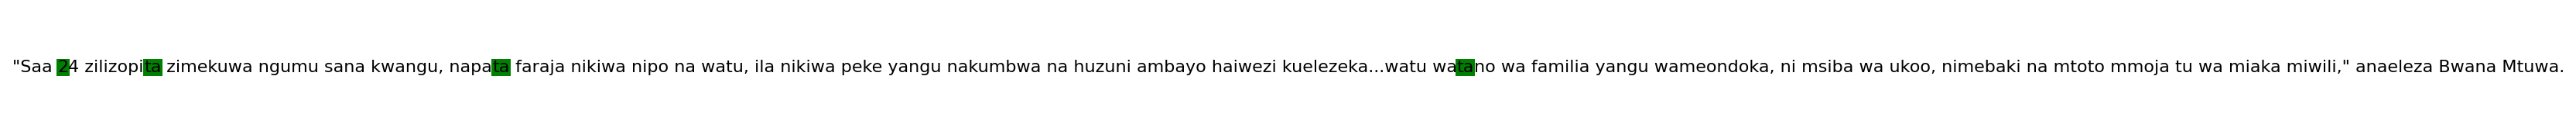

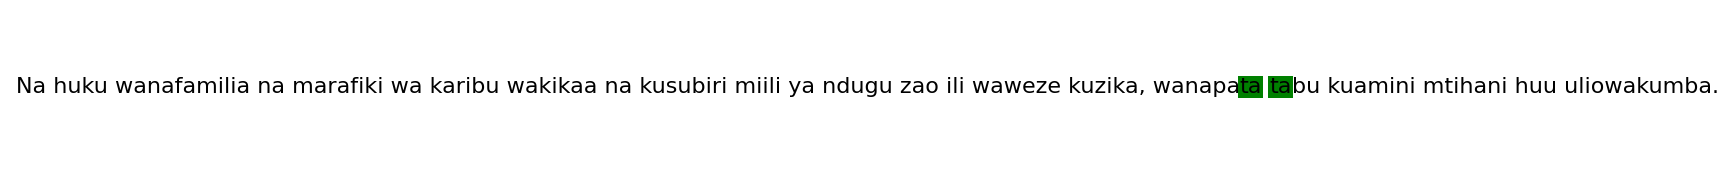

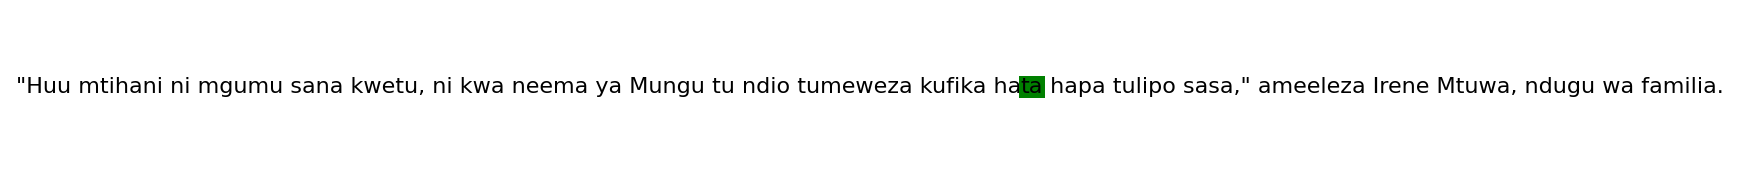

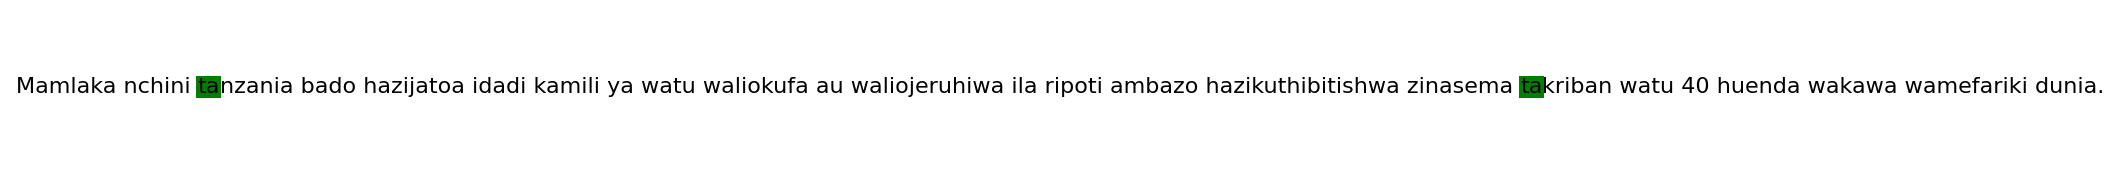

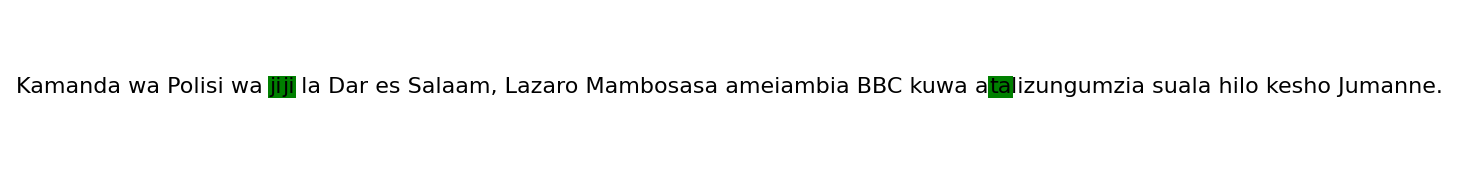

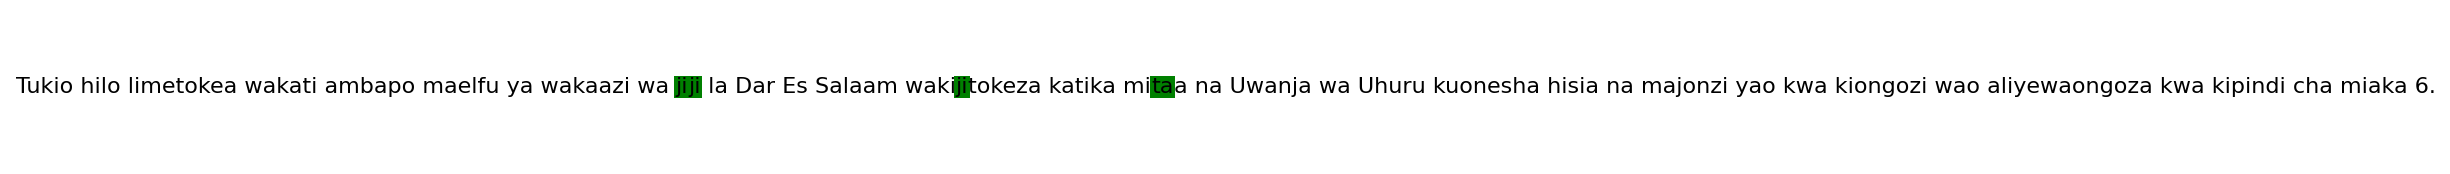

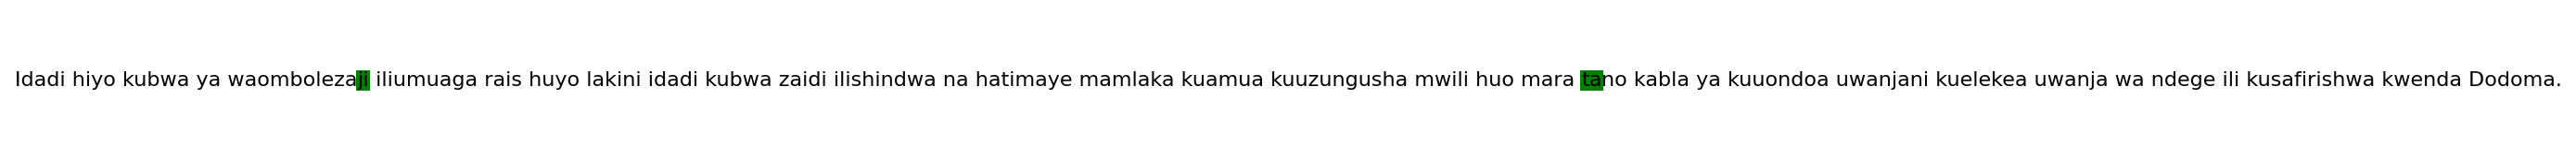

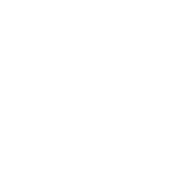

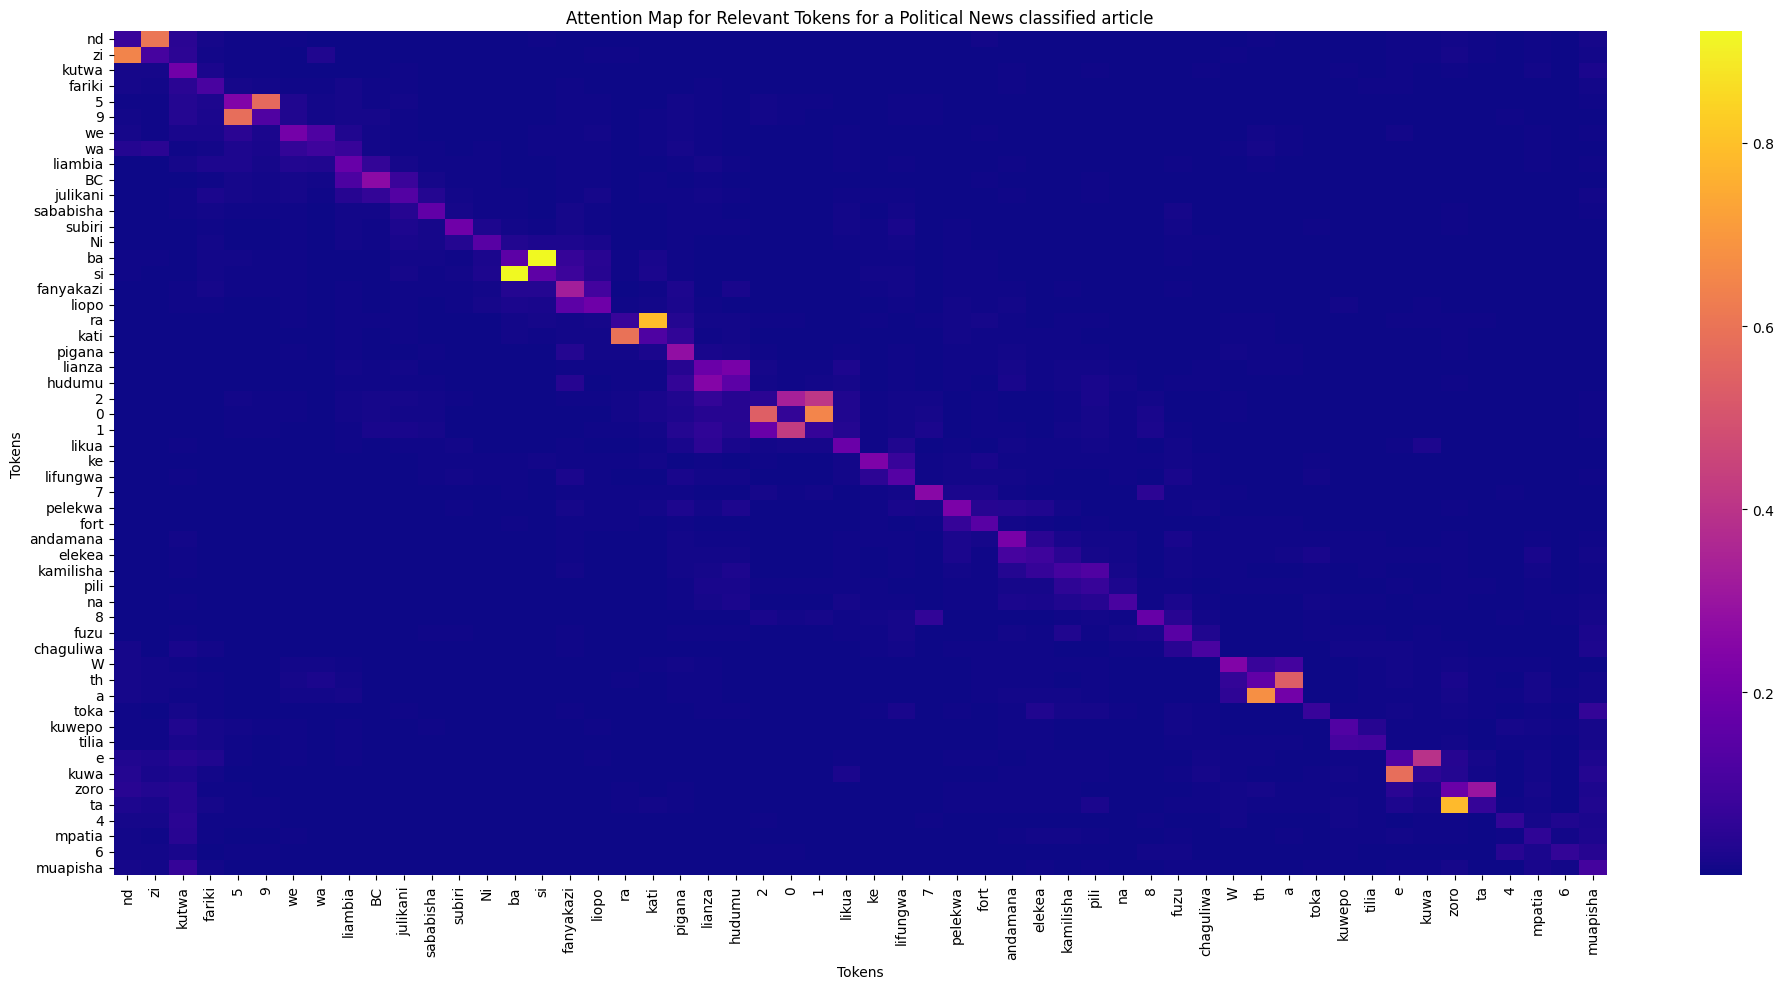

<s> Mwana wa Mandela, marehemu Zindzi Mandela alikutwa na virusi vya corona Zindzi Mandela, mwana mdogo wa kike wa aliyekuwa rais wa Afrika Kusini Nelson Mandela na mwanaharakati wa kupigana dhidi ya ubaguzi wa rangi, Winnie Madikizela Mandela alikutwa na virusi vya corona. Alifariki katika hospitali ya mjini Johannesburg mapema siku ya Jumatatu akiwa na umri wa miaka 59. Mwanawe Zondwa Mandela aliambia chombo cha habari cha Afrika Kusini SABC kwamba haijulikani iwapo ni ugonjwa huo uliosababisha kifo chake. Familia inasubiri ripoti ya uchunguzi. ''Ni kweli kwamba alikutwa na virusi vya corona hivyobasi ni vyema kufanyakazi chini ya masharti yaliopo ya kukabiliana na maradhi hayo'', alisema Zondwa Mandela. Mwanamke huyo alikuwa mwanarakati wa kisiasa na ni miongoni mwa wale waliopigana dhidi ya uongozi wa ubaguzi wa rangi nchini humo. Alianza kuhudumu kama balozi wa Denmark mwaka 2015. Alikua mwana wa sita wa Nelson Mandela na wa pili kati yake na Winnie Madikizela Mandela. Wakati alip

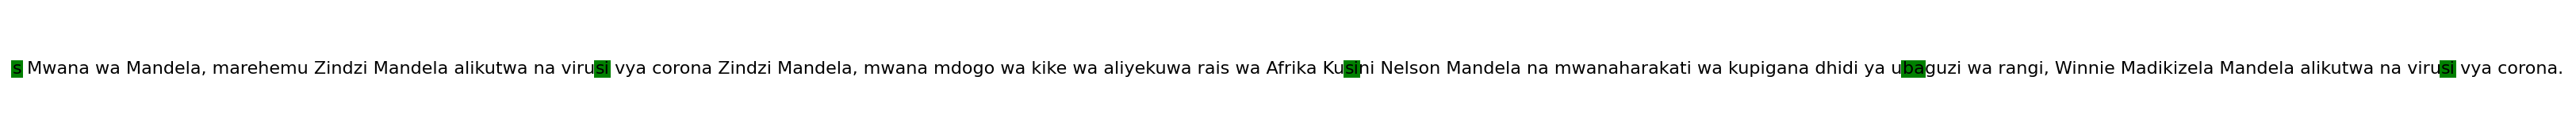

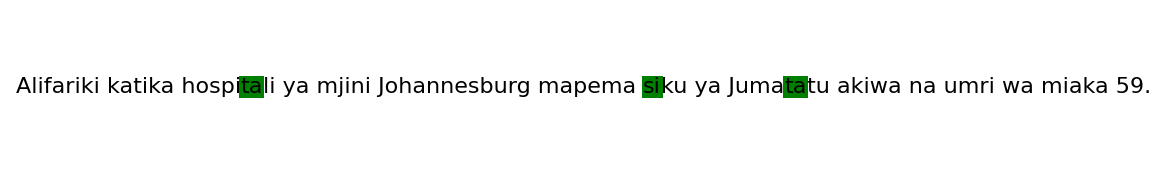

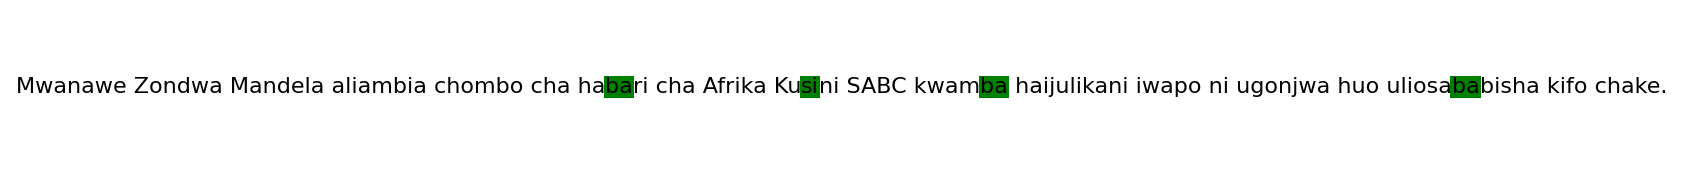

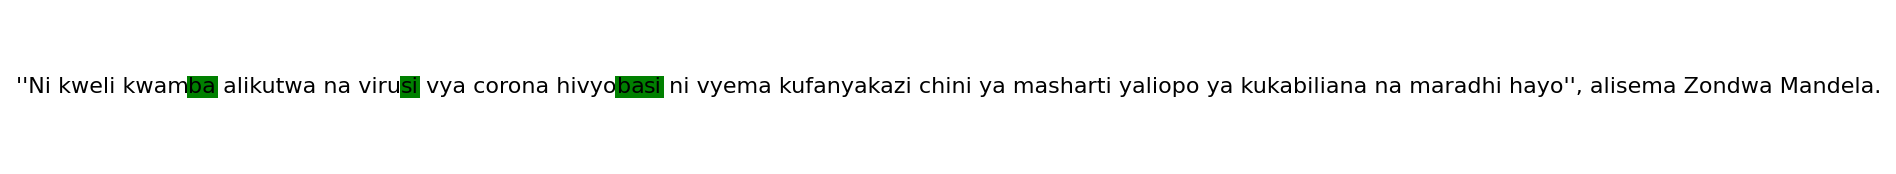

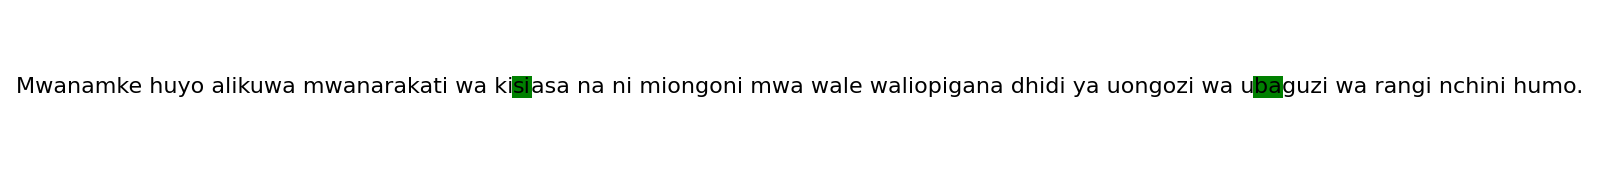

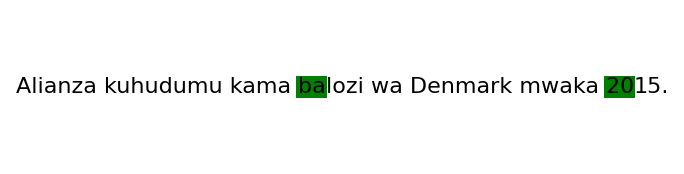

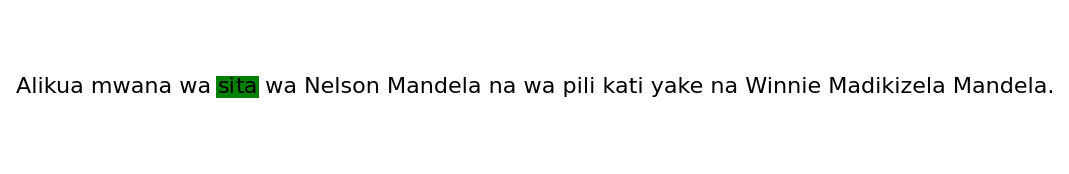

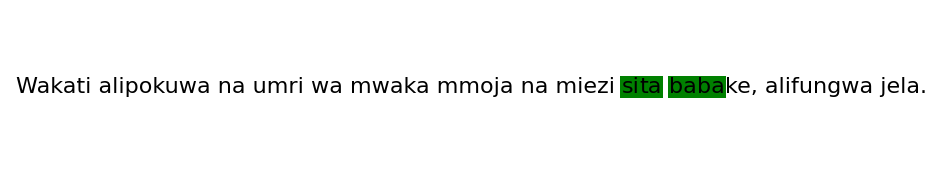

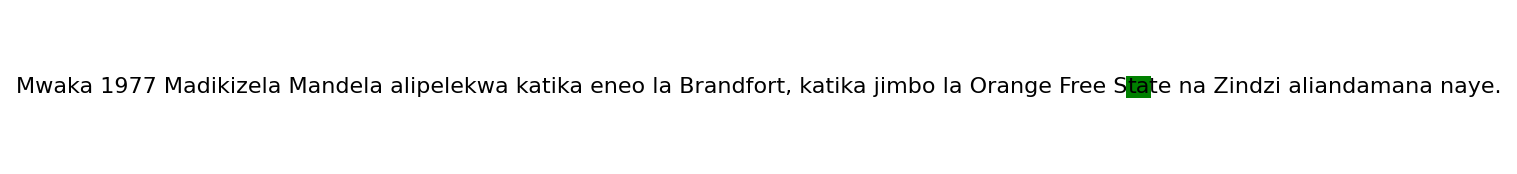

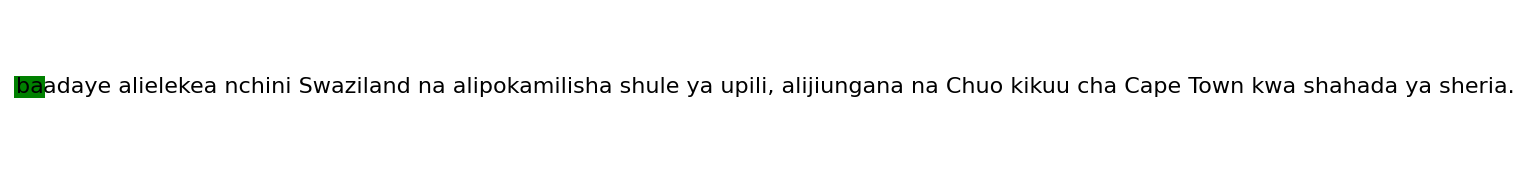

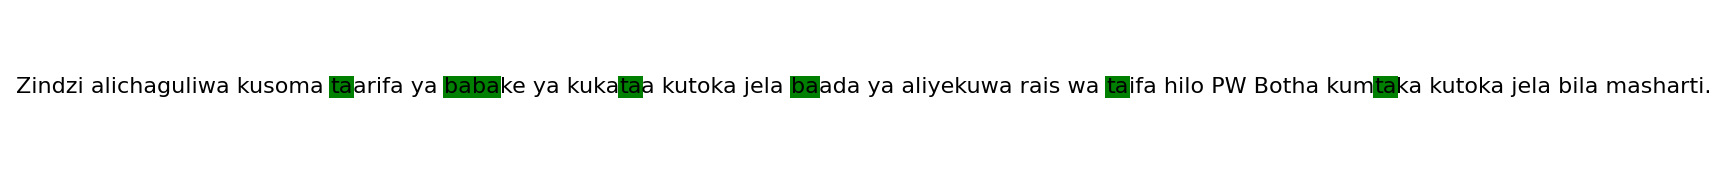

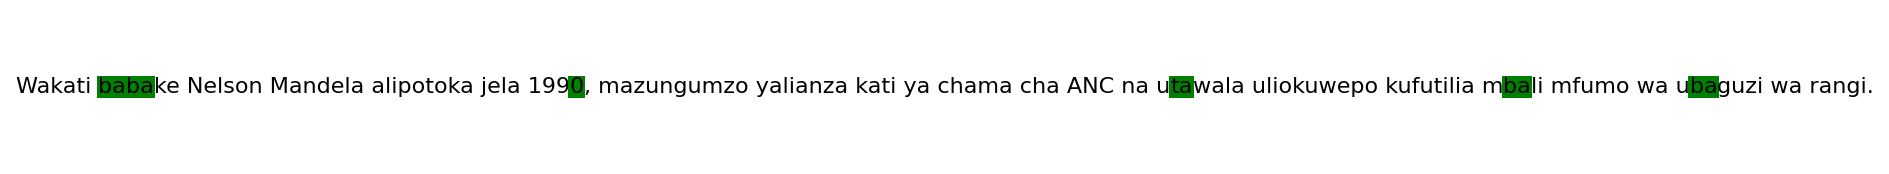

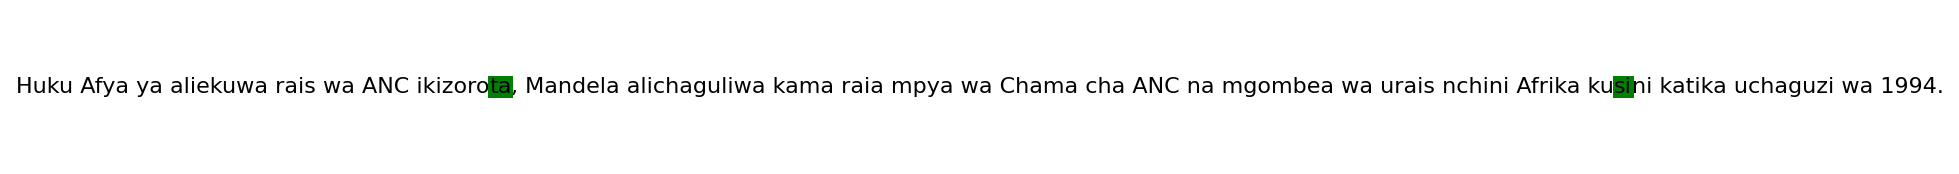

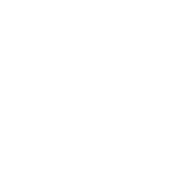

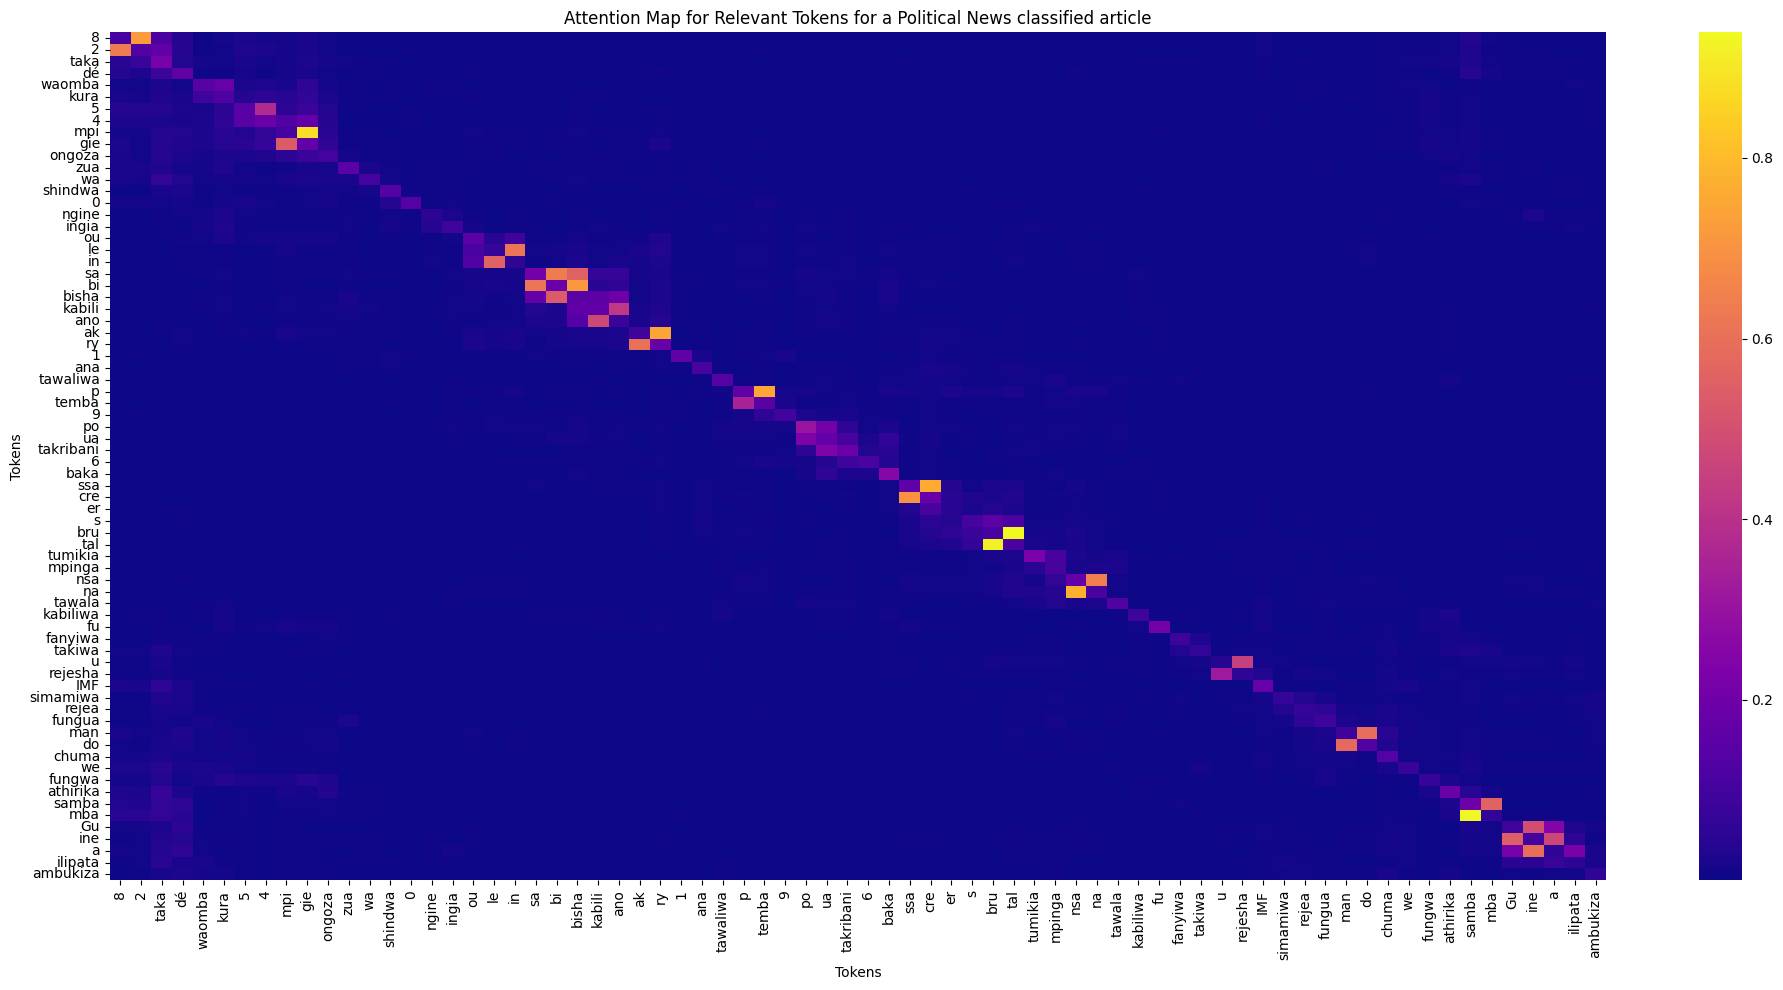

<s> Uchaguzi Guinea: Mzee mwenye umri wa miaka 82 anayetaka kuongoza kwa awamu ya tatu Alpha Condé, Kiongozi wa Guinea mwenye miaka 82, Jumapili hii anawaomba wapigakura wa nchi yake milioni 5.4 wampigie kura aweze kuliongoza taifa hilo kwa muhula wa tatu. Hatua hii inazua wasiwasi kuwa kipindi hiki huenda kikawa cha changamoto kwa Afrika Magharibi. Ikiwa atashindwa kupata ushindi wa zaidi ya 50% ya kura rais huyo pangine anaweza akaingia kwenye duru ya pili dhidi ya mpinzani wake, Cellou Dalein Diallo, hatua ambayo pengine itasabibisha makabiliano makali kwenye mitaa ya Conakry, mji ulio na watu wengi Kuingia madarakani kwa Bwana Condé mwezi Disemba mwaka 2010 ulikuwa mchakato wa kwanza wa demokrasia ya kweli ya kukabidhiana madaraka katika historia ya miaka 52 ya uhuru wa nchi yake - baada ya utawala wa kijeshi ambao ulitawaliwa na vitendo vya ukandamizaji na ukatili, tukio la karibuni lilikuwa mauaji ya septemba 28 mwaka 2009, pale vikosi vilipowaua takribani wafuasi wa upinzani 160

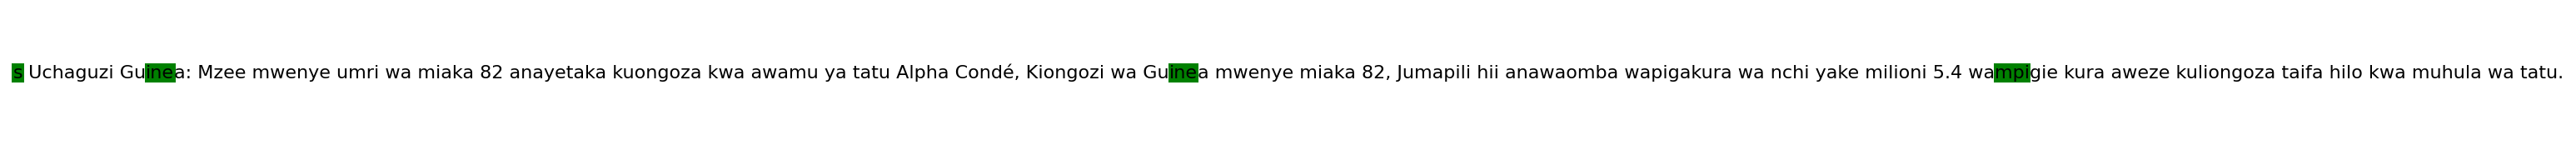

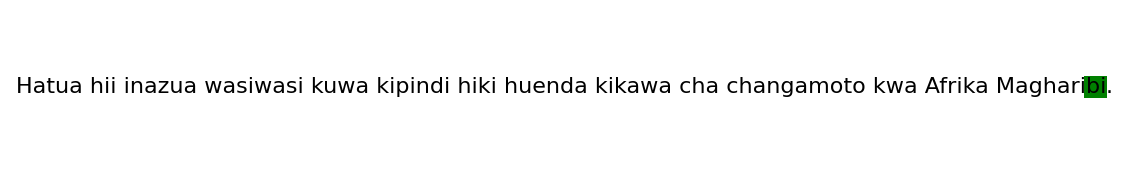

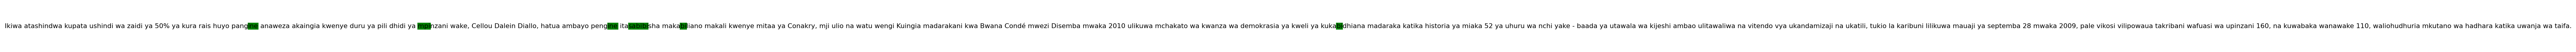

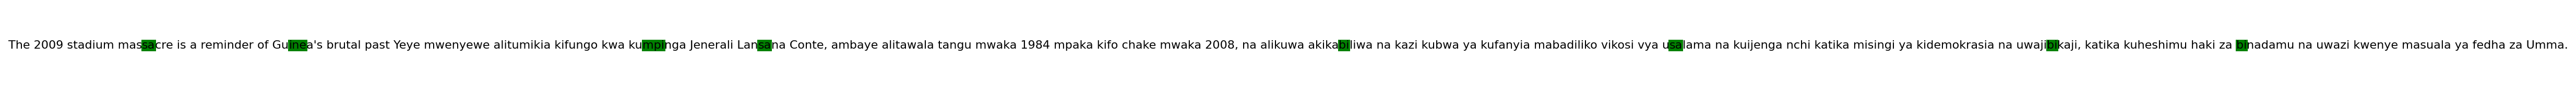

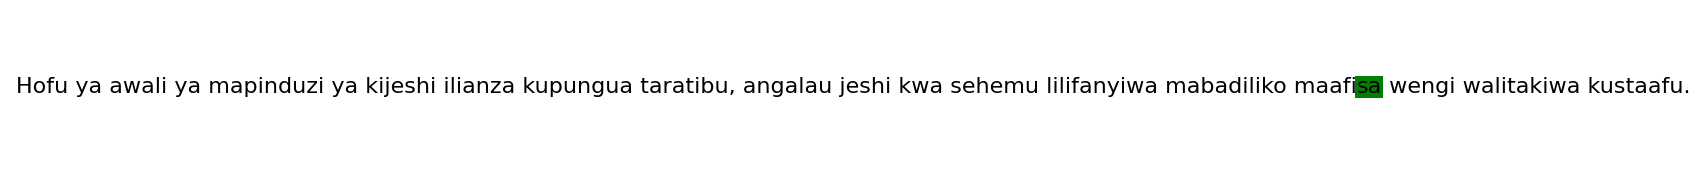

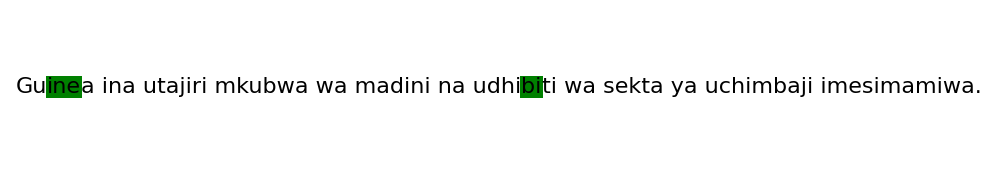

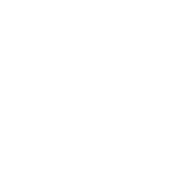

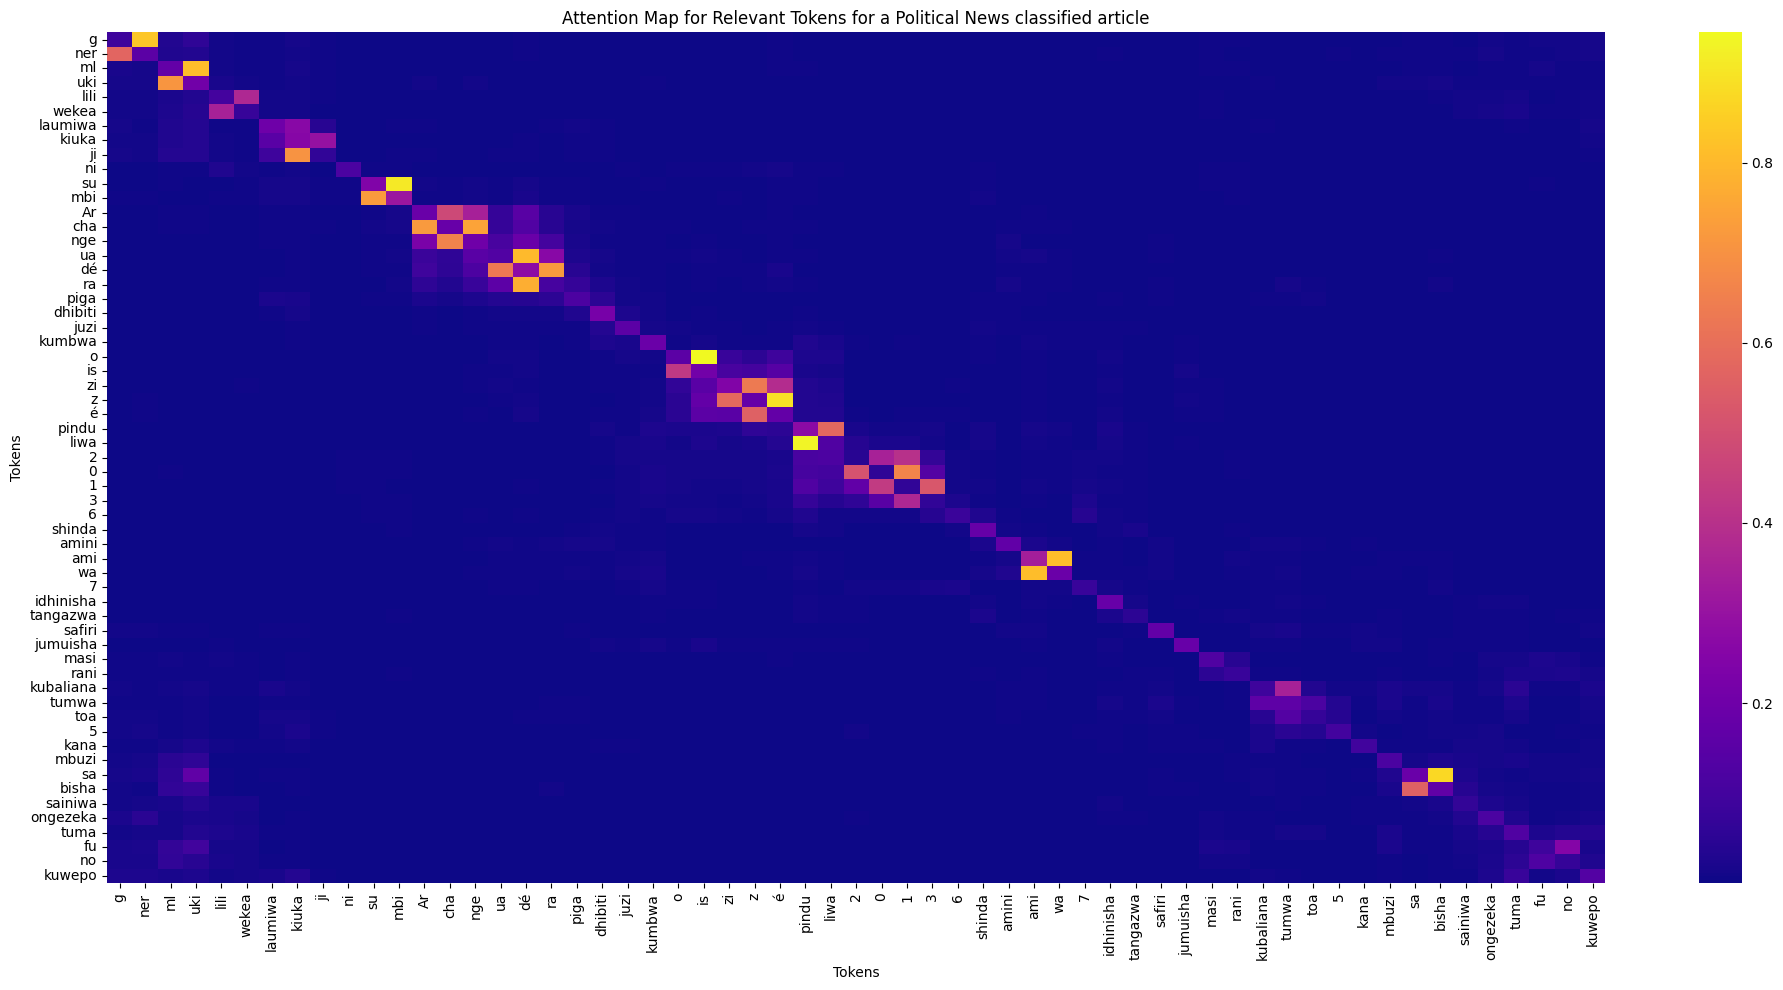

<s> Wagner Group: Kwanini EU ina wasiwasi kufuatia kuwepo mamluki wa Urusi Afrika ya Kati? Wiki hii Muungano wa Ulaya, EU uliliwekea vikwazo Kundi la Wagner, ambao ni muungano wa mamluki wa Urusi wanaolaumiwa kwa ukiukaji wa haki za binadamu katika Jamhuri ya Afrika ya Kati, CAR. Muungano wa Ulaya sasa unasema huwezi tena kuwapa mafunzo wanajeshi wa serikali ya CAR kwa sababu ya uhusiano wao na kundi la Wagner. Barani Afrika wapiganaji wake pia wako nchini Libya, Sudan na Musumbiji na wanaonekana kuwa na wajibu nchini Mali. Mamluki hao wapo CAR kumsaidia Rais Faustin-Archange Touadéra kuwapiga vita waasi, ambao bado wanadhibiti sehemu nyingi za nchi licha ya mafanikio ya hivi majuzi ya serikali. Nchi hiyo imekumbwa na vita vya wenyewe kwa wenyewe tangu Rais Fran<unk>ois Bozizé alipopinduliwa mwaka 2013. Bw Touadéra, ambaye amekuwa madarakani tangu mwaka 2016, amekuwa na wakati mgumu kuwashinda waasi licha ya uwepo wa wanajeshi wa Ufaransa na vikosi vya Umoja wa Mataifa. Serikali ya CAR

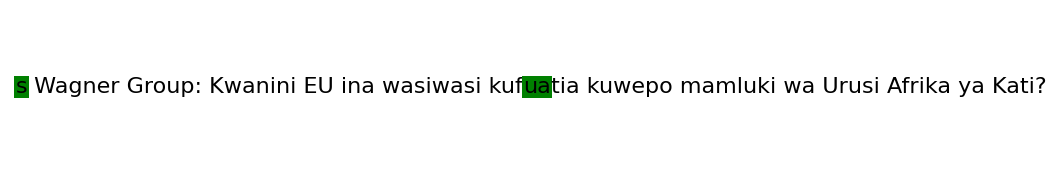

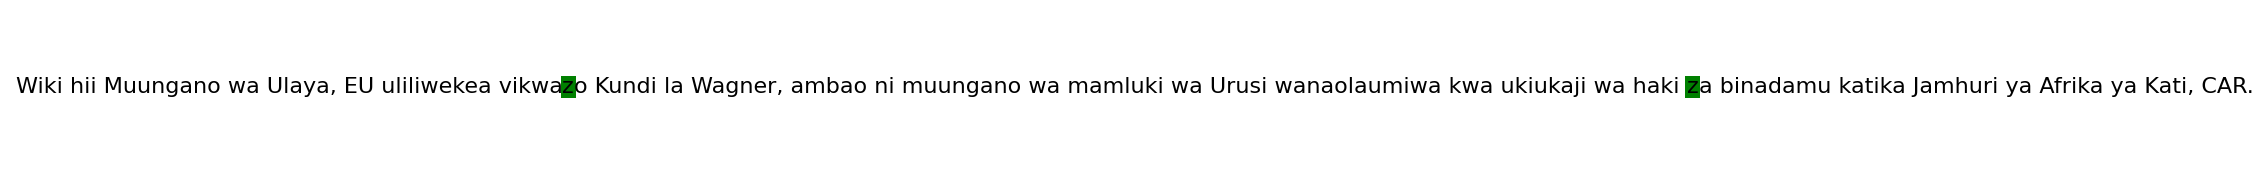

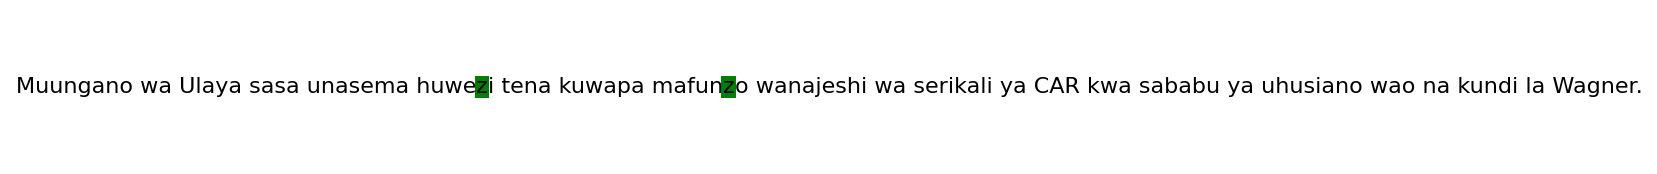

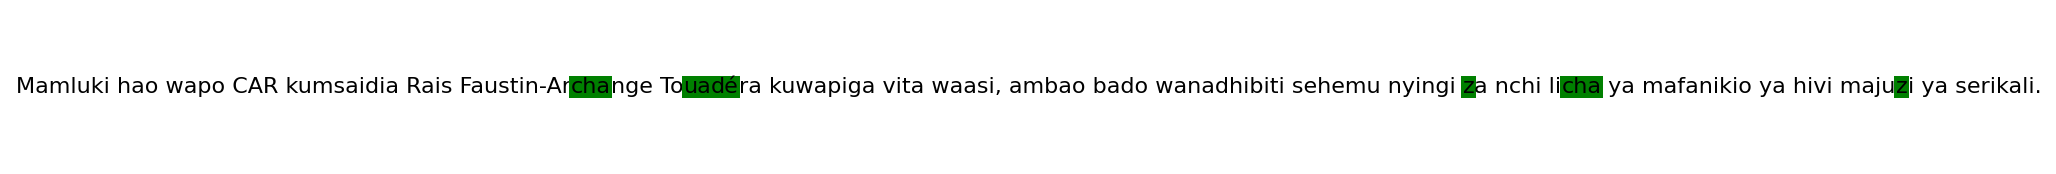

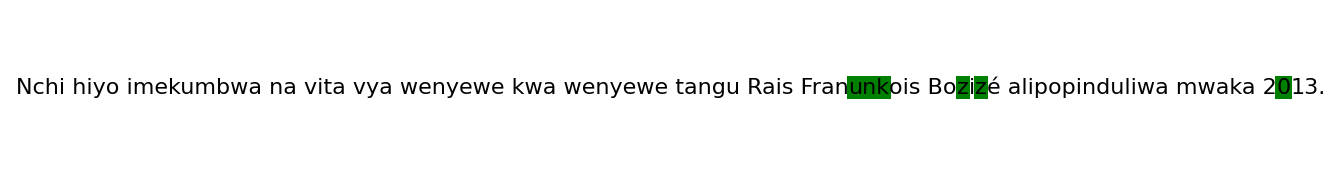

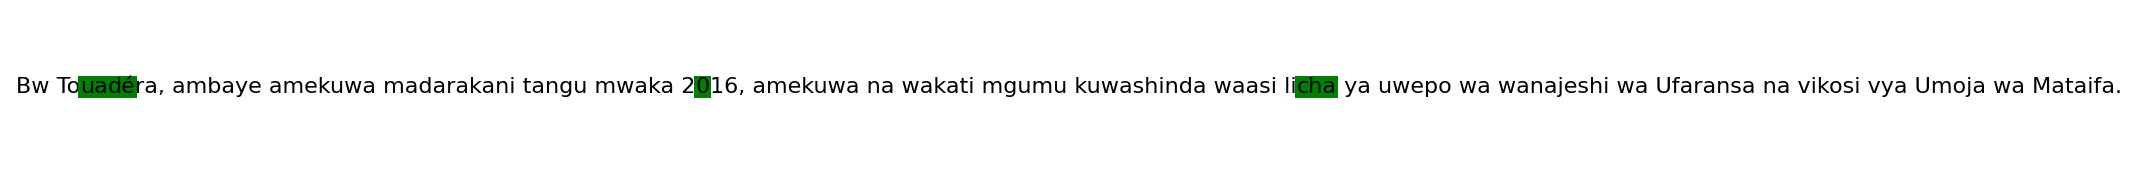

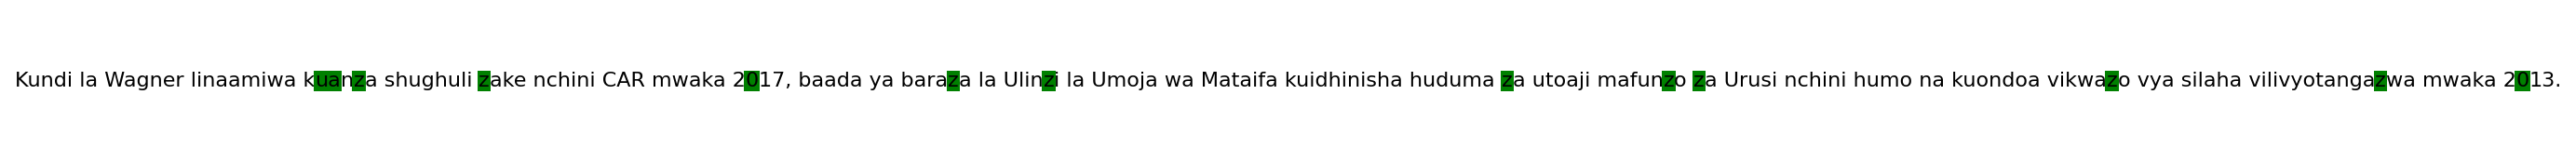

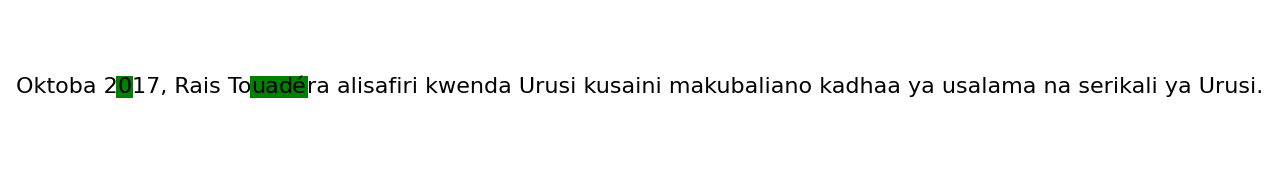

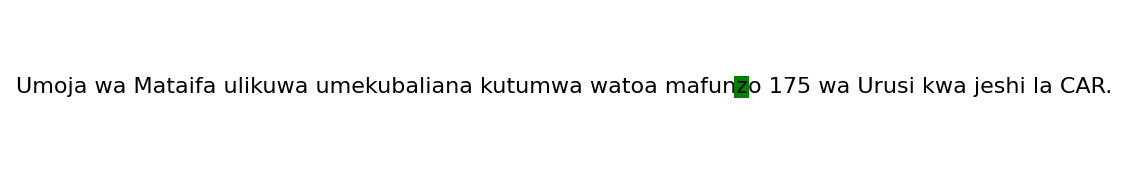

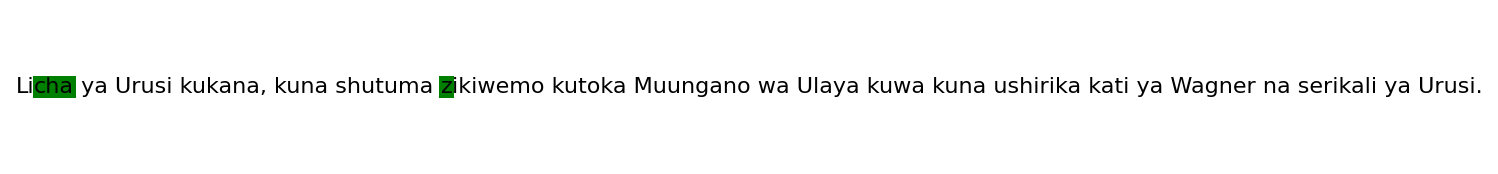

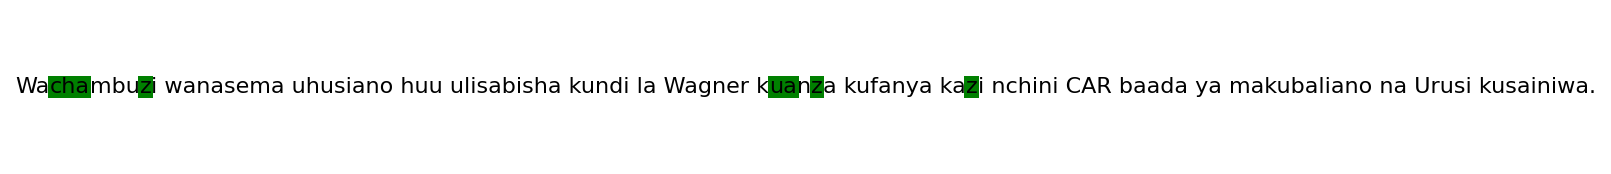

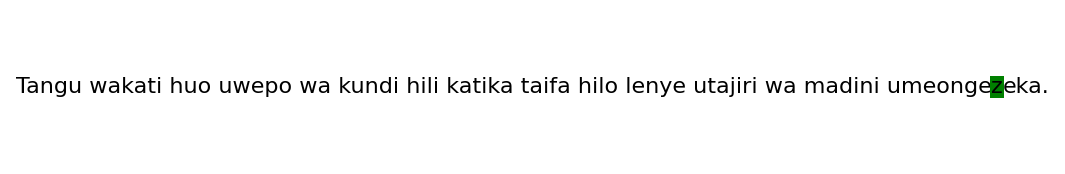

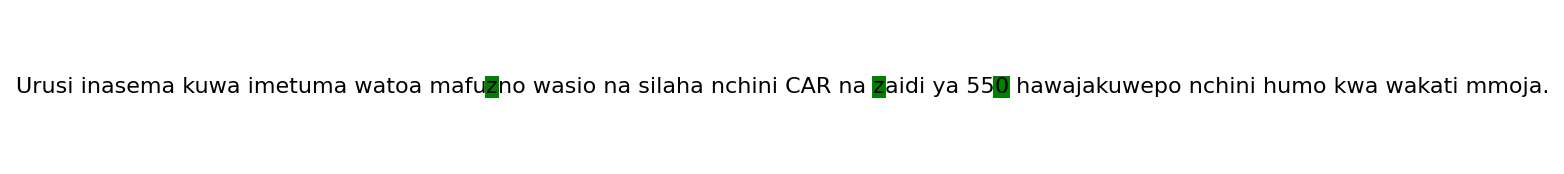

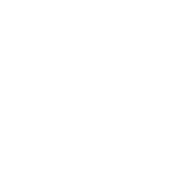

In [11]:
import re
from transformers.pipelines.pt_utils import KeyDataset
from transformers import pipeline
import nltk
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from highlight_text import HighlightText
import time

def plot_attention_maps(attention_weights,tokens,classified_label ):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(attention_weights, cmap='plasma', xticklabels=tokens, yticklabels=tokens)
    if classified_label == 'LABEL_1':
        plt.title("Attention Map for Relevant Tokens for a Political News classified article")
    elif classified_label == 'LABEL_0':
        plt.title("Attention Map for Relevant Tokens for a Non-Political News classified article")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.xticks(rotation=90, ha='center')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def process_attentions_and_tokens(input_ids, attention_weights,top_k=5):
    
    #(8, 6, 512, 512)
    attention_weights = attention_weights.transpose(2,3,1,0)
    #print("transposed shape")
    #print(attention_weights.shape)#(512, 512, 6, 8)
    attention_weights = np.mean(attention_weights, axis=3)
    #print("shape after averageing across heads")
    #print(attention_weights.shape)#(512, 512, 6)
    attention_weights = np.sum(attention_weights, axis=2)
    #print("shape after summing across layers")
    #print(attention_weights.shape)#(512, 512)
    #print(attention_weights)        

    tokens = tokenizer.convert_ids_to_tokens(input_ids.tolist())
    
    #print("shape of attention eights list")
    #print(np.shape(attention_weights.tolist()))
    #print("shape of tokens")
    #print(np.shape(tokens))
    #print(token_attention_pairs[1])


    indices_to_keep = []
    
    existing_tokens = []
    for index, token in enumerate(tokens):
        if token not in tokenizer.all_special_tokens and not re.match(r'[^\w\s]', token) and token not in existing_tokens:
            existing_tokens.append(token)
            indices_to_keep.append(index)
    
    # Use the collected indices to filter attention_weights and tokens
    attention_weights = attention_weights[indices_to_keep]
    # Filter columns (axis 1)
    attention_weights = attention_weights[:, indices_to_keep]
    tokens = [tokens[i] for i in indices_to_keep]
    
    token_attention_pairs = list(zip(tokens, attention_weights.tolist()))
    #print(len(token_attention_pairs))
    
    #print("new shapes of tokens and attention weights after special tokens removed:")
    #print(f"Filtered pairs: {len(token_attention_pairs)}")
    #print(f"Attention weights shape: {attention_weights.shape}")
    #print(f"Tokens length: {len(tokens)}")
    #print(token_attention_pairs)
    
    sorted_pairs = sorted(token_attention_pairs, key=lambda x: np.sum(x[1]), reverse=True) 
    #attentions_map_matrix = np.array([attention for token, attention in sorted_pairs])
    top_tokens = np.array([token for token, attention in sorted_pairs])
    
    #print(np.shape(attentions_map_matrix))
    
    return attention_weights, tokens, top_tokens[:top_k]

def get_sentences_with_tokens(full_text, tokens, classified_label):
    text_props_sentences = []
    sentences = nltk.sent_tokenize(full_text)
    relevant_sentences = []
    for sentence in sentences:
        highlighted_sentence = sentence
        text_props = []
        for token in tokens:
            pattern = re.compile(re.escape(token), re.IGNORECASE)
            highlighted_sentence = pattern.sub(f"<{token}>", highlighted_sentence)
        if highlighted_sentence != sentence:
            relevant_sentences.append(highlighted_sentence)
            for i in range(len(re.findall(r'<\w+>', highlighted_sentence))):
                if classified_label == 'LABEL_1':
                    text_props.append({"bbox": {"facecolor": "green", "linewidth": 0, "pad": 1}})
                elif classified_label == 'LABEL_0':
                    text_props.append({"bbox": {"facecolor": "red", "linewidth": 0, "pad": 1}})
                else:
                    text_props.append({"bbox": {"facecolor": "yellow", "linewidth": 0, "pad": 1}})
            text_props_sentences.append(text_props)
    return relevant_sentences, text_props_sentences


# Set the model to evaluation mode
model.eval()

pipe = pipeline(task ="text-classification", model = model, tokenizer=tokenizer, device=device,max_length=512,  truncation=True)

with torch.no_grad():
    political_count = 0
    i=0
    for example in tokenized_datasets["test"]:
        
        result = pipe(example['headline_text'], truncation=True, max_length=512)
        
        if result[0]['label'] == 'LABEL_0' and i>=10:
            continue
        elif political_count > 5:
            break
        else:
            if result[0]['label'] == 'LABEL_1':
                political_count += 1
        
            print("########")
            print("INPUT "+str(i))
            # Prepare inputs
            inputs = {
                'input_ids': torch.tensor(example['input_ids']).unsqueeze(0).to(device),
                'attention_mask': torch.tensor(example['attention_mask']).unsqueeze(0).to(device),
            }
            # Handle labels
            if 'label' in example:
                labels = torch.tensor([example['label']]).to(device)
            else:
                labels = None
            # Forward pass
            outputs = model(**inputs, labels=labels, output_attentions = True)

            all_attentions =  outputs['attentions']
            _attentions = [att.detach().cpu().numpy() for att in all_attentions]
            attentions_mat = np.asarray(_attentions)[:,0]
            #print("raw attentions shape:")
            #print(attentions_mat.shape)

            # process the attention tensors and filter out unimportant tokens and get the top tokens
            processed_attentions, processed_tokens, top_tokens = process_attentions_and_tokens(inputs['input_ids'][0], attentions_mat, top_k=5)

            #print the top tokens
            print(f"Top 5 attended tokens: {top_tokens}")

            # plot the attention maps for the current input
            plot_attention_maps(processed_attentions, processed_tokens, result[0]['label'])

            # Get the full text
            full_text = tokenizer.decode(inputs['input_ids'][0])
            print(full_text)

            # Get sentences containing the top words
            relevant_sentences, text_props = get_sentences_with_tokens(full_text, top_tokens, result[0]['label'])


            if len(relevant_sentences) == 0:
                print("NO sentences with relevant tokens")
            else:
                # return the sentences with the top tokens highlighted
                for sentence, text_prop in zip(relevant_sentences, text_props):
                    try:
                        fig, ax = plt.subplots(figsize=(2, 2))  
                        plt.axis('off')
                        highlight_textprops = text_prop
                        HighlightText(x=0.5, y=0.5,
                                  fontsize=16,
                                  ha='center', va='center',
                                  s=sentence,
                                  highlight_textprops=highlight_textprops,
                                  ax=ax)
                    except:
                        print("could not highlight")
                        continue     
                    
            print("END OF INPUT "+str(i))   
            print("###########")
            i +=1
        